##  Phase 2: EDA and Energy Loss Attribution

This phase focuses on exploratory data analysis (EDA) and building machine learning models to **quantify and attribute energy losses** in a solar PV plant system.

Our objective:
- **Explain the gap** between theoretical and actual energy output.
- **Break down energy losses** due to:
  -  Cloud cover
  -  Shading (static/dynamic objects)
  -  Temperature effects
  -  Soiling (dust/dirt accumulation)
  -  Other unexplored or novel loss categories

---

###  Goals of the EDA:
- Understand the distribution and relationship between system/environmental features and energy output.
- Identify data quality issues (missing values, anomalies).
- Generate meaningful visualizations for loss patterns at various levels (plant, inverter, string).
- Support accurate loss attribution through data-driven insights.

---

### ⚠ Note
> The data used in this phase was provided by **Zelestra x AWS ML Ascend Challenge** organizers and is not redistributed here.  
> Please refer to official challenge sources for data access.


In [ ]:
import pandas as pd

# Load your dataset
file_path = "Dataset 1.csv"
df = pd.read_csv(file_path)

# Show shape, columns, and first 5 rows
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample rows:\n", df.head())
print("\nMissing values:\n", df.isnull().sum())

Shape: (17472, 109)

Columns: ['datetime', 'meteorolgicas_em_03_02_gii', 'meteorolgicas_em_08_01_gii', 'meteorolgicas_em_03_02_ghi', 'meteorolgicas_em_08_01_ghi', 'meteorolgicas_em_08_01_gii_rear', 'meteorolgicas_em_03_02_gii_rear', 'meteorolgicas_em_03_02_desviacin_incidente', 'meteorolgicas_em_08_01_desviacin_incidente', 'meteorolgicas_em_03_02_t_amb', 'meteorolgicas_em_08_01_t_amb', 'meteorolgicas_em_03_02_h_r', 'meteorolgicas_em_08_01_h_r', 'meteorolgicas_em_03_02_t_dlogger', 'meteorolgicas_em_08_01_t_dlogger', 'meteorolgicas_em_08_01_ws', 'meteorolgicas_em_03_02_ws', 'meteorolgicas_em_08_01_wd', 'meteorolgicas_em_03_02_wd', 'celulas_ctin08_cc_08_1_ir_cel_1', 'celulas_ctin08_cc_08_2_ir_cel_1', 'celulas_ctin03_cc_03_1_ir_cel_1', 'celulas_ctin03_cc_03_2_ir_cel_1', 'celulas_ctin08_cc_08_2_ir_cel_2', 'celulas_ctin03_cc_03_2_ir_cel_2', 'celulas_ctin03_cc_03_1_ir_cel_2', 'celulas_ctin08_cc_08_1_ir_cel_2', 'celulas_ctin08_cc_08_2_t_amb', 'celulas_ctin03_cc_03_1_t_amb', 'celulas_ctin08_cc_

### Data loading and basic inspection

Loads the dataset (`Dataset 1.csv`), prints its shape, columns, sample rows, and missing value summary.


In [ ]:
# Parse datetime column and set as index
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Check for parsing errors (any NaT values)
parsing_errors = df['datetime'].isnull().sum()
print(f"Datetime parsing errors: {parsing_errors}")

# Set as index for time-series analysis
df = df.set_index('datetime')

# Check for duplicate timestamps
duplicate_timestamps = df.index.duplicated().sum()
print(f"Duplicate timestamps: {duplicate_timestamps}")

# Show the first few rows with the new index
print(df.head())


Datetime parsing errors: 0
Duplicate timestamps: 0
                     meteorolgicas_em_03_02_gii  meteorolgicas_em_08_01_gii  \
datetime                                                                      
2024-10-01 00:00:00                         0.0                         0.0   
2024-10-01 00:15:00                         0.0                         0.0   
2024-10-01 00:30:00                         0.0                         0.0   
2024-10-01 00:45:00                         0.0                         0.0   
2024-10-01 01:00:00                         0.0                         0.0   

                     meteorolgicas_em_03_02_ghi  meteorolgicas_em_08_01_ghi  \
datetime                                                                      
2024-10-01 00:00:00                         0.0                         0.0   
2024-10-01 00:15:00                         0.0                         0.0   
2024-10-01 00:30:00                         0.0                         0.0   


### Datetime parsing and index setup

Parses the `datetime` column, handles parsing errors, sets it as the index for time-series analysis, and checks for duplicate timestamps.


In [ ]:
# Solar Power Plant Data Column Grouping and Tagging

import pandas as pd

# --- Load the CSV and parse datetime ---
csv_path = 'Dataset 1.csv'  # <-- Update path if needed
df = pd.read_csv(csv_path)
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df = df.set_index('datetime')  # Set datetime as index

# --- Column Group Definitions ---
column_groups = {
    # Meteorological Irradiance
    "irradiance_meteorological": [
        'meteorolgicas_em_03_02_gii', 'meteorolgicas_em_08_01_gii',
        'meteorolgicas_em_03_02_ghi', 'meteorolgicas_em_08_01_ghi',
        'meteorolgicas_em_08_01_gii_rear', 'meteorolgicas_em_03_02_gii_rear',
    ],
    "irradiance_cells": [
        'celulas_ctin08_cc_08_1_ir_cel_1', 'celulas_ctin08_cc_08_2_ir_cel_1',
        'celulas_ctin03_cc_03_1_ir_cel_1', 'celulas_ctin03_cc_03_2_ir_cel_1',
        'celulas_ctin08_cc_08_2_ir_cel_2', 'celulas_ctin03_cc_03_2_ir_cel_2',
        'celulas_ctin03_cc_03_1_ir_cel_2', 'celulas_ctin08_cc_08_1_ir_cel_2',
    ],
    "tracking_deviation": [
        'meteorolgicas_em_03_02_desviacin_incidente', 'meteorolgicas_em_08_01_desviacin_incidente'
    ],
    "temperature_ambient": [
        'meteorolgicas_em_03_02_t_amb', 'meteorolgicas_em_08_01_t_amb',
        'celulas_ctin08_cc_08_2_t_amb', 'celulas_ctin03_cc_03_1_t_amb',
        'celulas_ctin08_cc_08_1_t_amb', 'celulas_ctin03_cc_03_2_t_amb',
    ],
    "temperature_module": [
        'celulas_ctin03_cc_03_1_t_mod', 'celulas_ctin08_cc_08_2_t_mod',
        'celulas_ctin03_cc_03_2_t_mod', 'celulas_ctin08_cc_08_1_t_mod',
    ],
    "temperature_datalogger": [
        'meteorolgicas_em_03_02_t_dlogger', 'meteorolgicas_em_08_01_t_dlogger'
    ],
    "humidity": [
        'meteorolgicas_em_03_02_h_r', 'meteorolgicas_em_08_01_h_r'
    ],
    "wind_speed": [
        'meteorolgicas_em_08_01_ws', 'meteorolgicas_em_03_02_ws',
        'celulas_ctin03_cc_03_2_wind_speed', 'celulas_ctin08_cc_08_1_wind_speed',
        'celulas_ctin08_cc_08_2_wind_speed', 'celulas_ctin03_cc_03_1_wind_speed',
    ],
    "wind_direction": [
        'meteorolgicas_em_08_01_wd', 'meteorolgicas_em_03_02_wd'
    ],
    "string_voltage": [col for col in df.columns if 'pv_v' in col],
    "string_current_ct03_s8": [
        f'inversores_ctin03_strings_string8_pv_i{i}' for i in range(1, 14)
    ],
    "string_current_ct03_s10": [
        f'inversores_ctin03_strings_string10_pv_i{i}' for i in range(1, 14)
    ],
    "string_current_ct08_s9": [
        f'inversores_ctin08_strings_string9_pv_i{i}' for i in range(1, 14)
    ],
    "string_current_ct08_s12": [
        f'inversores_ctin08_strings_string12_pv_i{i}' for i in range(1, 11)
    ],
    "inverter_power_ac": [
        'inversores_ctin08_inv_08_08_p', 'inversores_ctin03_inv_03_03_p'
    ],
    "inverter_power_dc": [
        'inversores_ctin03_inv_03_03_p_dc', 'inversores_ctin08_inv_08_08_p_dc'
    ],
    "inverter_energy": [
        'inversores_ctin03_inv_03_03_eact_tot', 'inversores_ctin08_inv_08_08_eact_tot'
    ],
    "tracker_position": [
        'seguidores_ct08_gcu081_t0808029_pos_obj', 'seguidores_ct08_gcu081_t0808029_pos_ang',
        'seguidores_ct03_gcu031_t0308035_pos_ang', 'seguidores_ct03_gcu031_t0308035_pos_obj'
    ],
    "tracker_mode": [
        'seguidores_ct08_gcu081_t0808029_workingmode', 'seguidores_ct03_gcu031_t0308035_workingmode'
    ],
    "plant_power_control": [
        'ppc_consig_p', 'ppc_p_tot', 'ppc_eact_export', 'ppc_eact_imp'
    ],
    "theoretical_power": [
        'ttr_potenciaproducible'
    ]
}

# --- Analysis Group Definitions ---
analysis_groups = {
    "all_irradiance": column_groups["irradiance_meteorological"] + column_groups["irradiance_cells"],
    "all_temperature": column_groups["temperature_ambient"] + column_groups["temperature_module"] + column_groups["temperature_datalogger"],
    "all_wind": column_groups["wind_speed"] + column_groups["wind_direction"],
    "all_string_electrical": (
        column_groups["string_current_ct03_s8"] +
        column_groups["string_current_ct03_s10"] +
        column_groups["string_current_ct08_s9"] +
        column_groups["string_current_ct08_s12"] +
        column_groups["string_voltage"]
    ),
    "all_power": (
        column_groups["inverter_power_ac"] +
        column_groups["inverter_power_dc"] +
        column_groups["plant_power_control"] +
        column_groups["theoretical_power"]
    ),
    "all_tracker": column_groups["tracker_position"] + column_groups["tracker_mode"],
    "environmental": column_groups["temperature_ambient"] + column_groups["humidity"] + column_groups["wind_speed"] + column_groups["wind_direction"],
    "soiling_analysis": column_groups["irradiance_cells"] + column_groups["irradiance_meteorological"],
    "tracking_analysis": column_groups["tracking_deviation"] + column_groups["tracker_position"] + column_groups["tracker_mode"]
}

# --- Functions for Column Access ---
def get_columns(group_name):
    """Return existing columns for the given group name."""
    if group_name in column_groups:
        return [col for col in column_groups[group_name] if col in df.columns]
    elif group_name in analysis_groups:
        return [col for col in analysis_groups[group_name] if col in df.columns]
    else:
        print(f"Group '{group_name}' not found.")
        return []

def get_subset_df(group_name, include_datetime=True):
    """Return a subset DataFrame for a given group."""
    cols = get_columns(group_name)
    if include_datetime:
        # Include datetime as index or column
        return df[cols].copy().reset_index()  # Datetime becomes a column
    else:
        return df[cols].copy()

# --- Display Column Group Info ---
print("Available column groups:")
for group in column_groups:
    real_cols = get_columns(group)
    print(f"  - {group}: {len(real_cols)} columns")

print("\nAvailable analysis groups:")
for group in analysis_groups:
    real_cols = get_columns(group)
    print(f"  - {group}: {len(real_cols)} columns")

# --- Example Usages ---
irradiance_df = get_subset_df("all_irradiance")
print(f"\nIrradiance dataframe shape: {irradiance_df.shape}")

power_df = get_subset_df("all_power")
print(f"Power dataframe shape: {power_df.shape}")

env_df = get_subset_df("environmental")
print(f"Environmental dataframe shape: {env_df.shape}")


Available column groups:
  - irradiance_meteorological: 6 columns
  - irradiance_cells: 8 columns
  - tracking_deviation: 2 columns
  - temperature_ambient: 6 columns
  - temperature_module: 4 columns
  - temperature_datalogger: 2 columns
  - humidity: 2 columns
  - wind_speed: 6 columns
  - wind_direction: 2 columns
  - string_voltage: 4 columns
  - string_current_ct03_s8: 13 columns
  - string_current_ct03_s10: 13 columns
  - string_current_ct08_s9: 13 columns
  - string_current_ct08_s12: 10 columns
  - inverter_power_ac: 2 columns
  - inverter_power_dc: 2 columns
  - inverter_energy: 2 columns
  - tracker_position: 4 columns
  - tracker_mode: 2 columns
  - plant_power_control: 4 columns
  - theoretical_power: 1 columns

Available analysis groups:
  - all_irradiance: 14 columns
  - all_temperature: 12 columns
  - all_wind: 8 columns
  - all_string_electrical: 53 columns
  - all_power: 9 columns
  - all_tracker: 6 columns
  - environmental: 16 columns
  - soiling_analysis: 14 columns


### Column grouping and tagging

Defines logical groups of columns representing different sensor categories (e.g., irradiance, temperature, power, trackers).  
Provides helper functions to access columns by group and extract relevant DataFrames for analysis.


In [ ]:
# 1. Show missing data counts for all columns
missing_counts = df.isnull().sum().sort_values(ascending=False)
print("Missing values per column:\n", missing_counts[missing_counts > 0])

# 2. Show missing rates per group
print("\nMissing value summary by group:")
for group in column_groups:
    cols = get_columns(group)
    if cols:
        missing_rate = df[cols].isnull().mean().mean() * 100
        print(f"  - {group}: {missing_rate:.2f}% average missing")



Missing values per column:
 seguidores_ct03_gcu031_t0308035_workingmode    17203
seguidores_ct08_gcu081_t0808029_workingmode    17158
inversores_ctin03_strings_string8_pv_i1         9351
inversores_ctin03_strings_string8_pv_i10        9341
inversores_ctin03_strings_string8_pv_i2         9340
                                               ...  
ttr_potenciaproducible                             6
meteorolgicas_em_08_01_h_r                         5
ppc_p_tot                                          5
meteorolgicas_em_08_01_wd                          4
meteorolgicas_em_08_01_t_amb                       4
Length: 108, dtype: int64

Missing value summary by group:
  - irradiance_meteorological: 2.12% average missing
  - irradiance_cells: 1.57% average missing
  - tracking_deviation: 2.58% average missing
  - temperature_ambient: 1.64% average missing
  - temperature_module: 1.62% average missing
  - temperature_datalogger: 1.77% average missing
  - humidity: 1.71% average missing
  - wind

### Missing value analysis

Displays the count of missing values for each column and summarizes the average missing rate for each defined column group.


In [ ]:
# --- 1. Drop columns with very high missingness (>95%) ---
high_missing_cols = [col for col in df.columns if df[col].isnull().mean() > 0.95]
df_cleaned = df.drop(columns=high_missing_cols)
print(f"Dropped columns with >95% missing: {high_missing_cols}")

# --- 2. Interpolate and fill low-missing columns (≤5%) ---
low_missing_cols = [col for col in df_cleaned.columns if df_cleaned[col].isnull().mean() <= 0.05]
df_cleaned[low_missing_cols] = (
    df_cleaned[low_missing_cols]
    .interpolate(method='linear', limit_direction='both')
    .fillna(method='ffill')
    .fillna(method='bfill')
)

# --- 3. Identify columns with moderate missingness (50–95%) ---
mid_missing_cols = [col for col in df_cleaned.columns if 0.5 < df_cleaned[col].isnull().mean() <= 0.95]
print(f"Columns with 50–95% missing (inspect before deciding): {mid_missing_cols}")

# --- 4. Remove night data for operational analysis ---
irr_col = 'meteorolgicas_em_03_02_ghi'  # Main irradiance column
day_df = df_cleaned[df_cleaned[irr_col] > 5].copy()  # Keep rows with GHI > 5 W/m²
print(f"Shape after removing night data: {day_df.shape}")

# Now, day_df is ready for most solar performance and loss analyses!


Dropped columns with >95% missing: ['seguidores_ct08_gcu081_t0808029_workingmode', 'seguidores_ct03_gcu031_t0308035_workingmode']
Columns with 50–95% missing (inspect before deciding): ['inversores_ctin03_strings_string8_pv_v', 'inversores_ctin03_strings_string8_pv_i9', 'inversores_ctin03_strings_string8_pv_i13', 'inversores_ctin03_strings_string8_pv_i1', 'inversores_ctin03_strings_string8_pv_i6', 'inversores_ctin03_strings_string8_pv_i4', 'inversores_ctin03_strings_string8_pv_i11', 'inversores_ctin03_strings_string8_pv_i10', 'inversores_ctin03_strings_string8_pv_i2', 'inversores_ctin03_strings_string8_pv_i5', 'inversores_ctin03_strings_string8_pv_i7', 'inversores_ctin03_strings_string8_pv_i12', 'inversores_ctin03_strings_string8_pv_i3', 'inversores_ctin03_strings_string8_pv_i8', 'inversores_ctin03_strings_string10_pv_i9', 'inversores_ctin03_strings_string10_pv_i7', 'inversores_ctin03_strings_string10_pv_i4', 'inversores_ctin03_strings_string10_pv_i12', 'inversores_ctin03_strings_strin

/tmp/ipython-input-5-2898895571.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')
/tmp/ipython-input-5-2898895571.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')


### Data cleaning

Drops columns with very high missingness (>95%), interpolates and fills columns with low missingness (≤5%), lists columns with moderate missingness (50–95%), and filters the dataset to keep only daytime records (GHI > 5 W/m²).


In [ ]:
# Total rows before filtering
total_rows = df_cleaned.shape[0]

# Total rows after filtering (daytime only)
day_rows = day_df.shape[0]

# Nighttime rows dropped
night_rows = total_rows - day_rows
night_pct = night_rows / total_rows * 100

print(f"Total rows before filtering: {total_rows}")
print(f"Total rows after removing night data: {day_rows}")
print(f"Nighttime rows dropped: {night_rows} ({night_pct:.2f}%)")


Total rows before filtering: 17472
Total rows after removing night data: 7844
Nighttime rows dropped: 9628 (55.11%)


### Day-night data filtering summary

Reports the number and percentage of rows removed during the filtering of nighttime data based on irradiance.


In [ ]:
# --- Basic Outlier Removal for Solar PV Data ---

def clean_outliers(df, col, lower, upper):
    """
    Sets values outside [lower, upper] to NaN for a given column.
    Prints how many values were set to NaN.
    """
    if col not in df.columns:
        return df
    before = df[col].isnull().sum()
    df[col] = df[col].where(df[col].between(lower, upper), float('nan'))
    after = df[col].isnull().sum()
    print(f"{col}: set {after-before} outliers to NaN")
    return df

# --- Set physical ranges per group (customize for your plant if needed) ---
outlier_limits = {
    'irradiance': (0, 1400),       # W/m²
    'temperature': (-10, 80),      # °C
    'wind_speed': (0, 40),         # m/s
    'humidity': (0, 100),          # %
    'power': (0, 48000),           # kW (48 MW plant, change if needed)
    'string_voltage': (0, 1500),   # V
    'string_current': (0, 40),     # A
}

# --- Apply limits to relevant columns using your grouping functions ---

# Irradiance
for col in get_columns('all_irradiance'):
    day_df = clean_outliers(day_df, col, *outlier_limits['irradiance'])

# Temperature
for col in get_columns('all_temperature'):
    day_df = clean_outliers(day_df, col, *outlier_limits['temperature'])

# Wind Speed
for col in get_columns('wind_speed'):
    day_df = clean_outliers(day_df, col, *outlier_limits['wind_speed'])

# Humidity
for col in get_columns('humidity'):
    day_df = clean_outliers(day_df, col, *outlier_limits['humidity'])

# Power (AC/DC/Theoretical)
for col in get_columns('all_power'):
    day_df = clean_outliers(day_df, col, *outlier_limits['power'])

# String Voltages
for col in get_columns('string_voltage'):
    day_df = clean_outliers(day_df, col, *outlier_limits['string_voltage'])

# String Currents (all current groups)
string_current_cols = (
    get_columns('string_current_ct03_s8') +
    get_columns('string_current_ct03_s10') +
    get_columns('string_current_ct08_s9') +
    get_columns('string_current_ct08_s12')
)
for col in string_current_cols:
    day_df = clean_outliers(day_df, col, *outlier_limits['string_current'])

# --- Optional: Interpolate/fill after outlier removal if needed ---
# day_df = day_df.interpolate(method='linear', limit_direction='both').fillna(method='ffill').fillna(method='bfill')

print("Basic outlier cleaning complete!")


meteorolgicas_em_03_02_gii: set 0 outliers to NaN
meteorolgicas_em_08_01_gii: set 0 outliers to NaN
meteorolgicas_em_03_02_ghi: set 0 outliers to NaN
meteorolgicas_em_08_01_ghi: set 0 outliers to NaN
meteorolgicas_em_08_01_gii_rear: set 0 outliers to NaN
meteorolgicas_em_03_02_gii_rear: set 0 outliers to NaN
celulas_ctin08_cc_08_1_ir_cel_1: set 0 outliers to NaN
celulas_ctin08_cc_08_2_ir_cel_1: set 0 outliers to NaN
celulas_ctin03_cc_03_1_ir_cel_1: set 0 outliers to NaN
celulas_ctin03_cc_03_2_ir_cel_1: set 0 outliers to NaN
celulas_ctin08_cc_08_2_ir_cel_2: set 0 outliers to NaN
celulas_ctin03_cc_03_2_ir_cel_2: set 0 outliers to NaN
celulas_ctin03_cc_03_1_ir_cel_2: set 0 outliers to NaN
celulas_ctin08_cc_08_1_ir_cel_2: set 0 outliers to NaN
meteorolgicas_em_03_02_t_amb: set 0 outliers to NaN
meteorolgicas_em_08_01_t_amb: set 0 outliers to NaN
celulas_ctin08_cc_08_2_t_amb: set 0 outliers to NaN
celulas_ctin03_cc_03_1_t_amb: set 0 outliers to NaN
celulas_ctin08_cc_08_1_t_amb: set 0 outlie

### Outlier removal

Defines physical limits for key feature groups and removes values outside these ranges by setting them to NaN. Applies this cleaning across irradiance, temperature, wind speed, humidity, power, string voltage, and string current columns.


In [ ]:
# Fill all remaining NaN values in the cleaned daytime dataframe
day_df = (
    day_df
    .interpolate(method='linear', limit_direction='both')
    .fillna(method='ffill')
    .fillna(method='bfill')
)
def normalize_clean_vs_dirty_panels(df):
    """
    Normalize irradiance and power measurements across clean vs dirty panels
    to enable fair comparison and soiling analysis.
    """
    # Create a copy to avoid modifying original
    df_norm = df.copy()

    # Define clean and dirty sensor mappings based on your plant layout
    # You may need to adjust these based on your actual sensor locations
    sensor_mapping = {
        'clean_reference': {
            'irradiance_meteorological': ['meteorolgicas_em_03_02_ghi', 'meteorolgicas_em_03_02_gii'],
            'irradiance_cells': ['celulas_ctin03_cc_03_1_ir_cel_1', 'celulas_ctin03_cc_03_1_ir_cel_2'],
            'power_ac': ['inversores_ctin03_inv_03_03_p'],
            'power_dc': ['inversores_ctin03_inv_03_03_p_dc'],
            'location_id': 'CT03'
        },
        'dirty_test': {
            'irradiance_meteorological': ['meteorolgicas_em_08_01_ghi', 'meteorolgicas_em_08_01_gii'],
            'irradiance_cells': ['celulas_ctin08_cc_08_1_ir_cel_1', 'celulas_ctin08_cc_08_1_ir_cel_2'],
            'power_ac': ['inversores_ctin08_inv_08_08_p'],
            'power_dc': ['inversores_ctin08_inv_08_08_p_dc'],
            'location_id': 'CT08'
        }
    }

    # 1. Calculate average irradiance for clean and dirty sections
    print("\n1. Calculating average irradiance for clean vs dirty sections...")

    # Clean reference irradiance (meteorological + cell sensors)
    clean_irr_cols = [col for col in sensor_mapping['clean_reference']['irradiance_meteorological'] +
                     sensor_mapping['clean_reference']['irradiance_cells'] if col in df_norm.columns]

    dirty_irr_cols = [col for col in sensor_mapping['dirty_test']['irradiance_meteorological'] +
                     sensor_mapping['dirty_test']['irradiance_cells'] if col in df_norm.columns]

    if clean_irr_cols and dirty_irr_cols:
        df_norm['clean_irradiance_avg'] = df_norm[clean_irr_cols].mean(axis=1)
        df_norm['dirty_irradiance_avg'] = df_norm[dirty_irr_cols].mean(axis=1)

        print(f"   Clean irradiance columns: {clean_irr_cols}")
        print(f"   Dirty irradiance columns: {dirty_irr_cols}")
    else:
        print("   Warning: Could not find sufficient irradiance columns for normalization")
        return df_norm

    # 2. Calculate soiling ratio (dirty/clean)
    print("\n2. Calculating soiling ratio...")
    df_norm['soiling_ratio'] = df_norm['dirty_irradiance_avg'] / df_norm['clean_irradiance_avg']

    # Clean extreme ratios (should be between 0.5 and 1.1)
    df_norm['soiling_ratio'] = df_norm['soiling_ratio'].clip(0.5, 1.1)

    # Fill any NaN or infinite values
    df_norm['soiling_ratio'] = df_norm['soiling_ratio'].fillna(1.0)
    import numpy as np
    df_norm['soiling_ratio'] = df_norm['soiling_ratio'].replace([np.inf, -np.inf], 1.0)

    print(f"   Soiling ratio stats:")
    print(f"   Mean: {df_norm['soiling_ratio'].mean():.4f}")
    print(f"   Std:  {df_norm['soiling_ratio'].std():.4f}")
    print(f"   Min:  {df_norm['soiling_ratio'].min():.4f}")
    print(f"   Max:  {df_norm['soiling_ratio'].max():.4f}")

    # 3. Normalize dirty irradiance to clean reference
    print("\n3. Normalizing dirty irradiance to clean reference...")

    # Create normalized versions of dirty irradiance sensors
    for col in dirty_irr_cols:
        if col in df_norm.columns:
            normalized_col = f"{col}_normalized"
            df_norm[normalized_col] = df_norm[col] / df_norm['soiling_ratio']
            print(f"   Created: {normalized_col}")

    # 4. Calculate power normalization factors
    print("\n4. Calculating power normalization factors...")

    # Get power columns for clean and dirty sections
    clean_power_cols = [col for col in sensor_mapping['clean_reference']['power_ac'] +
                       sensor_mapping['clean_reference']['power_dc'] if col in df_norm.columns]

    dirty_power_cols = [col for col in sensor_mapping['dirty_test']['power_ac'] +
                       sensor_mapping['dirty_test']['power_dc'] if col in df_norm.columns]

    if clean_power_cols and dirty_power_cols:
        df_norm['clean_power_avg'] = df_norm[clean_power_cols].mean(axis=1)
        df_norm['dirty_power_avg'] = df_norm[dirty_power_cols].mean(axis=1)

        # Calculate expected power ratio based on irradiance
        df_norm['expected_power_ratio'] = df_norm['clean_irradiance_avg'] / df_norm['dirty_irradiance_avg']
        df_norm['expected_power_ratio'] = df_norm['expected_power_ratio'].clip(0.5, 2.0)
        df_norm['expected_power_ratio'] = df_norm['expected_power_ratio'].fillna(1.0)

        # Normalize dirty power to clean reference
        for col in dirty_power_cols:
            if col in df_norm.columns:
                normalized_col = f"{col}_normalized"
                df_norm[normalized_col] = df_norm[col] * df_norm['expected_power_ratio']
                print(f"   Created: {normalized_col}")

    # 5. Calculate soiling loss percentage
    print("\n5. Calculating soiling loss metrics...")

    df_norm['soiling_loss_pct'] = (1 - df_norm['soiling_ratio']) * 100
    df_norm['irradiance_loss_pct'] = (df_norm['clean_irradiance_avg'] - df_norm['dirty_irradiance_avg']) / df_norm['clean_irradiance_avg'] * 100

    # Clean extreme loss percentages
    df_norm['soiling_loss_pct'] = df_norm['soiling_loss_pct'].clip(-10, 50)
    df_norm['irradiance_loss_pct'] = df_norm['irradiance_loss_pct'].clip(-10, 50)

    print(f"   Average soiling loss: {df_norm['soiling_loss_pct'].mean():.2f}%")
    print(f"   Average irradiance loss: {df_norm['irradiance_loss_pct'].mean():.2f}%")

    # 6. Create time-based soiling analysis
    print("\n6. Creating time-based soiling analysis...")

    # Daily soiling analysis
    df_norm['date'] = df_norm.index.date
    daily_soiling = df_norm.groupby('date').agg({
        'soiling_ratio': ['mean', 'std', 'min', 'max'],
        'soiling_loss_pct': ['mean', 'std', 'min', 'max'],
        'clean_irradiance_avg': 'mean',
        'dirty_irradiance_avg': 'mean'
    }).round(4)

    # Flatten column names
    daily_soiling.columns = ['_'.join(col).strip() for col in daily_soiling.columns.values]

    # Save daily soiling summary
    daily_soiling.to_csv('daily_soiling_analysis.csv')
    print("   Daily soiling analysis saved to: daily_soiling_analysis.csv")

    # 7. Identify clean vs dirty periods
    print("\n7. Identifying clean vs dirty periods...")

    # Define thresholds for clean/dirty classification
    soiling_threshold = 0.95  # Below this ratio = significant soiling

    df_norm['is_clean_period'] = df_norm['soiling_ratio'] >= soiling_threshold
    df_norm['is_dirty_period'] = df_norm['soiling_ratio'] < soiling_threshold

    clean_periods = df_norm['is_clean_period'].sum()
    dirty_periods = df_norm['is_dirty_period'].sum()
    total_periods = len(df_norm)

    print(f"   Clean periods: {clean_periods} ({clean_periods/total_periods*100:.1f}%)")
    print(f"   Dirty periods: {dirty_periods} ({dirty_periods/total_periods*100:.1f}%)")

    # 8. Create summary statistics
    print("\n8. Creating normalization summary...")

    normalization_summary = {
        'total_data_points': len(df_norm),
        'clean_periods_count': clean_periods,
        'dirty_periods_count': dirty_periods,
        'avg_soiling_ratio': df_norm['soiling_ratio'].mean(),
        'avg_soiling_loss_pct': df_norm['soiling_loss_pct'].mean(),
        'max_soiling_loss_pct': df_norm['soiling_loss_pct'].max(),
        'clean_irradiance_sensors': len(clean_irr_cols),
        'dirty_irradiance_sensors': len(dirty_irr_cols),
        'normalized_columns_created': len([col for col in df_norm.columns if '_normalized' in col])
    }

    print("   Normalization Summary:")
    for key, value in normalization_summary.items():
        print(f"   - {key}: {value}")

    return df_norm, normalization_summary, daily_soiling
day_df, norm_summary, daily_soiling_stats = normalize_clean_vs_dirty_panels(day_df)

# Check if any NaNs remain
nan_count = day_df.isnull().sum().sum()
print(f"Total NaNs remaining after filling: {nan_count}")



1. Calculating average irradiance for clean vs dirty sections...
   Clean irradiance columns: ['meteorolgicas_em_03_02_ghi', 'meteorolgicas_em_03_02_gii', 'celulas_ctin03_cc_03_1_ir_cel_1', 'celulas_ctin03_cc_03_1_ir_cel_2']
   Dirty irradiance columns: ['meteorolgicas_em_08_01_ghi', 'meteorolgicas_em_08_01_gii', 'celulas_ctin08_cc_08_1_ir_cel_1', 'celulas_ctin08_cc_08_1_ir_cel_2']

2. Calculating soiling ratio...
   Soiling ratio stats:
   Mean: 0.9449
   Std:  0.1395
   Min:  0.5000
   Max:  1.1000

3. Normalizing dirty irradiance to clean reference...
   Created: meteorolgicas_em_08_01_ghi_normalized
   Created: meteorolgicas_em_08_01_gii_normalized
   Created: celulas_ctin08_cc_08_1_ir_cel_1_normalized
   Created: celulas_ctin08_cc_08_1_ir_cel_2_normalized

4. Calculating power normalization factors...
   Created: inversores_ctin08_inv_08_08_p_normalized
   Created: inversores_ctin08_inv_08_08_p_dc_normalized

5. Calculating soiling loss metrics...
   Average soiling loss: 5.51%
 

/tmp/ipython-input-8-797488800.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')
/tmp/ipython-input-8-797488800.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')


### Soiling analysis and normalization

Fills remaining missing values, computes soiling ratio between clean and dirty panels, normalizes irradiance and power measurements, and generates daily soiling summaries. Identifies clean vs dirty periods and outputs key statistics.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_soiling_visualizations(df_norm):
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Solar Panel Soiling Analysis - Clean vs Dirty Comparison', fontsize=16)

    # 1. Soiling ratio over time
    axes[0,0].plot(df_norm.index, df_norm['soiling_ratio'], alpha=0.7, linewidth=0.5)
    axes[0,0].axhline(y=1.0, color='green', linestyle='--', alpha=0.7, label='Perfect Clean (1.0)')
    axes[0,0].axhline(y=0.95, color='orange', linestyle='--', alpha=0.7, label='5% Loss Threshold')
    axes[0,0].set_title('Soiling Ratio Over Time')
    axes[0,0].set_ylabel('Dirty/Clean Irradiance Ratio')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Soiling loss percentage distribution
    axes[0,1].hist(df_norm['soiling_loss_pct'], bins=50, alpha=0.7, edgecolor='black')
    axes[0,1].axvline(df_norm['soiling_loss_pct'].mean(), color='red', linestyle='--',
                      label=f'Mean: {df_norm["soiling_loss_pct"].mean():.2f}%')
    axes[0,1].set_title('Distribution of Soiling Losses')
    axes[0,1].set_xlabel('Soiling Loss (%)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Clean vs Dirty irradiance scatter
    sample_data = df_norm.sample(min(5000, len(df_norm)))  # Sample for better visualization
    axes[1,0].scatter(sample_data['clean_irradiance_avg'], sample_data['dirty_irradiance_avg'],
                      alpha=0.5, s=1)

    max_irr = max(sample_data['clean_irradiance_avg'].max(), sample_data['dirty_irradiance_avg'].max())
    axes[1,0].plot([0, max_irr], [0, max_irr], 'r--', alpha=0.8, label='Perfect Correlation')
    axes[1,0].set_title('Clean vs Dirty Irradiance Correlation')
    axes[1,0].set_xlabel('Clean Irradiance (W/m²)')
    axes[1,0].set_ylabel('Dirty Irradiance (W/m²)')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 4. Daily average soiling trend
    daily_avg = df_norm.groupby(df_norm.index.date)['soiling_ratio'].mean()
    axes[1,1].plot(daily_avg.index, daily_avg.values, marker='o', markersize=2)
    axes[1,1].set_title('Daily Average Soiling Ratio Trend')
    axes[1,1].set_xlabel('Date')
    axes[1,1].set_ylabel('Average Soiling Ratio')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig('soiling_analysis_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig

def analyze_soiling_patterns(df_norm):
    print("\n" + "="*50)
    print("SOILING PATTERN ANALYSIS")
    print("="*50)
    # 1. Hourly soiling patterns
    hourly_soiling = df_norm.groupby(df_norm.index.hour).agg({
        'soiling_ratio': ['mean', 'std'],
        'soiling_loss_pct': ['mean', 'std']
    }).round(4)
    hourly_soiling.columns = ['_'.join(col).strip() for col in hourly_soiling.columns.values]

    # 2. Weekly soiling patterns
    weekly_soiling = df_norm.groupby(df_norm.index.dayofweek).agg({
        'soiling_ratio': ['mean', 'std'],
        'soiling_loss_pct': ['mean', 'std']
    }).round(4)
    weekly_soiling.columns = ['_'.join(col).strip() for col in weekly_soiling.columns.values]
    weekly_soiling.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # 3. Monthly soiling patterns
    monthly_soiling = df_norm.groupby(df_norm.index.month).agg({
        'soiling_ratio': ['mean', 'std'],
        'soiling_loss_pct': ['mean', 'std']
    }).round(4)
    monthly_soiling.columns = ['_'.join(col).strip() for col in monthly_soiling.columns.values]

    # 4. Correlation analysis (optional: can add if needed)
    return hourly_soiling, weekly_soiling, monthly_soiling

def generate_soiling_report(df_norm, norm_summary):
    report = {
        'dataset_info': {
            'total_data_points': len(df_norm),
            'date_range': f"{df_norm.index.min()} to {df_norm.index.max()}",
            'analysis_period_days': (df_norm.index.max() - df_norm.index.min()).days
        },
        'soiling_metrics': {
            'average_soiling_ratio': df_norm['soiling_ratio'].mean(),
            'average_soiling_loss_pct': df_norm['soiling_loss_pct'].mean(),
            'maximum_soiling_loss_pct': df_norm['soiling_loss_pct'].max(),
            'minimum_soiling_ratio': df_norm['soiling_ratio'].min(),
            'soiling_variability_std': df_norm['soiling_ratio'].std()
        },
        'clean_vs_dirty_periods': {
            'clean_periods_count': norm_summary['clean_periods_count'],
            'dirty_periods_count': norm_summary['dirty_periods_count'],
            'clean_periods_percentage': norm_summary['clean_periods_count'] / norm_summary['total_data_points'] * 100,
            'dirty_periods_percentage': norm_summary['dirty_periods_count'] / norm_summary['total_data_points'] * 100
        },
        'power_impact': {
            'avg_clean_power': df_norm['clean_power_avg'].mean() if 'clean_power_avg' in df_norm.columns else 'N/A',
            'avg_dirty_power': df_norm['dirty_power_avg'].mean() if 'dirty_power_avg' in df_norm.columns else 'N/A',
            'power_loss_due_to_soiling': 'Calculated based on irradiance loss'
        }
    }
    return report


### Soiling visualizations and reporting

Generates key plots (soiling ratio over time, loss distribution, irradiance correlation, daily trends) and computes hourly, weekly, and monthly soiling patterns. Builds a summary report with dataset details, soiling metrics, period classification, and power impact estimates.


✓ Saved: daily_soiling_analysis.csv


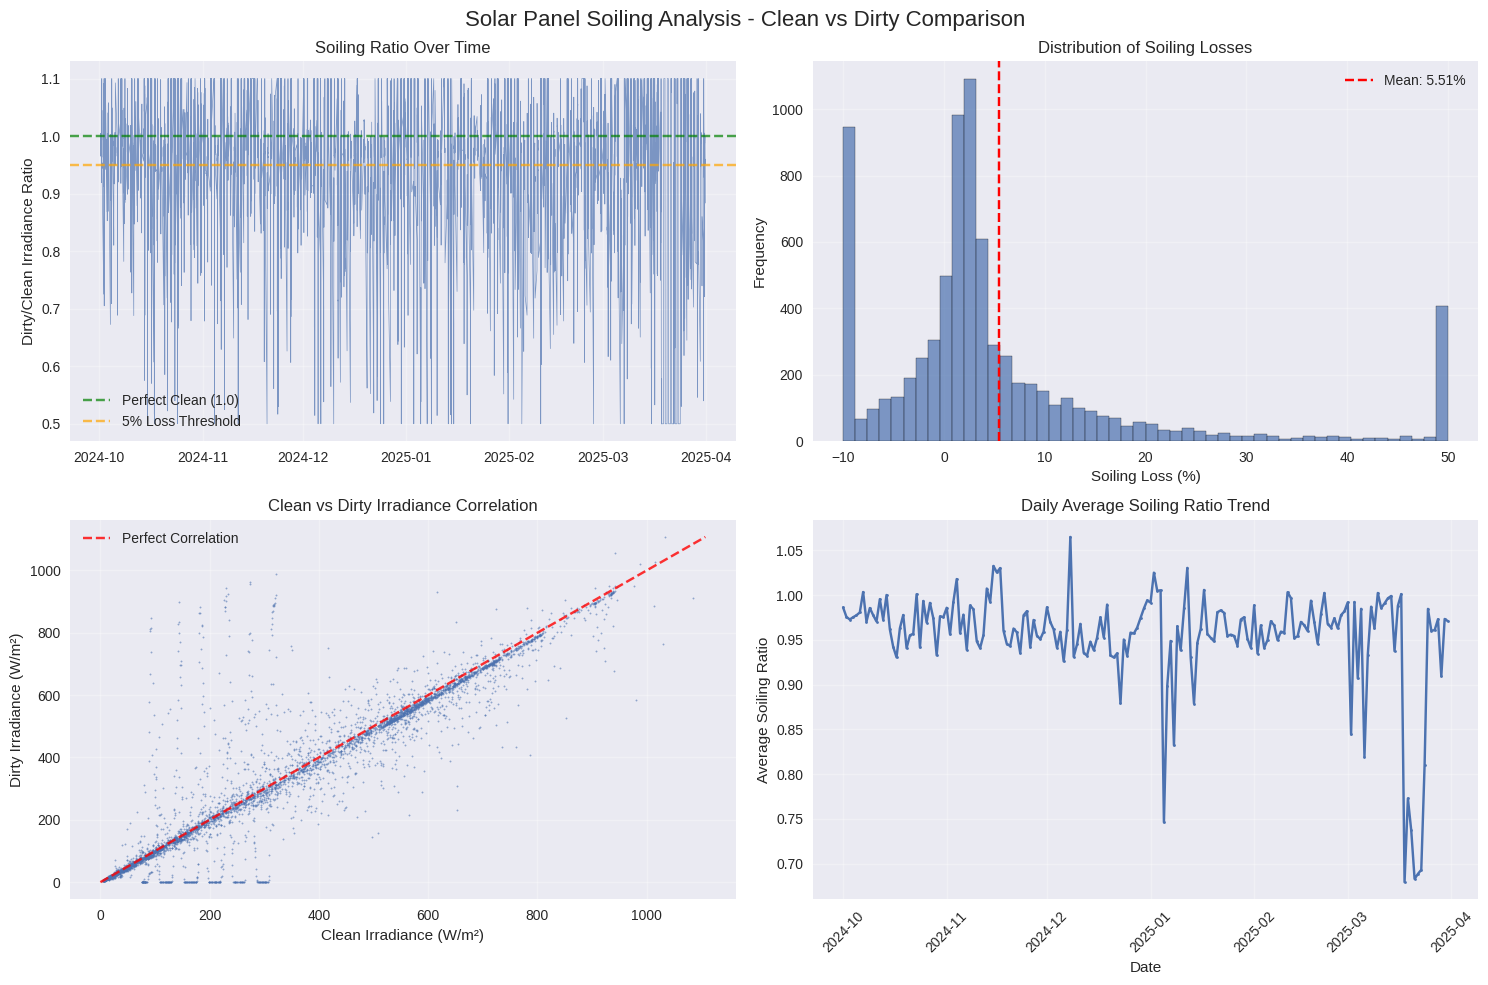

✓ Saved: soiling_analysis_plots.png

SOILING PATTERN ANALYSIS
✓ Saved: soiling_analysis_results.xlsx
✓ Saved: soiling_analysis_report.json


In [ ]:
# === Generate all required output files for reporting and documentation ===

# 1. Save the daily soiling statistics DataFrame
daily_soiling_stats.to_csv('daily_soiling_analysis.csv')
print("✓ Saved: daily_soiling_analysis.csv")

# 2. Save the visualization plot as a PNG
soiling_fig = create_soiling_visualizations(day_df)
print("✓ Saved: soiling_analysis_plots.png")

# 3. Save soiling pattern analysis (hourly, weekly, monthly) and correlations as Excel
hourly_patterns, weekly_patterns, monthly_patterns = analyze_soiling_patterns(day_df)

import pandas as pd
with pd.ExcelWriter('soiling_analysis_results.xlsx') as writer:
    hourly_patterns.to_excel(writer, sheet_name='Hourly_Patterns')
    weekly_patterns.to_excel(writer, sheet_name='Weekly_Patterns')
    monthly_patterns.to_excel(writer, sheet_name='Monthly_Patterns')
print("✓ Saved: soiling_analysis_results.xlsx")

# 4. Save the JSON summary report
final_report = generate_soiling_report(day_df, norm_summary)
import json
with open('soiling_analysis_report.json', 'w') as f:
    json.dump(final_report, f, indent=2, default=str)
print("✓ Saved: soiling_analysis_report.json")


### Save outputs

Exports daily soiling statistics, visualizations, pattern analyses (hourly, weekly, monthly), and a JSON summary report to files for documentation and reporting.


In [ ]:
print("=== DataFrame Shape ===")
print(day_df.shape)

print("\n=== DataFrame Info ===")
print(day_df.info())

print("\n=== Descriptive Statistics (All Features) ===")
print(day_df.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]))


=== DataFrame Shape ===
(7844, 123)

=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7844 entries, 2024-10-01 08:00:00 to 2025-03-31 20:00:00
Columns: 123 entries, meteorolgicas_em_03_02_gii to is_dirty_period
dtypes: bool(2), float64(120), object(1)
memory usage: 7.3+ MB
None

=== Descriptive Statistics (All Features) ===
       meteorolgicas_em_03_02_gii  meteorolgicas_em_08_01_gii  \
count                 7844.000000                 7844.000000   
mean                   362.443439                  352.692887   
std                    259.356697                  267.683133   
min                      3.000000                    0.000000   
1%                       7.000000                    0.000000   
5%                      19.669792                    7.000000   
25%                    126.167065                   94.519068   
50%                    313.785592                  324.857368   
75%                    581.693811                  573.727665 

### Final data summary

Displays the shape, info summary, and descriptive statistics (including key percentiles) of the cleaned and processed dataset.


In [ ]:
print("\n=== Missing Values After All Cleaning ===")
print(day_df.isnull().sum().sort_values(ascending=False).head(10))



=== Missing Values After All Cleaning ===
meteorolgicas_em_03_02_gii                    0
meteorolgicas_em_08_01_gii                    0
meteorolgicas_em_03_02_ghi                    0
meteorolgicas_em_08_01_ghi                    0
meteorolgicas_em_08_01_gii_rear               0
meteorolgicas_em_03_02_gii_rear               0
meteorolgicas_em_03_02_desviacin_incidente    0
meteorolgicas_em_08_01_desviacin_incidente    0
meteorolgicas_em_03_02_t_amb                  0
meteorolgicas_em_08_01_t_amb                  0
dtype: int64


### Final missing value check

Displays the top 10 columns with remaining missing values after all cleaning steps.


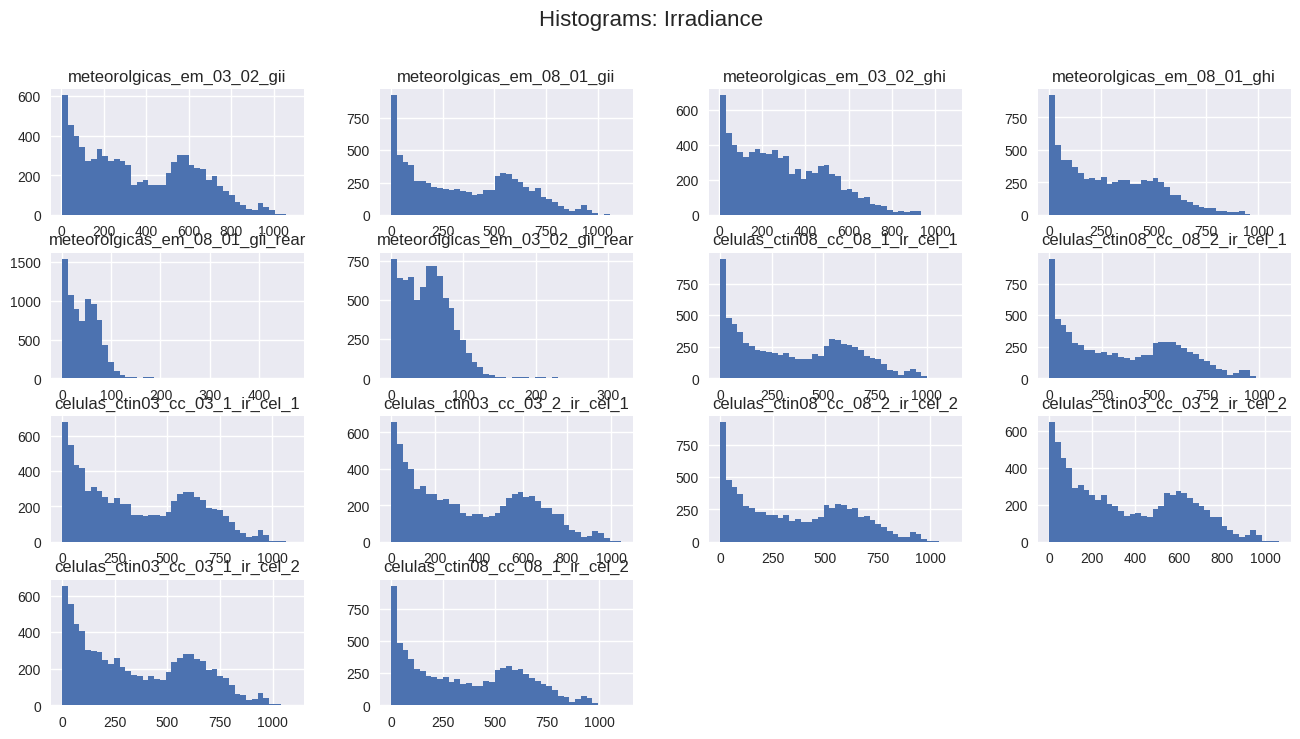

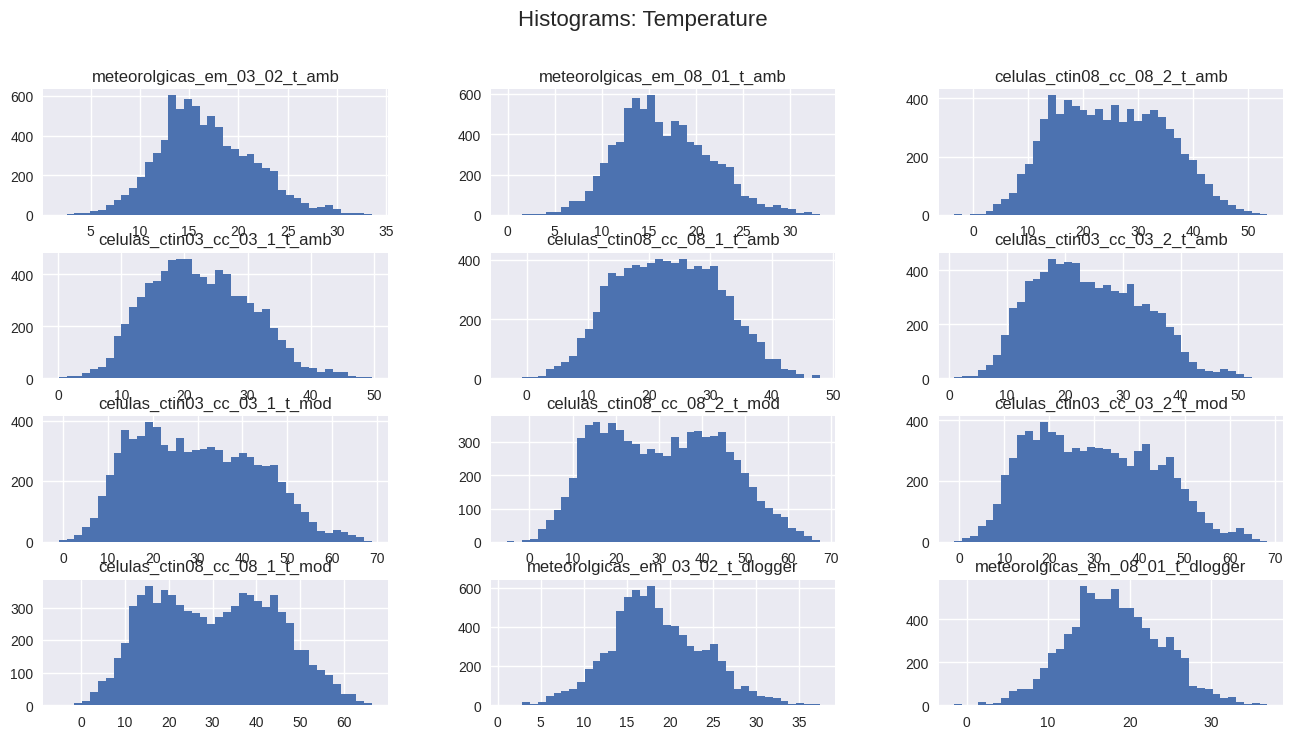

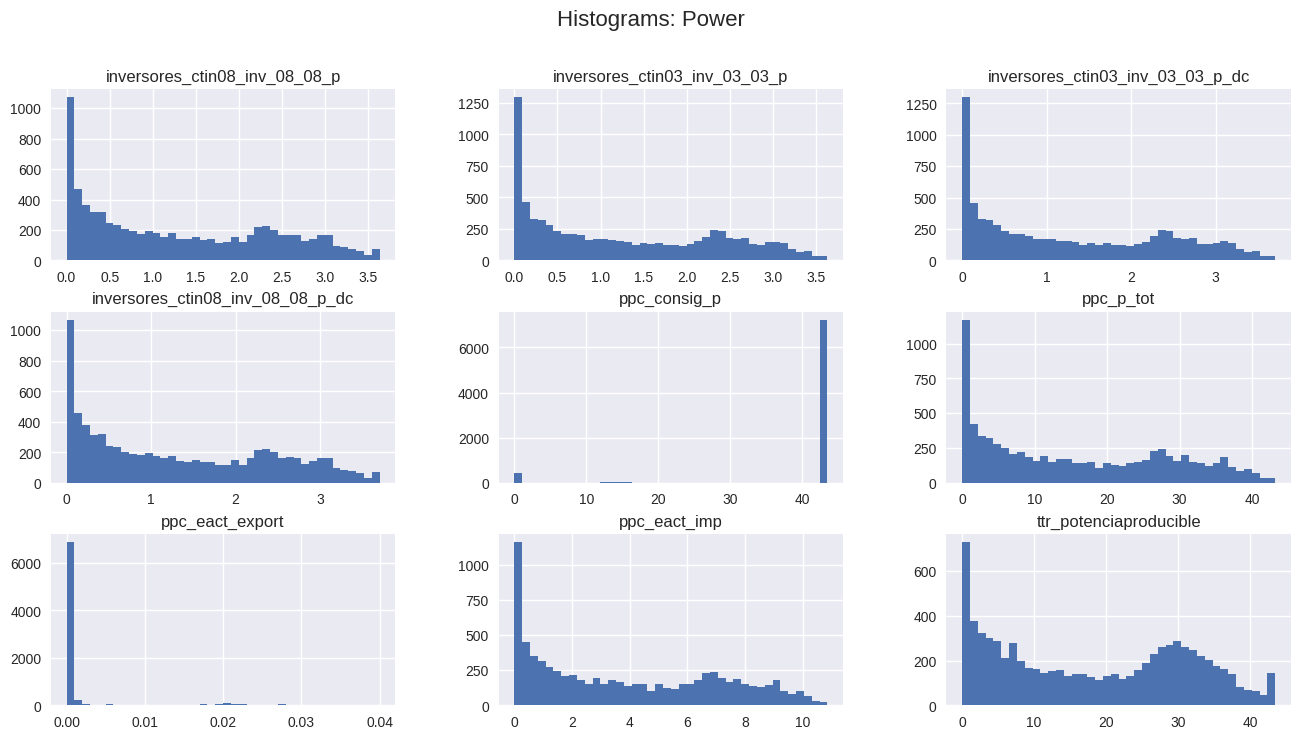

In [ ]:
import matplotlib.pyplot as plt

def plot_histograms(df, cols, groupname):
    df[cols].hist(bins=40, figsize=(16, 8))
    plt.suptitle(f'Histograms: {groupname}', fontsize=16)
    plt.show()

# Example: Irradiance
plot_histograms(day_df, get_columns('all_irradiance'), 'Irradiance')
# Example: Temperature
plot_histograms(day_df, get_columns('all_temperature'), 'Temperature')
# Example: Power
plot_histograms(day_df, get_columns('all_power'), 'Power')


### Feature distribution plots

Generates histograms for selected feature groups (irradiance, temperature, power) to visualize their distributions.


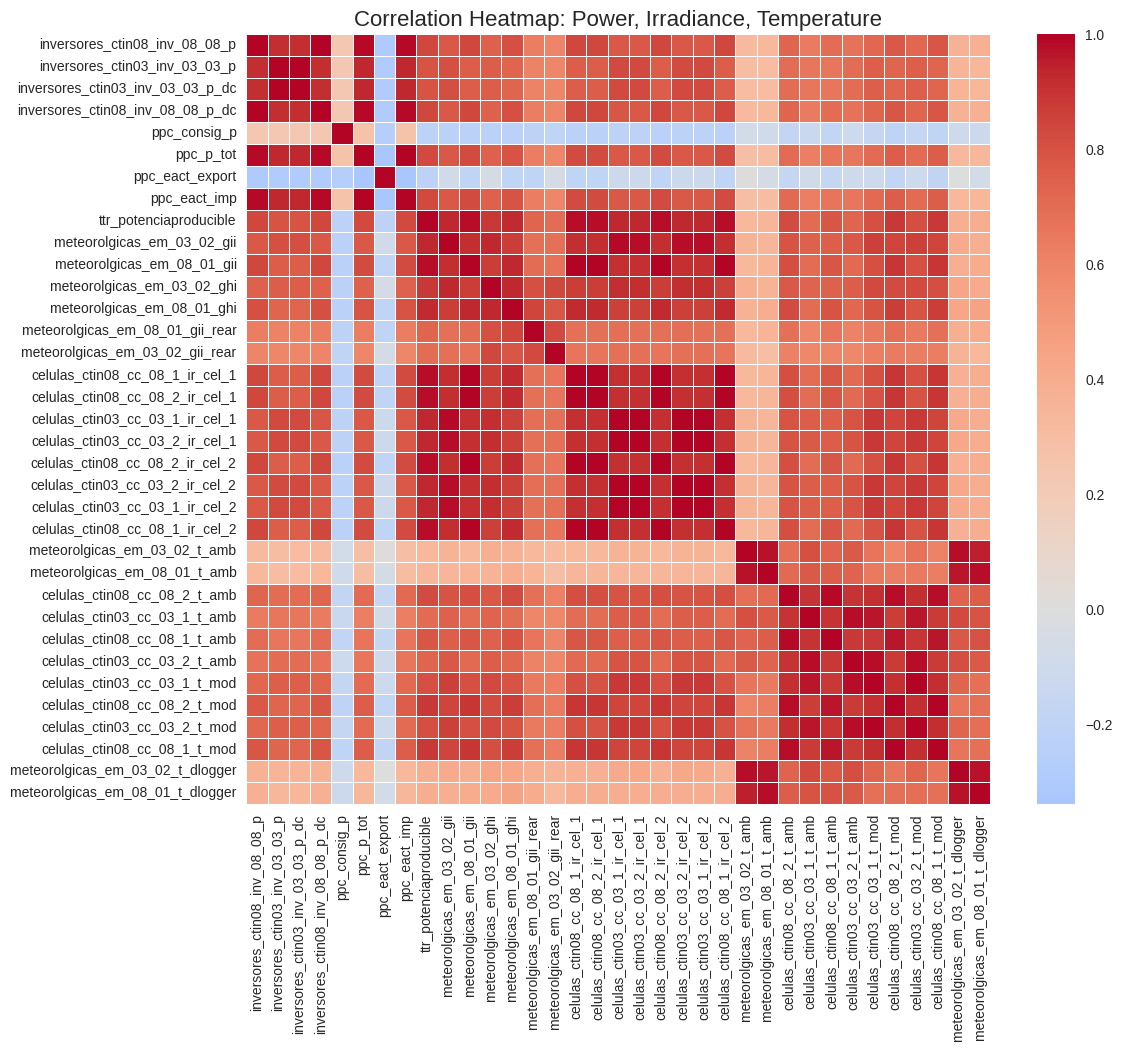

In [ ]:
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 10))
corr = day_df[get_columns('all_power') + get_columns('all_irradiance') + get_columns('all_temperature')].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, linewidths=.5)
plt.title('Correlation Heatmap: Power, Irradiance, Temperature', fontsize=16)
plt.show()


### Correlation heatmap

Generates a heatmap to visualize correlations among power, irradiance, and temperature features.


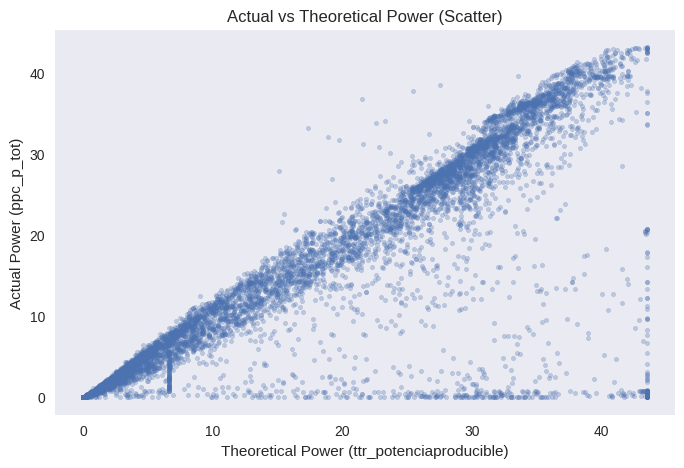

In [ ]:
# Plot actual power vs theoretical for loss pattern
plt.figure(figsize=(8, 5))
plt.scatter(day_df['ttr_potenciaproducible'], day_df['ppc_p_tot'], alpha=0.3, s=10)
plt.xlabel("Theoretical Power (ttr_potenciaproducible)")
plt.ylabel("Actual Power (ppc_p_tot)")
plt.title("Actual vs Theoretical Power (Scatter)")
plt.grid()
plt.show()


### Actual vs theoretical power scatter plot

Creates a scatter plot comparing actual power output (`ppc_p_tot`) against theoretical power (`ttr_potenciaproducible`) to visualize loss patterns.


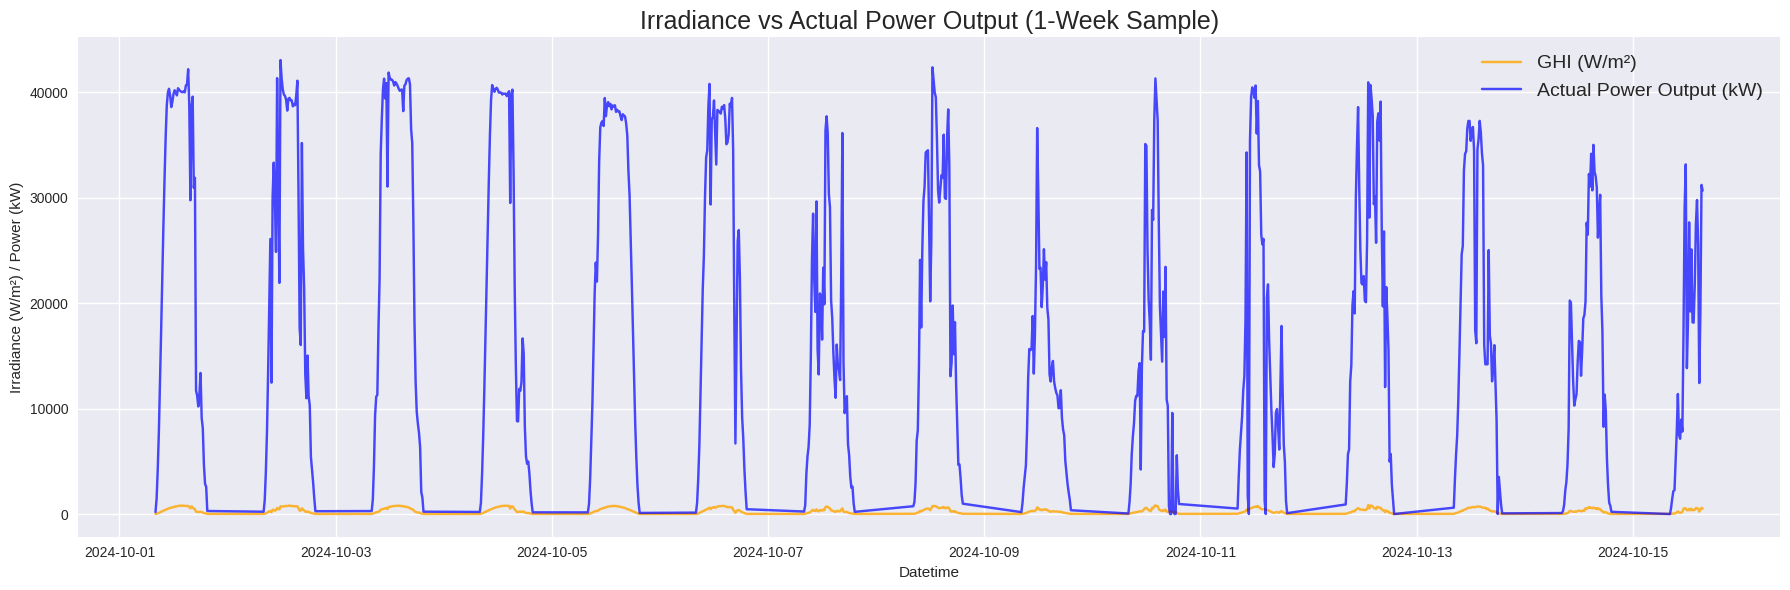

In [ ]:
import matplotlib.pyplot as plt

# Select a time window (e.g., one week)
sample_days = 7 * 24 * 4  # 7 days * 24 hours * 4 (15-min intervals)
start_idx = 0  # Or choose an index for a specific week
end_idx = start_idx + sample_days

# Use your datetime column as index if not already
if 'datetime' in day_df.columns:
    day_df = day_df.set_index('datetime')

# Select main irradiance and power columns (adjust as needed)
irr_col = 'meteorolgicas_em_03_02_ghi'      # Global Horizontal Irradiance
power_col = 'ppc_p_tot'                     # Total Actual Power Output

# Slice time window
df_slice = day_df.iloc[start_idx:end_idx]

plt.figure(figsize=(18,6))
plt.plot(df_slice.index, df_slice[irr_col], label='GHI (W/m²)', color='orange', alpha=0.8)
plt.plot(df_slice.index, df_slice[power_col]*1000, label='Actual Power Output (kW)', color='blue', alpha=0.7)  # Scale MW to kW for comparable y-axis
plt.legend(fontsize=14)
plt.title('Irradiance vs Actual Power Output (1-Week Sample)', fontsize=18)
plt.xlabel('Datetime')
plt.ylabel('Irradiance (W/m²) / Power (kW)')
plt.grid(True)
plt.tight_layout()
plt.show()


### Irradiance vs actual power time series

Plots a one-week time series of global horizontal irradiance (GHI) and actual power output to analyze their temporal relationship.


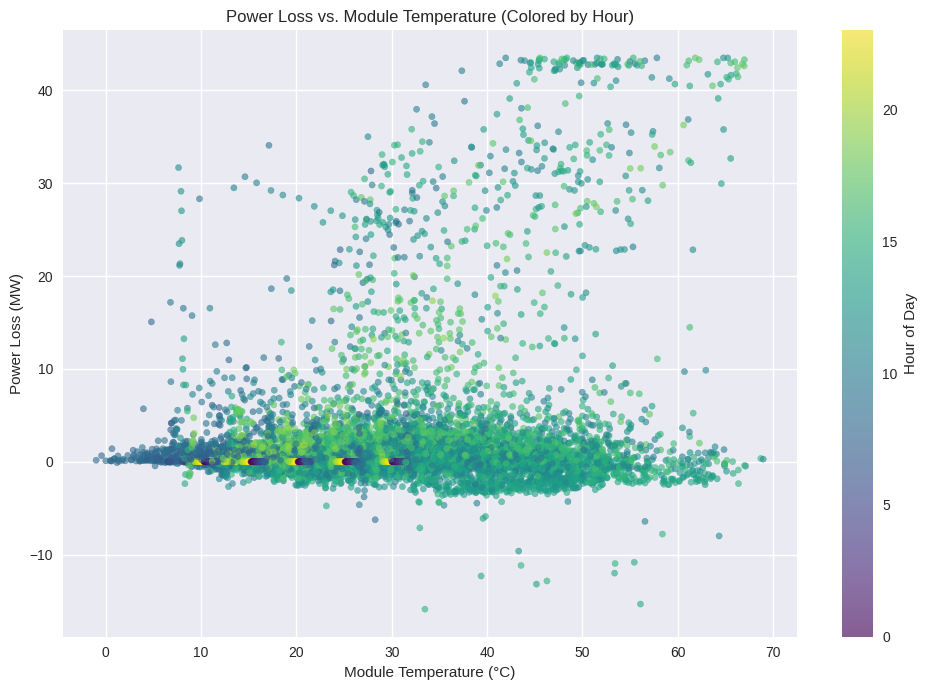

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume day_df index is datetime; if not, set it:
if not isinstance(day_df.index, pd.DatetimeIndex):
    day_df = day_df.set_index('datetime')

# Define columns (adjust if needed)
temp_col = 'celulas_ctin03_cc_03_1_t_mod'       # Module temperature (choose any available)
power_col = 'ppc_p_tot'                         # Actual output (MW)
theo_col = 'ttr_potenciaproducible'             # Theoretical output (MW)

# Compute power loss (theoretical - actual)
day_df['power_loss'] = day_df[theo_col] - day_df[power_col]

# Extract hour for color-coding
day_df['hour'] = day_df.index.hour

# Plot
plt.figure(figsize=(10,7))
sc = plt.scatter(day_df[temp_col], day_df['power_loss'], c=day_df['hour'], cmap='viridis', alpha=0.6, s=20)
plt.colorbar(sc, label='Hour of Day')
plt.xlabel('Module Temperature (°C)')
plt.ylabel('Power Loss (MW)')
plt.title('Power Loss vs. Module Temperature (Colored by Hour)')
plt.grid(True)
plt.tight_layout()
plt.show()


### Power loss vs module temperature

Creates a scatter plot of power loss (theoretical minus actual) against module temperature, with points color-coded by hour of the day to explore diurnal patterns.


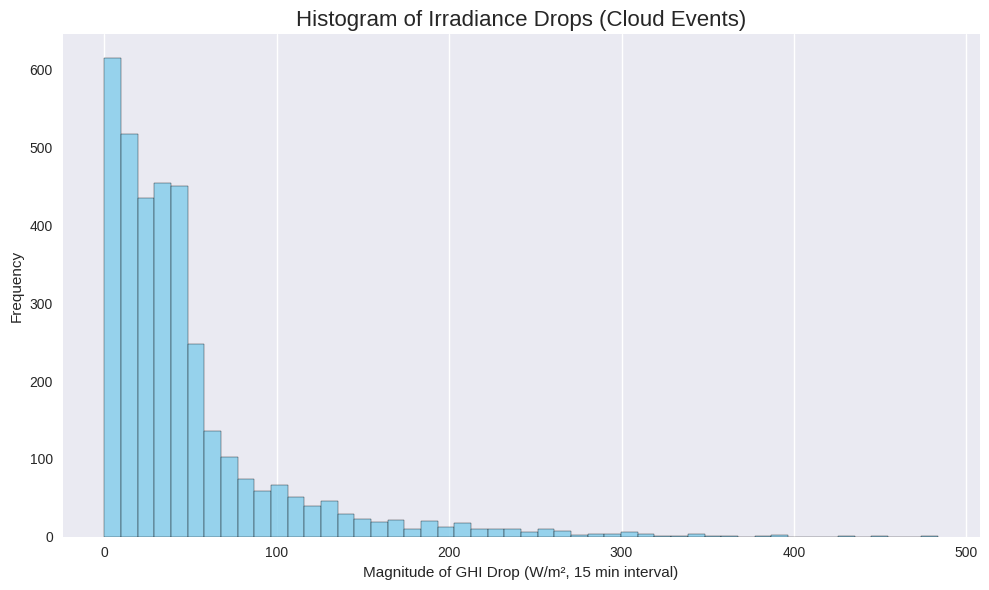

count    3532.000000
mean      -47.704629
std        53.773332
min      -483.520909
25%       -54.585476
50%       -33.687382
75%       -14.412963
max        -0.001208
Name: irradiance_drop, dtype: float64


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Pick your main irradiance column (GHI)
irr_col = 'meteorolgicas_em_03_02_ghi'

# Compute the difference (drop) between consecutive time intervals
day_df['irradiance_drop'] = day_df[irr_col].diff()

# Histogram of all negative drops (i.e., rapid decreases due to clouds)
drops = day_df['irradiance_drop']
cloud_drops = drops[drops < 0]

plt.figure(figsize=(10,6))
plt.hist(np.abs(cloud_drops), bins=50, color='skyblue', edgecolor='k', alpha=0.85)
plt.title('Histogram of Irradiance Drops (Cloud Events)', fontsize=16)
plt.xlabel('Magnitude of GHI Drop (W/m², 15 min interval)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Optional: Print summary stats
print(cloud_drops.describe())



### Cloud event analysis

Calculates and plots the histogram of negative irradiance drops between time intervals to identify and quantify rapid decreases due to cloud cover.


<Figure size 800x600 with 0 Axes>

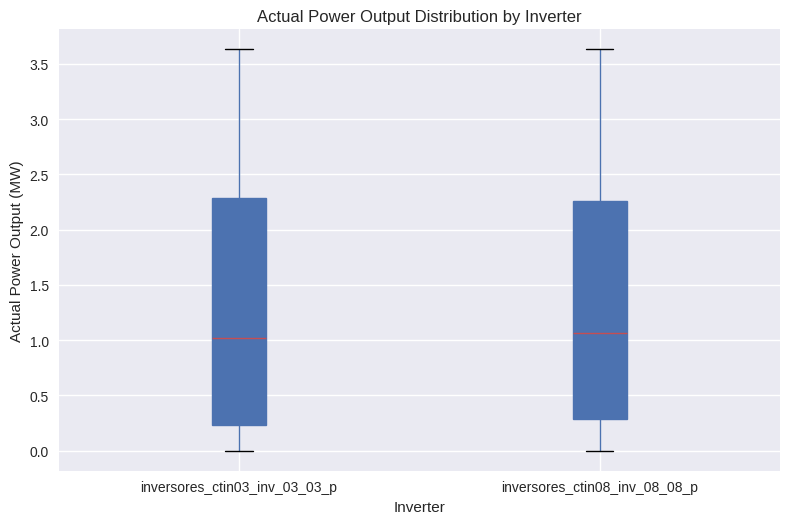

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Select your inverter power output columns
inverter_cols = ['inversores_ctin08_inv_08_08_p', 'inversores_ctin03_inv_03_03_p']

# Melt to long format: columns become one "INVERTER" column, values in one "power" column
melted = day_df[inverter_cols].melt(var_name='INVERTER', value_name='power_output')

# Boxplot
plt.figure(figsize=(8,6))
melted.boxplot(by='INVERTER', column='power_output', grid=True, showfliers=True, patch_artist=True)
plt.title('Actual Power Output Distribution by Inverter')
plt.suptitle('')
plt.xlabel('Inverter')
plt.ylabel('Actual Power Output (MW)')
plt.tight_layout()
plt.show()


### Power output distribution by inverter

Creates a boxplot to visualize the distribution of actual power output for each inverter.


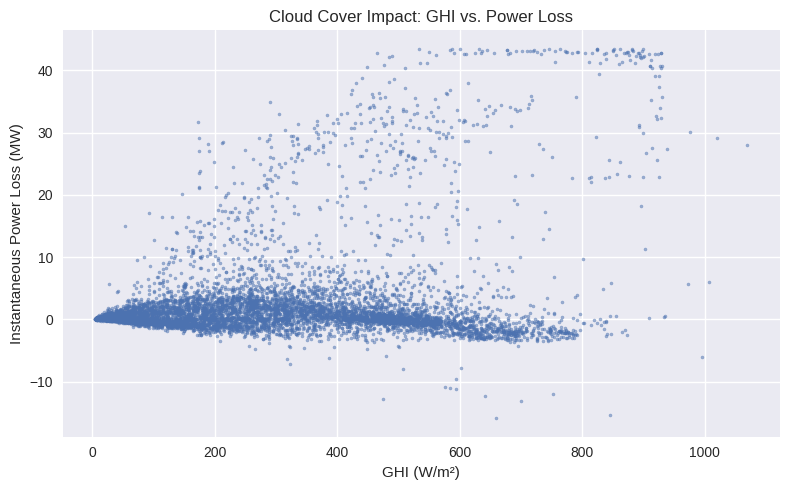

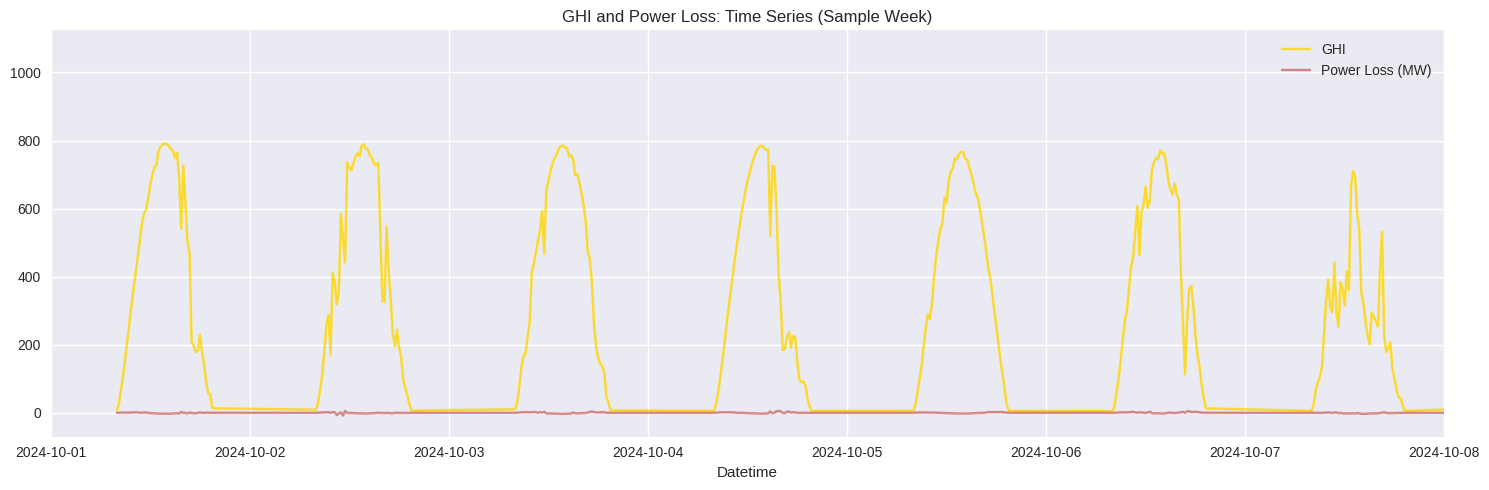

In [ ]:
# Scatter: GHI vs instantaneous loss
plt.figure(figsize=(8,5))
plt.scatter(day_df['meteorolgicas_em_03_02_ghi'], day_df['power_loss'], s=5, alpha=0.5)
plt.xlabel('GHI (W/m²)')
plt.ylabel('Instantaneous Power Loss (MW)')
plt.title('Cloud Cover Impact: GHI vs. Power Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

# Time series overlay for a cloudy and clear week
plt.figure(figsize=(15,5))
plt.plot(day_df.index, day_df['meteorolgicas_em_03_02_ghi'], label='GHI', color='gold', alpha=0.8)
plt.plot(day_df.index, day_df['power_loss'], label='Power Loss (MW)', color='firebrick', alpha=0.5)
plt.legend()
plt.xlim(pd.Timestamp('2024-10-01'), pd.Timestamp('2024-10-08'))  # adjust to a cloudy/clear week
plt.title('GHI and Power Loss: Time Series (Sample Week)')
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()


### Cloud cover impact analysis

Generates a scatter plot of GHI versus instantaneous power loss and overlays GHI and power loss time series for a selected week to visualize cloud-related loss patterns.


<Figure size 1000x500 with 0 Axes>

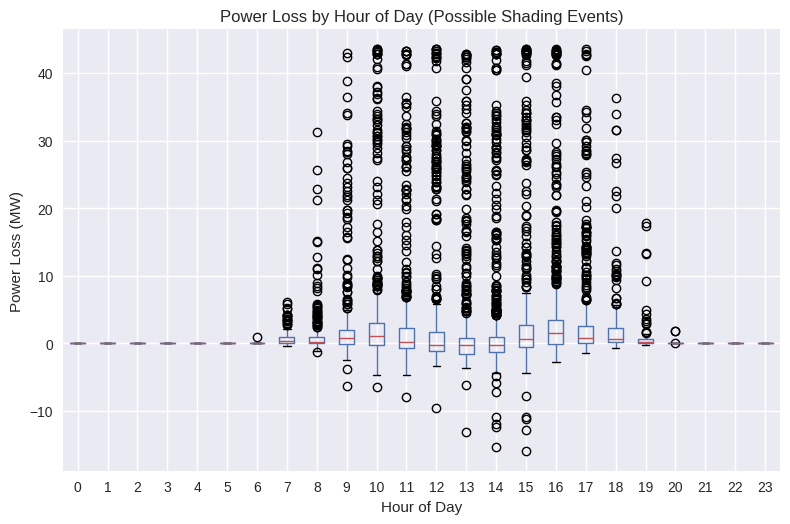

In [ ]:
# Hourly boxplot to spot shading events (spikes at morning/evening? outliers?)
day_df['hour'] = day_df.index.hour
plt.figure(figsize=(10,5))
day_df.boxplot(column='power_loss', by='hour', grid=True, showfliers=True)
plt.title('Power Loss by Hour of Day (Possible Shading Events)')
plt.suptitle('')
plt.xlabel('Hour of Day')
plt.ylabel('Power Loss (MW)')
plt.tight_layout()
plt.show()


### Hourly power loss boxplot

Creates a boxplot of power loss by hour of day to identify potential shading events or outliers at specific times.


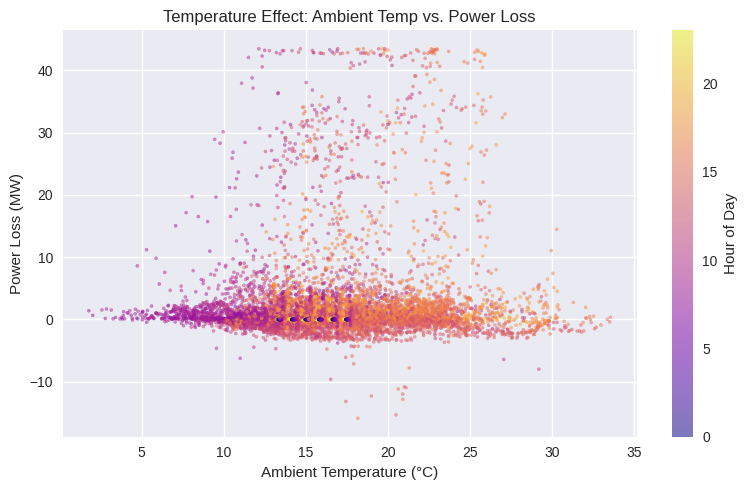

In [ ]:
# Already done for module temp; add ambient temp for completeness
plt.figure(figsize=(8,5))
plt.scatter(day_df['meteorolgicas_em_03_02_t_amb'], day_df['power_loss'], s=5, alpha=0.5, c=day_df['hour'], cmap='plasma')
plt.colorbar(label='Hour of Day')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('Power Loss (MW)')
plt.title('Temperature Effect: Ambient Temp vs. Power Loss')
plt.grid(True)
plt.tight_layout()
plt.show()


### Ambient temperature vs power loss

Plots a scatter of ambient temperature against power loss, color-coded by hour of day, to explore temperature-related loss patterns.


In [ ]:
# Choose your clean and dirty reference cell columns:
clean_col = 'celulas_ctin03_cc_03_1_ir_cel_1'   # Clean reference cell
dirty_col = 'celulas_ctin03_cc_03_2_ir_cel_1'   # Dirty reference cell

# Calculate soiling index and loss
day_df['soiling_index'] = day_df[dirty_col] / day_df[clean_col]
day_df['soiling_index'] = day_df['soiling_index'].clip(lower=0, upper=1.2)
day_df['soiling_loss_pct'] = (1 - day_df['soiling_index']) * 100


### Simple soiling index calculation

Computes the soiling index as the ratio of dirty to clean reference cell irradiance and derives the soiling loss percentage.


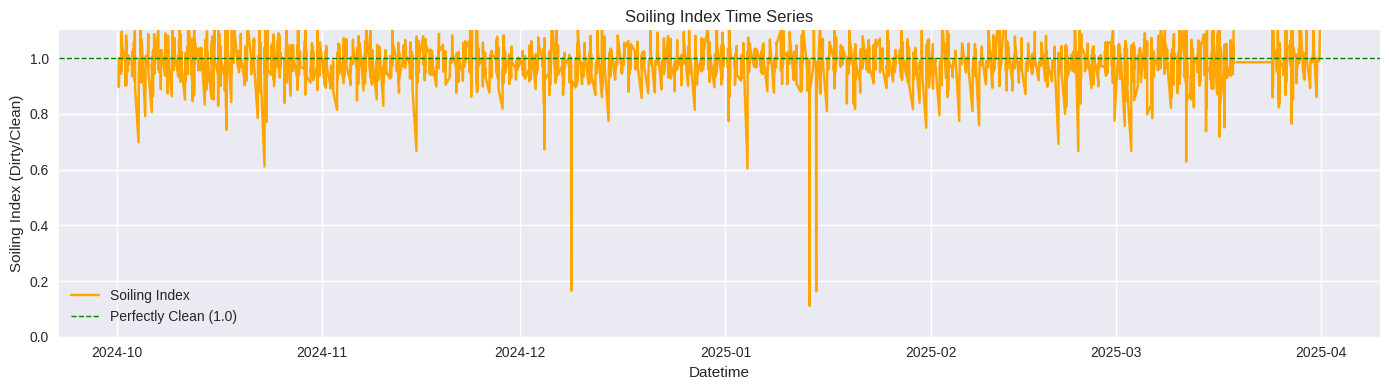

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(day_df.index, day_df['soiling_index'], color='orange', label='Soiling Index')
plt.axhline(1.0, color='green', linestyle='--', lw=1, label='Perfectly Clean (1.0)')
plt.ylabel('Soiling Index (Dirty/Clean)')
plt.xlabel('Datetime')
plt.title('Soiling Index Time Series')
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.show()


### Soiling index time series

Plots the soiling index over time with a reference line for a perfectly clean state (1.0) to visualize soiling trends.


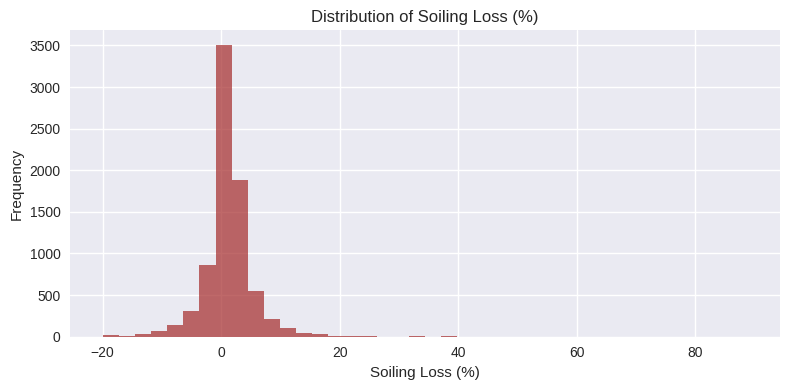

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(day_df['soiling_loss_pct'].dropna(), bins=40, color='brown', alpha=0.7)
plt.xlabel('Soiling Loss (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Soiling Loss (%)')
plt.tight_layout()
plt.show()


### Soiling loss distribution

Creates a histogram to show the distribution of soiling loss percentage across the dataset.


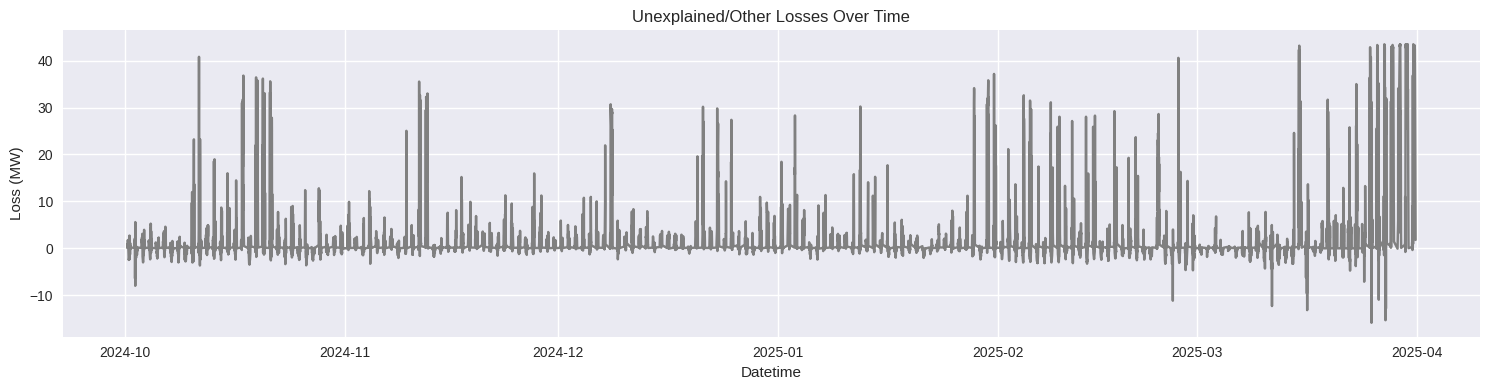

In [ ]:
# Assuming you have a modeled loss for each class, other = total loss - sum(class losses)
# Here, just plot residuals if available:
plt.figure(figsize=(15,4))
plt.plot(day_df.index, day_df['power_loss'], color='gray', label='Total Loss')
plt.title('Unexplained/Other Losses Over Time')
plt.ylabel('Loss (MW)')
plt.xlabel('Datetime')
plt.tight_layout()
plt.show()


### Unexplained loss time series

Plots total power loss over time to visualize residual or unexplained losses not attributed to specific classes.


In [ ]:
day_df['power_loss'] = day_df['ttr_potenciaproducible'] - day_df['ppc_p_tot']

# Normalize irradiance drop to power scale for the largest events (heuristic approach)
cloud_mask = (day_df['irradiance_drop'] < -50)  # threshold for significant GHI drop, adjust as needed
day_df['cloud_loss'] = 0.0
day_df.loc[cloud_mask, 'cloud_loss'] = day_df.loc[cloud_mask, 'power_loss']

# Use soiling_loss_pct and theoretical power to estimate loss
day_df['soiling_loss'] = (day_df['soiling_loss_pct'] / 100.0) * day_df['ttr_potenciaproducible']
# NaN to zero for safety (no soiling measurement at night)
day_df['soiling_loss'] = day_df['soiling_loss'].fillna(0)

temp_col = 'celulas_ctin03_cc_03_1_t_mod'  # Pick a representative module temperature column
pv_temp_coeff = -0.004  # Per degree Celsius

# Calculate temperature difference from reference
temp_diff = (day_df[temp_col] - 25).clip(lower=0)  # Only count temps above 25°C
day_df['temperature_loss'] = day_df['ttr_potenciaproducible'] * pv_temp_coeff * temp_diff
# Convert loss to positive values (since temp coeff is negative)
day_df['temperature_loss'] = day_df['temperature_loss'].abs()
day_df['temperature_loss'] = day_df['temperature_loss'].fillna(0)

# Proxy: high loss in early morning or late evening, not explained by cloud
shading_mask = ((day_df['hour'] < 9) | (day_df['hour'] > 17)) & (day_df['power_loss'] > 0)
day_df['shading_loss'] = 0.0
day_df.loc[shading_mask, 'shading_loss'] = day_df.loc[shading_mask, 'power_loss']

# Calculate residual (other/unexplained) loss
explained_loss = (
    day_df['cloud_loss'] +
    day_df['soiling_loss'] +
    day_df['temperature_loss'] +
    day_df['shading_loss']
)
# "Other" is whatever remains, but not less than zero
day_df['other_loss'] = (day_df['power_loss'] - explained_loss).clip(lower=0)


### Loss attribution by category

Estimates power losses due to clouds, soiling, temperature effects, and shading based on heuristics and calculations. Computes residual unexplained losses as the difference between total and attributed losses.


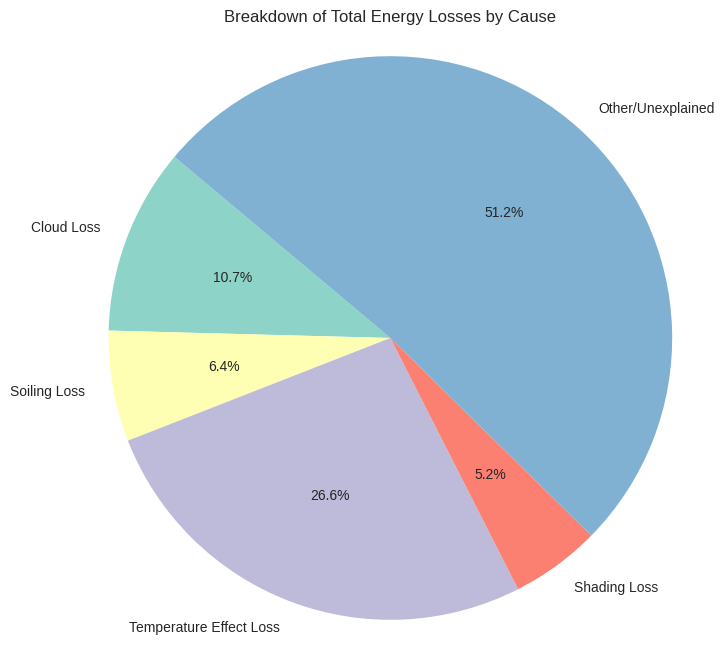

In [ ]:
import matplotlib.pyplot as plt

# Sum each class of loss
loss_breakdown = {
    'Cloud Loss': day_df['cloud_loss'].sum(),
    'Soiling Loss': day_df['soiling_loss'].sum(),
    'Temperature Effect Loss': day_df['temperature_loss'].sum(),
    'Shading Loss': day_df['shading_loss'].sum(),
    'Other/Unexplained': day_df['other_loss'].sum()
}

# Remove any class with zero loss (optional, but makes pie chart neater)
loss_breakdown = {k: v for k, v in loss_breakdown.items() if v > 0}

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    loss_breakdown.values(),
    labels=loss_breakdown.keys(),
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors
)
plt.title('Breakdown of Total Energy Losses by Cause')
plt.axis('equal')
plt.show()


### Energy loss breakdown visualization

Generates a pie chart showing the proportional contribution of cloud, soiling, temperature, shading, and unexplained losses to total energy loss.


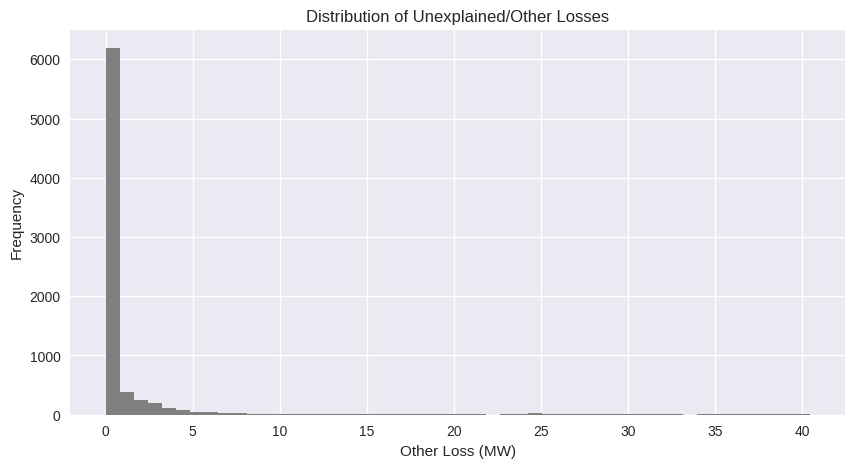

<Figure size 1000x500 with 0 Axes>

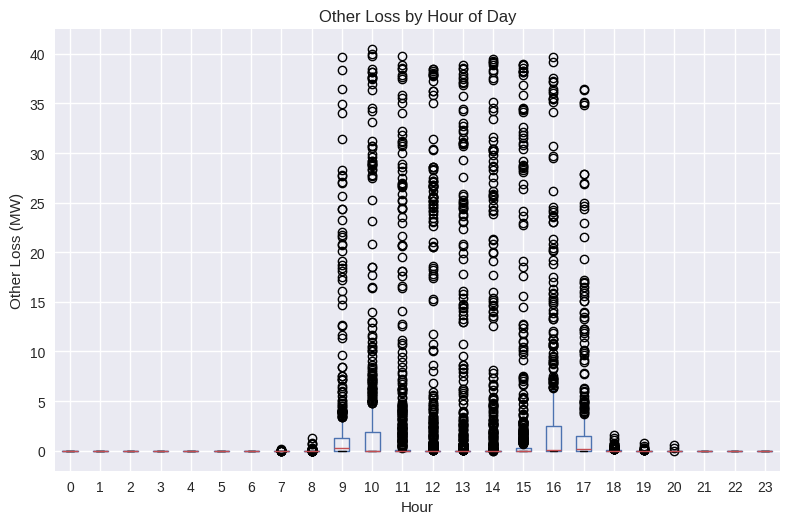

In [ ]:
# If not done already
# day_df['other_loss'] = day_df['power_loss'] - (
#     day_df['cloud_loss'] + day_df['shading_loss'] + day_df['temperature_loss'] + day_df['soiling_loss']
# )

import matplotlib.pyplot as plt

# Histogram of Other Losses
plt.figure(figsize=(10,5))
day_df['other_loss'].hist(bins=50, color='grey')
plt.title("Distribution of Unexplained/Other Losses")
plt.xlabel("Other Loss (MW)")
plt.ylabel("Frequency")
plt.show()

# Boxplot by hour
plt.figure(figsize=(10,5))
day_df.boxplot(column='other_loss', by='hour', showfliers=True)
plt.title("Other Loss by Hour of Day")
plt.suptitle("")
plt.xlabel("Hour")
plt.ylabel("Other Loss (MW)")
plt.tight_layout()
plt.show()

# (Optional) If you have inverter IDs or tracker mode:
# day_df.boxplot(column='other_loss', by='INVERTER')
# day_df.boxplot(column='other_loss', by='tracker_mode')


### Unexplained loss distribution and patterns

Plots the distribution of unexplained (other) losses as a histogram and as a boxplot by hour of day to identify temporal patterns in residual losses.


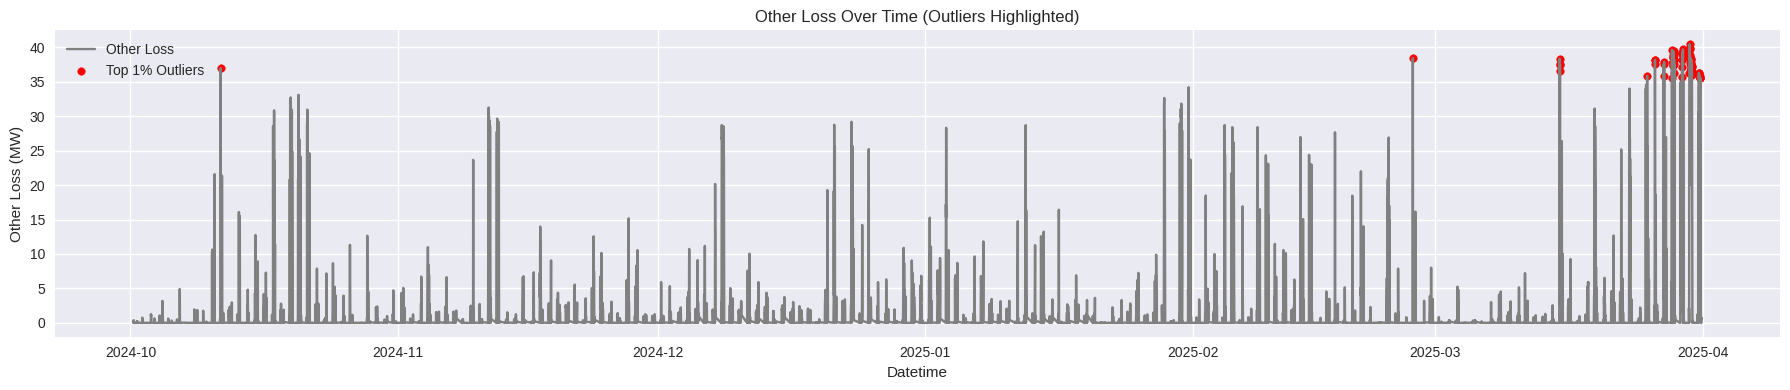

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Identify outliers (e.g., above 99th percentile)
threshold = day_df['other_loss'].quantile(0.99)
outlier_times = day_df.index[day_df['other_loss'] > threshold]
outlier_values = day_df['other_loss'][day_df['other_loss'] > threshold]

plt.figure(figsize=(18,4))
plt.plot(day_df.index, day_df['other_loss'], color='gray', label='Other Loss')
plt.scatter(outlier_times, outlier_values, color='red', s=30, label='Top 1% Outliers')
plt.title("Other Loss Over Time (Outliers Highlighted)")
plt.xlabel('Datetime')
plt.ylabel('Other Loss (MW)')
plt.legend()
plt.tight_layout()
plt.show()


### Other loss outlier detection

Plots other (unexplained) losses over time and highlights values above the 99th percentile as potential outliers.


In [ ]:
# 1. Calculate the sum of all explained losses
explained_loss = (
    day_df['cloud_loss'].fillna(0) +
    day_df['soiling_loss'].fillna(0) +
    day_df['temperature_loss'].fillna(0) +
    day_df['shading_loss'].fillna(0)
)

# 2. Calculate 'other_loss' as the residual, but clip at zero to avoid negative values
day_df['other_loss'] = (day_df['power_loss'] - explained_loss).clip(lower=0)

# (Optional) Quickly check how many zeros (means fully explained) and nonzero "other" loss values
print("Rows with 'other_loss' > 0:", (day_df['other_loss'] > 0).sum())
print("Rows with 'other_loss' == 0:", (day_df['other_loss'] == 0).sum())

# (Optional) Display summary statistics
print(day_df['other_loss'].describe())


Rows with 'other_loss' > 0: 2710
Rows with 'other_loss' == 0: 5134
count    7844.000000
mean        1.939693
std         6.244664
min         0.000000
25%         0.000000
50%         0.000000
75%         0.370506
max        40.447609
Name: other_loss, dtype: float64


### Final other loss calculation

Computes the residual unexplained loss as the difference between total power loss and the sum of explained losses (cloud, soiling, temperature, shading), clips negatives to zero, and summarizes the results.


 STEP 1: ENHANCED LOSS FLAGGING AND DOCUMENTATION 
Creating boolean flags for each loss type...
Loss Classification Logic:
  • Cloud Loss: Identified by rapid GHI drops >50 W/m² within 15-minute intervals
  • Soiling Loss: Calculated from dirty/clean reference cell ratio when soiling index <0.95
  • Temperature Loss: Temperature coefficient losses when module temp >35°C
  • Shading Loss: Losses occurring during early morning (≤9 AM) or late evening (≥5 PM)
  • Other Loss: Unexplained losses above 0.37 MW (75th percentile)

Loss Flag Summary:
  • is_cloud_loss: 681 occurrences (8.7% of data)
  • is_soiling_loss: 819 occurrences (10.4% of data)
  • is_temperature_loss: 2,815 occurrences (35.9% of data)
  • is_shading_loss: 949 occurrences (12.1% of data)
  • is_other_loss: 1,961 occurrences (25.0% of data)

 STEP 2: TEMPORAL ANALYSIS OF LOSS PATTERNS 
Generating hourly loss patterns...


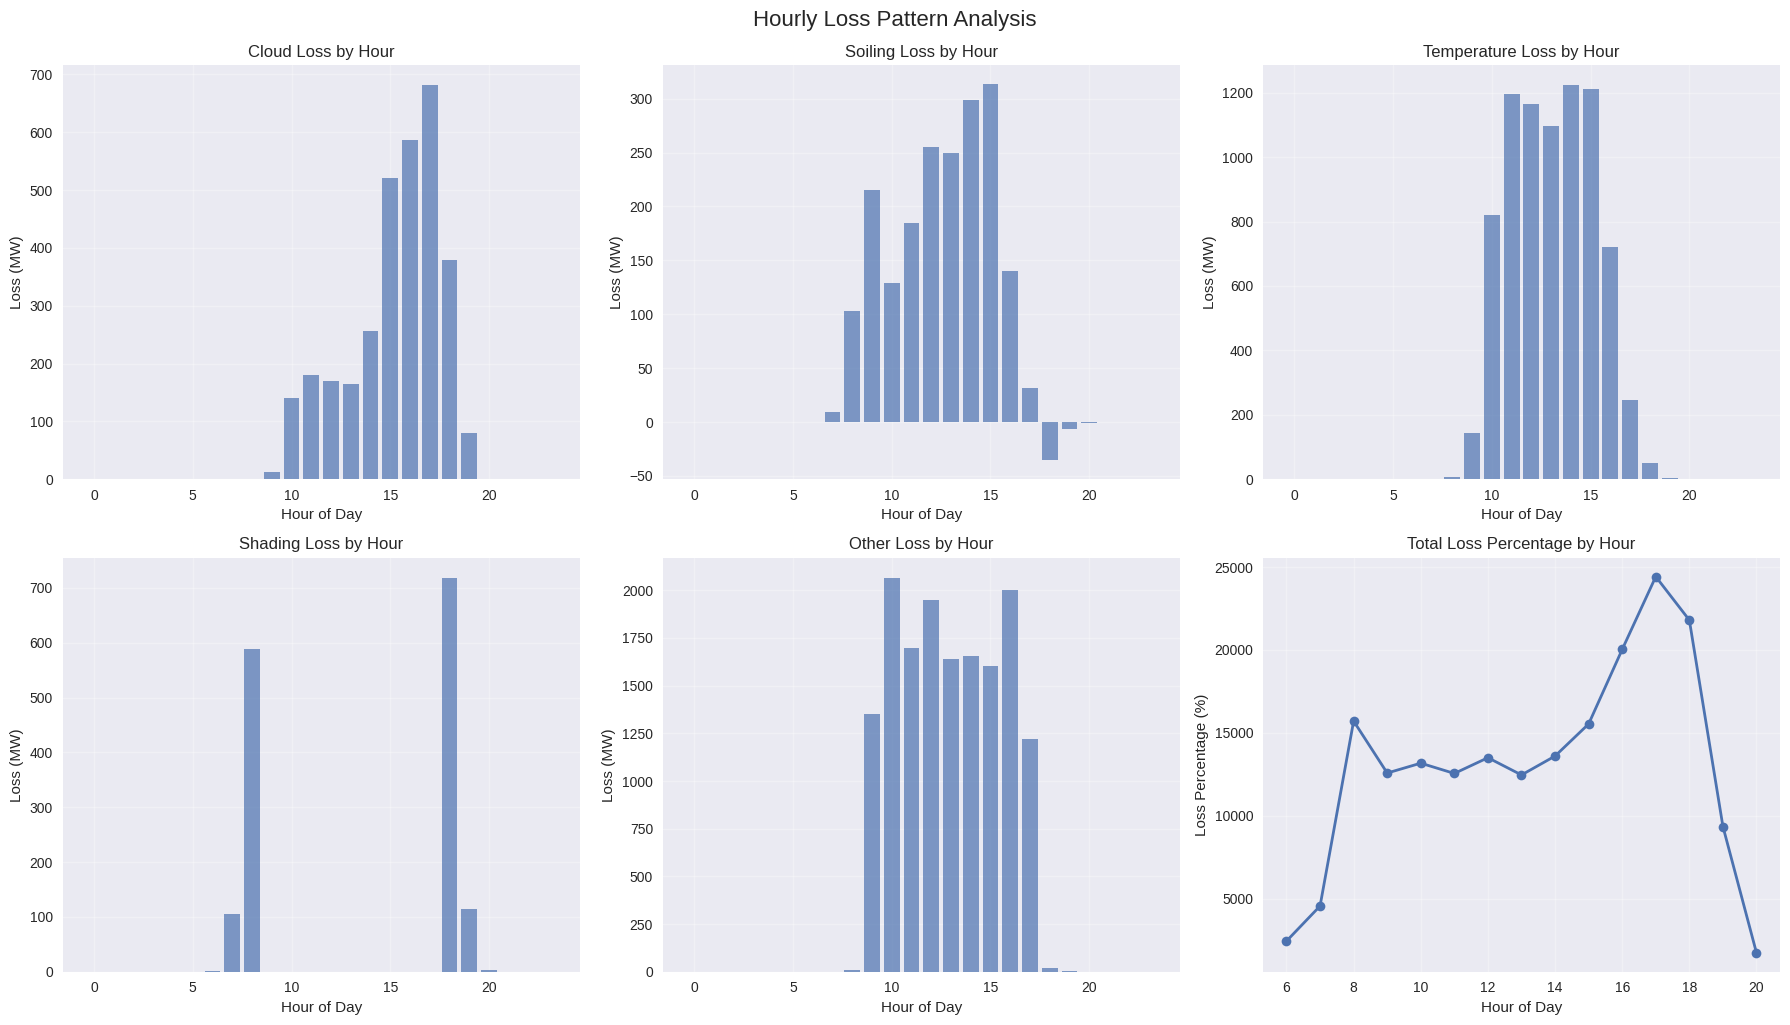

Generating daily loss aggregations...


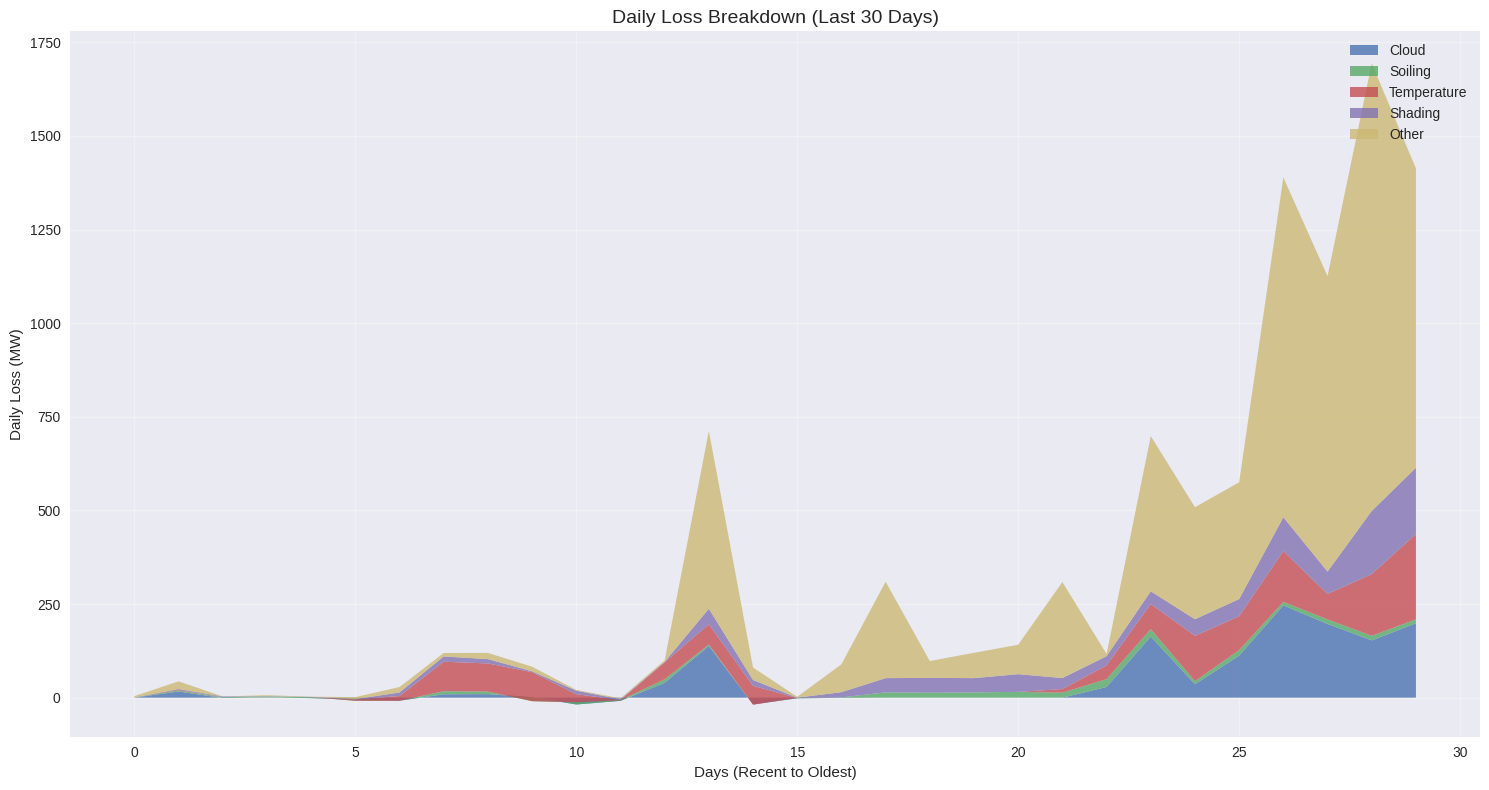

<Figure size 1200x600 with 0 Axes>

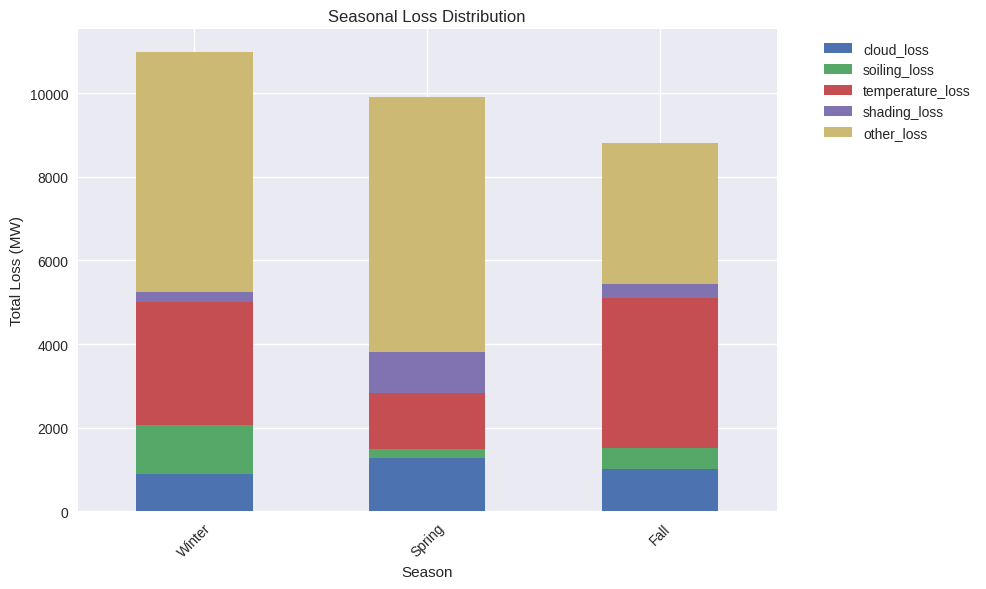


 STEP 3: ASSET PERFORMANCE ANALYSIS 
Inverter Performance Ranking:
     inverter  avg_power_output  capacity_factor  total_allocated_loss  \
0  CTIN08_INV              1.30            35.82                   inf   
1  CTIN03_INV              1.27            35.01                   inf   

   performance_score  
0               -inf  
1               -inf  

String Performance Analysis:
  string_group  avg_current  max_current  std_current  availability  \
0      CT03_S8         7.44        22.88         6.42         97.25   
1     CT03_S10         7.54        22.79         6.37         95.17   
2      CT08_S9         7.75        22.93         6.47         95.87   
3     CT08_S12         8.02        23.62         6.51        100.00   

   performance_variability  performance_rank  
0                    86.24               4.0  
1                    84.51               3.0  
2                    83.40               2.0  
3                    81.19               1.0  

 STEP 4: ADVANCED 

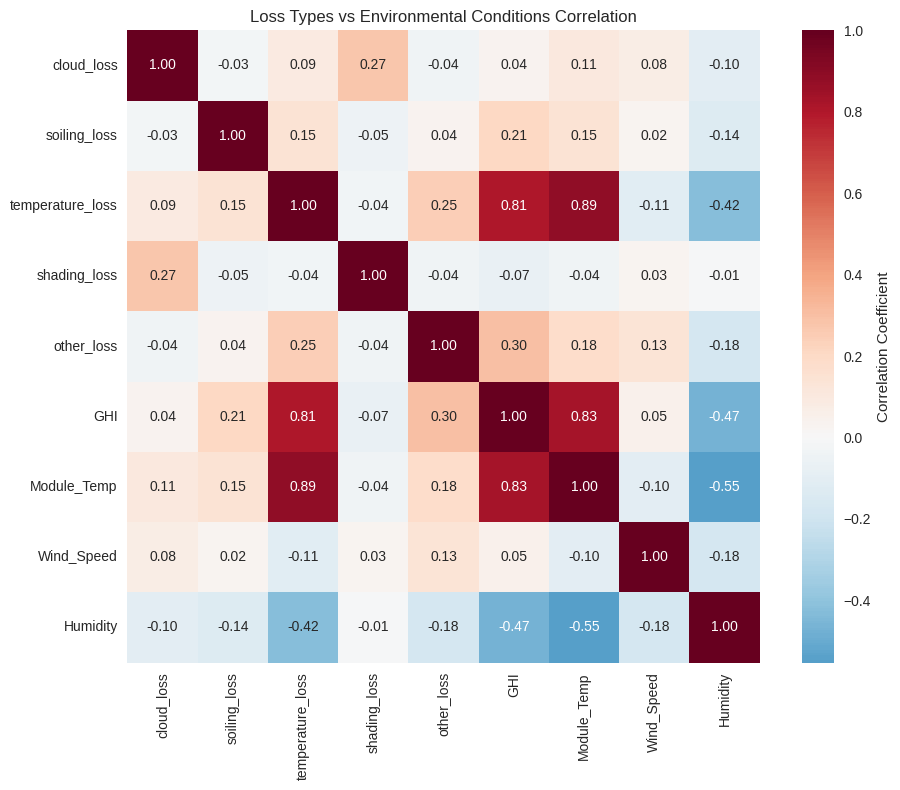

Analyzing high-loss events...
High-loss events (>19.26 MW): 393 occurrences
Dominant loss types in high-loss events:
dominant_loss_type
Other      336
Cloud       53
Shading      4
Name: count, dtype: int64


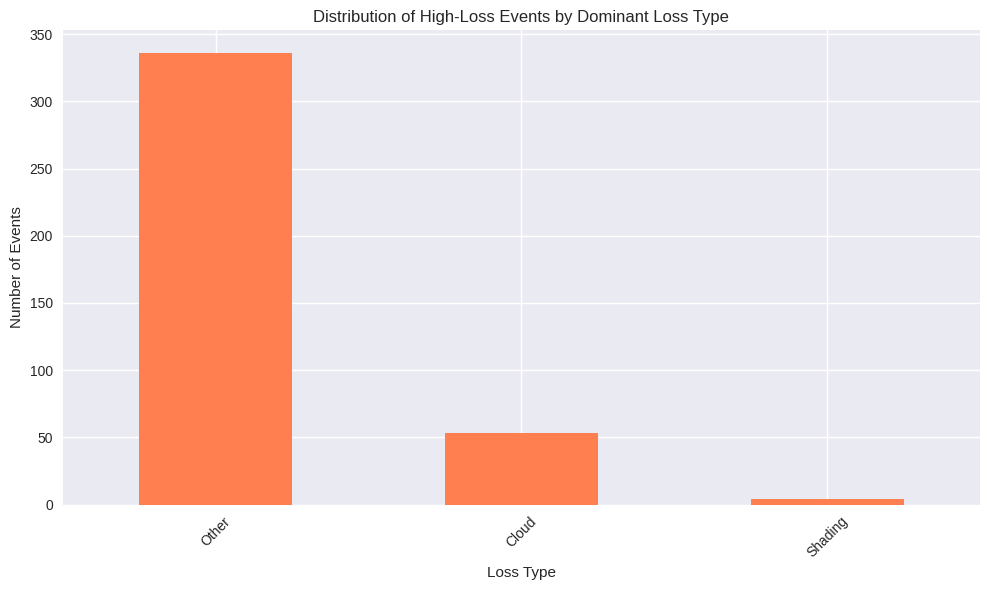


 STEP 5: COMPREHENSIVE DELIVERABLES TABLE 
Deliverables DataFrame created with 7844 rows and 24 columns

Columns included:
  • datetime
  • hour
  • date
  • month
  • season
  • ppc_p_tot
  • ttr_potenciaproducible
  • power_loss
  • cloud_loss
  • soiling_loss
  • temperature_loss
  • shading_loss
  • other_loss
  • is_cloud_loss
  • is_soiling_loss
  • is_temperature_loss
  • is_shading_loss
  • is_other_loss
  • meteorolgicas_em_03_02_ghi
  • celulas_ctin03_cc_03_1_t_mod
  • soiling_index
  • loss_percentage
  • performance_ratio
  • loss_severity

 FINAL SUMMARY STATISTICS 
Dataset Period: 2024-10-01 08:00:00 to 2025-03-31 20:00:00
Total Data Points: 7,844
Overall Performance Summary:
  • Total Theoretical Energy: 142,431 MWh
  • Total Actual Energy: 122,171 MWh
  • Total Energy Loss: 20,261 MWh (14.22%)

Loss Breakdown:
  • Cloud Loss: 3174.6 MWh (15.7%)
  • Soiling Loss: 1886.8 MWh (9.3%)
  • Temperature Loss: 7884.1 MWh (38.9%)
  • Shading Loss: 1530.6 MWh (7.6%)
  • Other Los

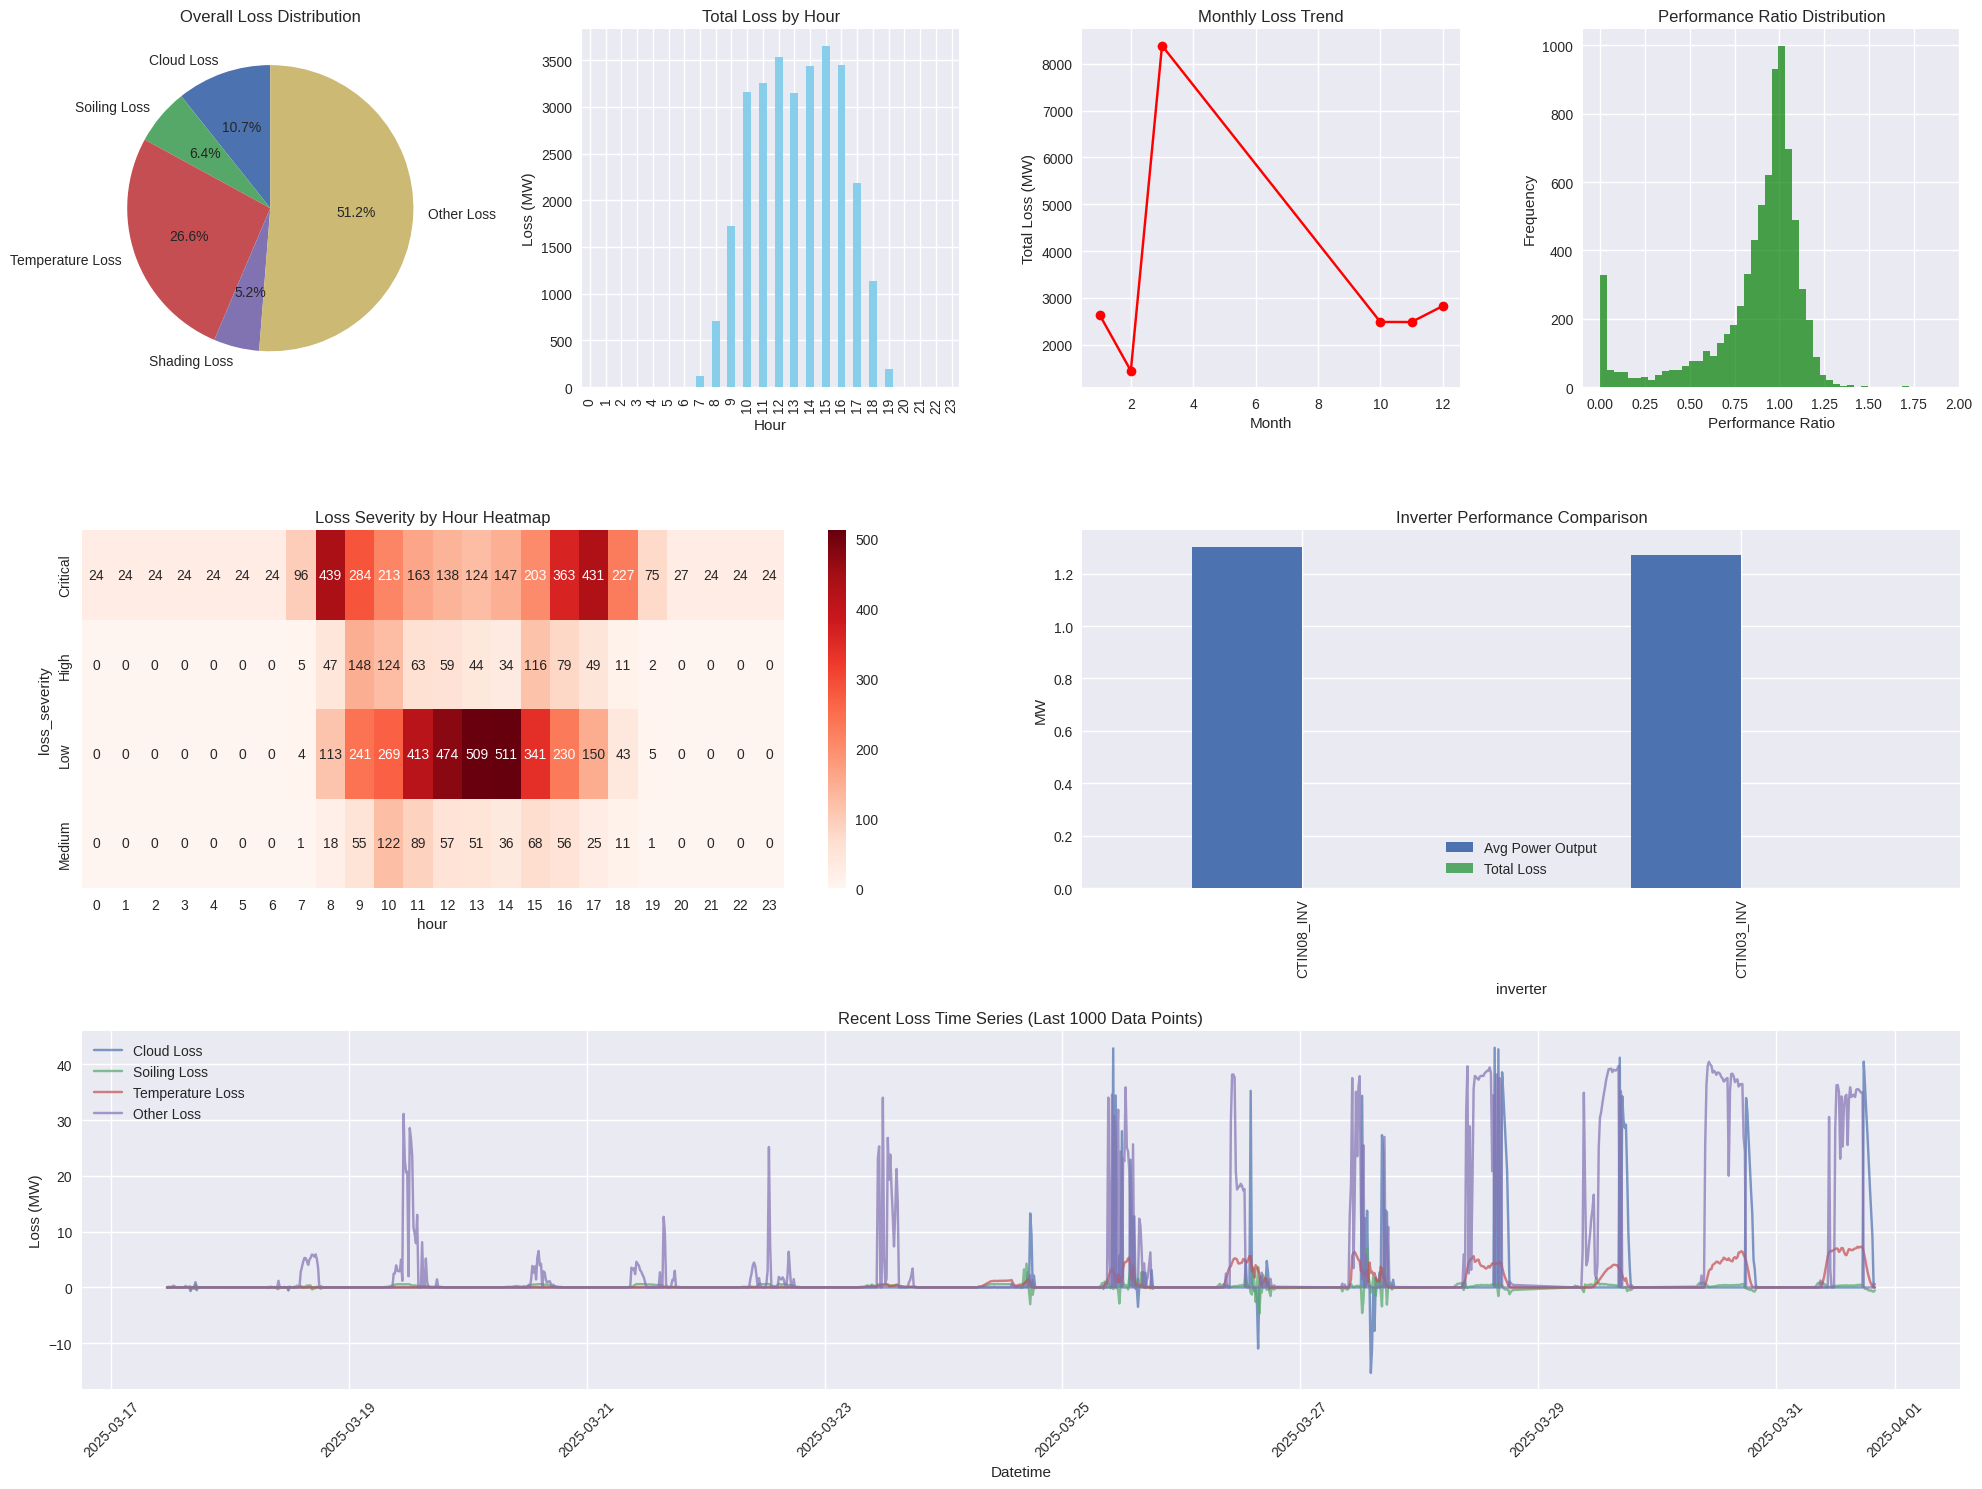

✓ Final dashboard saved as: solar_loss_analysis_dashboard.png

COMPREHENSIVE SOLAR LOSS ANALYSIS COMPLETE!
 Analysis Period: 2024-10-01 08:00:00 to 2025-03-31 20:00:00
 Total Data Points: 7,844
 Overall Loss Rate: 14.22%
 Best Performing Asset: CTIN08_INV
 Files Generated: 7 CSV files + 1 dashboard PNG


In [ ]:
# ===================================================================
# COMPREHENSIVE SOLAR LOSS ANALYSIS - EDA EXTENSION
# Building upon your existing code to address all analytical gaps
# ===================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print(" STEP 1: ENHANCED LOSS FLAGGING AND DOCUMENTATION ")

# 1.1 Define Boolean Loss Flags with Clear Logic
print("Creating boolean flags for each loss type...")

# Cloud Loss Flag: Significant irradiance drops (>50 W/m² in 15 minutes)
day_df['is_cloud_loss'] = (day_df['irradiance_drop'] < -50) & (day_df['cloud_loss'] > 0)

# Soiling Loss Flag: When soiling index indicates dirt accumulation
day_df['is_soiling_loss'] = (day_df['soiling_loss'] > 0) & (day_df['soiling_index'] < 0.95)

# Temperature Loss Flag: When module temperature > 35°C and causing losses
temp_threshold = 35
day_df['is_temperature_loss'] = (day_df['celulas_ctin03_cc_03_1_t_mod'] > temp_threshold) & (day_df['temperature_loss'] > 0)

# Shading Loss Flag: Early morning (6-9 AM) or late evening (5-7 PM) losses
day_df['is_shading_loss'] = ((day_df['hour'] <= 9) | (day_df['hour'] >= 17)) & (day_df['shading_loss'] > 0)

# Other Loss Flag: Unexplained losses above threshold
other_loss_threshold = day_df['other_loss'].quantile(0.75)  # Top 25%
day_df['is_other_loss'] = day_df['other_loss'] > other_loss_threshold

# 1.2 Loss Logic Documentation
loss_logic_doc = {
    'Cloud Loss': 'Identified by rapid GHI drops >50 W/m² within 15-minute intervals',
    'Soiling Loss': 'Calculated from dirty/clean reference cell ratio when soiling index <0.95',
    'Temperature Loss': f'Temperature coefficient losses when module temp >{temp_threshold}°C',
    'Shading Loss': 'Losses occurring during early morning (≤9 AM) or late evening (≥5 PM)',
    'Other Loss': f'Unexplained losses above {other_loss_threshold:.2f} MW (75th percentile)'
}

print("Loss Classification Logic:")
for loss_type, explanation in loss_logic_doc.items():
    print(f"  • {loss_type}: {explanation}")

print(f"\nLoss Flag Summary:")
for flag in ['is_cloud_loss', 'is_soiling_loss', 'is_temperature_loss', 'is_shading_loss', 'is_other_loss']:
    count = day_df[flag].sum()
    percentage = (count / len(day_df)) * 100
    print(f"  • {flag}: {count:,} occurrences ({percentage:.1f}% of data)")

print("\n STEP 2: TEMPORAL ANALYSIS OF LOSS PATTERNS ")

# 2.1 Create temporal aggregation functions
def create_temporal_summary(df, time_grouper, loss_cols):
    """Create temporal summary of losses"""
    summary = df.groupby(time_grouper).agg({
        **{col: 'sum' for col in loss_cols},
        'ppc_p_tot': 'mean',
        'ttr_potenciaproducible': 'mean'
    }).round(3)

    # Add total loss and loss percentage
    summary['total_loss'] = summary[loss_cols].sum(axis=1)
    summary['loss_percentage'] = (summary['total_loss'] / summary['ttr_potenciaproducible'] * 100).round(2)

    return summary

# Define loss columns
loss_columns = ['cloud_loss', 'soiling_loss', 'temperature_loss', 'shading_loss', 'other_loss']

# 2.2 Hourly Loss Analysis
print("Generating hourly loss patterns...")
hourly_losses = create_temporal_summary(day_df, day_df['hour'], loss_columns)

# Plot hourly loss patterns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, loss_type in enumerate(loss_columns):
    axes[i].bar(hourly_losses.index, hourly_losses[loss_type], alpha=0.7)
    axes[i].set_title(f'{loss_type.replace("_", " ").title()} by Hour')
    axes[i].set_xlabel('Hour of Day')
    axes[i].set_ylabel('Loss (MW)')
    axes[i].grid(True, alpha=0.3)

# Total loss percentage by hour
axes[5].plot(hourly_losses.index, hourly_losses['loss_percentage'], marker='o', linewidth=2)
axes[5].set_title('Total Loss Percentage by Hour')
axes[5].set_xlabel('Hour of Day')
axes[5].set_ylabel('Loss Percentage (%)')
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Hourly Loss Pattern Analysis', fontsize=16, y=1.02)
plt.show()

# 2.3 Daily Loss Analysis
print("Generating daily loss aggregations...")
day_df['date'] = day_df.index.date
daily_losses = create_temporal_summary(day_df, day_df['date'], loss_columns)

# Plot daily loss trends (last 30 days for clarity)
recent_daily = daily_losses.tail(30)
plt.figure(figsize=(15, 8))

# Stacked area plot
plt.stackplot(range(len(recent_daily)),
              recent_daily['cloud_loss'], recent_daily['soiling_loss'],
              recent_daily['temperature_loss'], recent_daily['shading_loss'],
              recent_daily['other_loss'],
              labels=['Cloud', 'Soiling', 'Temperature', 'Shading', 'Other'],
              alpha=0.8)

plt.title('Daily Loss Breakdown (Last 30 Days)', fontsize=14)
plt.xlabel('Days (Recent to Oldest)')
plt.ylabel('Daily Loss (MW)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2.4 Weekly and Seasonal Analysis
day_df['week'] = day_df.index.isocalendar().week
day_df['month'] = day_df.index.month
day_df['season'] = day_df['month'].map({12:1, 1:1, 2:1, 3:2, 4:2, 5:2, 6:3, 7:3, 8:3, 9:4, 10:4, 11:4})
season_names = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}

weekly_losses = create_temporal_summary(day_df, day_df['week'], loss_columns)
seasonal_losses = create_temporal_summary(day_df, day_df['season'], loss_columns)

# Seasonal loss comparison
plt.figure(figsize=(12, 6))
seasonal_losses_renamed = seasonal_losses.copy()
seasonal_losses_renamed.index = [season_names[i] for i in seasonal_losses_renamed.index]

seasonal_losses_renamed[loss_columns].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Seasonal Loss Distribution')
plt.ylabel('Total Loss (MW)')
plt.xlabel('Season')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n STEP 3: ASSET PERFORMANCE ANALYSIS ")

# 3.1 Inverter Performance Analysis
inverter_cols = ['inversores_ctin08_inv_08_08_p', 'inversores_ctin03_inv_03_03_p']
inverter_names = ['CTIN08_INV', 'CTIN03_INV']

# Create inverter performance summary
inverter_performance = pd.DataFrame()

for i, (inv_col, inv_name) in enumerate(zip(inverter_cols, inverter_names)):
    inv_data = day_df[day_df[inv_col].notna()].copy()

    # Calculate inverter-specific losses (proportional allocation)
    inv_proportion = inv_data[inv_col] / inv_data['ppc_p_tot']

    performance_metrics = {
        'inverter': inv_name,
        'avg_power_output': inv_data[inv_col].mean(),
        'max_power_output': inv_data[inv_col].max(),
        'capacity_factor': (inv_data[inv_col].mean() / inv_data[inv_col].max()) * 100,
        'allocated_cloud_loss': (inv_data['cloud_loss'] * inv_proportion).sum(),
        'allocated_soiling_loss': (inv_data['soiling_loss'] * inv_proportion).sum(),
        'allocated_temp_loss': (inv_data['temperature_loss'] * inv_proportion).sum(),
        'allocated_other_loss': (inv_data['other_loss'] * inv_proportion).sum(),
        'total_allocated_loss': (inv_data['power_loss'] * inv_proportion).sum(),
        'availability': (inv_data[inv_col] > 0).mean() * 100
    }

    inverter_performance = pd.concat([inverter_performance, pd.DataFrame([performance_metrics])], ignore_index=True)

# Inverter ranking
inverter_performance['total_loss_rank'] = inverter_performance['total_allocated_loss'].rank(ascending=True)
inverter_performance['performance_score'] = (
    inverter_performance['capacity_factor'] * 0.4 +
    inverter_performance['availability'] * 0.3 -
    inverter_performance['total_allocated_loss'] * 10  # Penalty for losses
)

print("Inverter Performance Ranking:")
print(inverter_performance[['inverter', 'avg_power_output', 'capacity_factor',
                           'total_allocated_loss', 'performance_score']].round(2))

# 3.2 String Performance Analysis (if string data available)
string_current_groups = {
    'CT03_S8': [f'inversores_ctin03_strings_string8_pv_i{i}' for i in range(1, 14)],
    'CT03_S10': [f'inversores_ctin03_strings_string10_pv_i{i}' for i in range(1, 14)],
    'CT08_S9': [f'inversores_ctin08_strings_string9_pv_i{i}' for i in range(1, 14)],
    'CT08_S12': [f'inversores_ctin08_strings_string12_pv_i{i}' for i in range(1, 11)]
}

string_performance = pd.DataFrame()

for string_group, current_cols in string_current_groups.items():
    available_cols = [col for col in current_cols if col in day_df.columns]

    if available_cols:
        string_data = day_df[available_cols].mean(axis=1)  # Average current across strings

        performance_metrics = {
            'string_group': string_group,
            'avg_current': string_data.mean(),
            'max_current': string_data.max(),
            'std_current': string_data.std(),
            'availability': (string_data > 0.1).mean() * 100,  # >0.1A threshold
            'performance_variability': string_data.std() / string_data.mean() * 100
        }

        string_performance = pd.concat([string_performance, pd.DataFrame([performance_metrics])], ignore_index=True)

if not string_performance.empty:
    string_performance['performance_rank'] = string_performance['avg_current'].rank(ascending=False)
    print("\nString Performance Analysis:")
    print(string_performance.round(2))

print("\n STEP 4: ADVANCED LOSS INSIGHTS ")

# 4.1 Loss Correlation Analysis
loss_corr_data = day_df[loss_columns + ['meteorolgicas_em_03_02_ghi', 'celulas_ctin03_cc_03_1_t_mod',
                                       'meteorolgicas_em_03_02_ws', 'meteorolgicas_em_03_02_h_r']].copy()
loss_corr_data.columns = loss_columns + ['GHI', 'Module_Temp', 'Wind_Speed', 'Humidity']

plt.figure(figsize=(10, 8))
correlation_matrix = loss_corr_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Loss Types vs Environmental Conditions Correlation')
plt.tight_layout()
plt.show()

# 4.2 Loss Event Analysis
print("Analyzing high-loss events...")

# Define high-loss events (top 5% of total losses)
high_loss_threshold = day_df['power_loss'].quantile(0.95)
high_loss_events = day_df[day_df['power_loss'] > high_loss_threshold].copy()

print(f"High-loss events (>{high_loss_threshold:.2f} MW): {len(high_loss_events)} occurrences")

# Categorize high-loss events by dominant loss type
def categorize_loss_event(row):
    loss_values = [row['cloud_loss'], row['soiling_loss'], row['temperature_loss'],
                   row['shading_loss'], row['other_loss']]
    loss_names = ['Cloud', 'Soiling', 'Temperature', 'Shading', 'Other']
    max_idx = np.argmax(loss_values)
    return loss_names[max_idx]

high_loss_events['dominant_loss_type'] = high_loss_events.apply(categorize_loss_event, axis=1)

# High-loss event summary
event_summary = high_loss_events['dominant_loss_type'].value_counts()
print("Dominant loss types in high-loss events:")
print(event_summary)

# Plot high-loss events
plt.figure(figsize=(10, 6))
event_summary.plot(kind='bar', color='coral')
plt.title('Distribution of High-Loss Events by Dominant Loss Type')
plt.xlabel('Loss Type')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n STEP 5: COMPREHENSIVE DELIVERABLES TABLE ")

# 5.1 Create comprehensive deliverables DataFrame
deliverables_df = day_df.reset_index().copy()

# Select key columns for deliverables
key_columns = [
    'datetime', 'hour', 'date', 'month', 'season',
    'ppc_p_tot', 'ttr_potenciaproducible', 'power_loss',
    'cloud_loss', 'soiling_loss', 'temperature_loss', 'shading_loss', 'other_loss',
    'is_cloud_loss', 'is_soiling_loss', 'is_temperature_loss', 'is_shading_loss', 'is_other_loss',
    'meteorolgicas_em_03_02_ghi', 'celulas_ctin03_cc_03_1_t_mod', 'soiling_index'
]

# Filter to existing columns
available_key_columns = [col for col in key_columns if col in deliverables_df.columns]
deliverables_df = deliverables_df[available_key_columns].copy()

# Add performance metrics
deliverables_df['loss_percentage'] = (deliverables_df['power_loss'] / deliverables_df['ttr_potenciaproducible'] * 100).round(2)
deliverables_df['performance_ratio'] = (deliverables_df['ppc_p_tot'] / deliverables_df['ttr_potenciaproducible']).round(3)

# Add loss severity classification
def classify_loss_severity(loss_pct):
    if loss_pct <= 2:
        return 'Low'
    elif loss_pct <= 5:
        return 'Medium'
    elif loss_pct <= 10:
        return 'High'
    else:
        return 'Critical'

deliverables_df['loss_severity'] = deliverables_df['loss_percentage'].apply(classify_loss_severity)

print(f"Deliverables DataFrame created with {len(deliverables_df)} rows and {len(deliverables_df.columns)} columns")
print("\nColumns included:")
for col in deliverables_df.columns:
    print(f"  • {col}")

# 5.2 Summary Statistics for Deliverables
print("\n FINAL SUMMARY STATISTICS ")

# Overall loss summary
total_theoretical = deliverables_df['ttr_potenciaproducible'].sum()
total_actual = deliverables_df['ppc_p_tot'].sum()
total_loss = deliverables_df['power_loss'].sum()
overall_loss_rate = (total_loss / total_theoretical * 100)

print(f"Dataset Period: {deliverables_df['datetime'].min()} to {deliverables_df['datetime'].max()}")
print(f"Total Data Points: {len(deliverables_df):,}")
print(f"Overall Performance Summary:")
print(f"  • Total Theoretical Energy: {total_theoretical:,.0f} MWh")
print(f"  • Total Actual Energy: {total_actual:,.0f} MWh")
print(f"  • Total Energy Loss: {total_loss:,.0f} MWh ({overall_loss_rate:.2f}%)")

# Loss breakdown
loss_breakdown_final = {}
for loss_type in loss_columns:
    loss_total = deliverables_df[loss_type].sum()
    loss_pct = (loss_total / total_loss * 100) if total_loss > 0 else 0
    loss_breakdown_final[loss_type.replace('_', ' ').title()] = {'Total (MWh)': loss_total, 'Percentage': loss_pct}

print(f"\nLoss Breakdown:")
for loss_name, metrics in loss_breakdown_final.items():
    print(f"  • {loss_name}: {metrics['Total (MWh)']:.1f} MWh ({metrics['Percentage']:.1f}%)")

# Loss severity distribution
severity_dist = deliverables_df['loss_severity'].value_counts()
print(f"\nLoss Severity Distribution:")
for severity, count in severity_dist.items():
    pct = (count / len(deliverables_df) * 100)
    print(f"  • {severity}: {count:,} occurrences ({pct:.1f}%)")

# 5.3 Export Results
print("\n EXPORTING RESULTS ")

# Export main deliverables
deliverables_df.to_csv("solar_loss_analysis_deliverables.csv", index=False)
print("✓ Main deliverables exported to: solar_loss_analysis_deliverables.csv")

# Export summary tables
hourly_losses.to_csv("hourly_loss_summary.csv")
daily_losses.to_csv("daily_loss_summary.csv")
seasonal_losses_renamed.to_csv("seasonal_loss_summary.csv")
inverter_performance.to_csv("inverter_performance_ranking.csv", index=False)

if not string_performance.empty:
    string_performance.to_csv("string_performance_analysis.csv", index=False)

print("✓ Summary tables exported:")
print("  • hourly_loss_summary.csv")
print("  • daily_loss_summary.csv")
print("  • seasonal_loss_summary.csv")
print("  • inverter_performance_ranking.csv")
if not string_performance.empty:
    print("  • string_performance_analysis.csv")

# 5.4 Final Visualization Dashboard
print("\n GENERATING FINAL DASHBOARD ")

fig = plt.figure(figsize=(20, 15))

# 1. Overall loss pie chart
ax1 = plt.subplot(3, 4, 1)
loss_totals = [deliverables_df[col].sum() for col in loss_columns]
loss_labels = [col.replace('_', ' ').title() for col in loss_columns]
non_zero_idx = [i for i, val in enumerate(loss_totals) if val > 0]
filtered_totals = [loss_totals[i] for i in non_zero_idx]
filtered_labels = [loss_labels[i] for i in non_zero_idx]

ax1.pie(filtered_totals, labels=filtered_labels, autopct='%1.1f%%', startangle=90)
ax1.set_title('Overall Loss Distribution')

# 2. Hourly loss pattern
ax2 = plt.subplot(3, 4, 2)
hourly_losses['total_loss'].plot(kind='bar', ax=ax2, color='skyblue')
ax2.set_title('Total Loss by Hour')
ax2.set_xlabel('Hour')
ax2.set_ylabel('Loss (MW)')

# 3. Monthly loss trend
ax3 = plt.subplot(3, 4, 3)
monthly_losses = deliverables_df.groupby('month')['power_loss'].sum()
monthly_losses.plot(kind='line', marker='o', ax=ax3, color='red')
ax3.set_title('Monthly Loss Trend')
ax3.set_xlabel('Month')
ax3.set_ylabel('Total Loss (MW)')

# 4. Performance ratio distribution
ax4 = plt.subplot(3, 4, 4)
deliverables_df['performance_ratio'].hist(bins=50, ax=ax4, alpha=0.7, color='green')
ax4.set_title('Performance Ratio Distribution')
ax4.set_xlabel('Performance Ratio')
ax4.set_ylabel('Frequency')

# 5. Loss severity by hour heatmap
ax5 = plt.subplot(3, 4, (5, 6))
severity_hour = pd.crosstab(deliverables_df['hour'], deliverables_df['loss_severity'])
sns.heatmap(severity_hour.T, annot=True, fmt='d', cmap='Reds', ax=ax5)
ax5.set_title('Loss Severity by Hour Heatmap')

# 6. Inverter performance comparison
ax6 = plt.subplot(3, 4, (7, 8))
if len(inverter_performance) > 1:
    inverter_performance.set_index('inverter')[['avg_power_output', 'total_allocated_loss']].plot(kind='bar', ax=ax6)
    ax6.set_title('Inverter Performance Comparison')
    ax6.set_ylabel('MW')
    ax6.legend(['Avg Power Output', 'Total Loss'])

# 7-8. Time series of major losses
ax7 = plt.subplot(3, 4, (9, 12))
sample_period = deliverables_df.tail(1000)  # Last 1000 points for clarity
ax7.plot(sample_period['datetime'], sample_period['cloud_loss'], label='Cloud Loss', alpha=0.7)
ax7.plot(sample_period['datetime'], sample_period['soiling_loss'], label='Soiling Loss', alpha=0.7)
ax7.plot(sample_period['datetime'], sample_period['temperature_loss'], label='Temperature Loss', alpha=0.7)
ax7.plot(sample_period['datetime'], sample_period['other_loss'], label='Other Loss', alpha=0.7)
ax7.set_title('Recent Loss Time Series (Last 1000 Data Points)')
ax7.set_xlabel('Datetime')
ax7.set_ylabel('Loss (MW)')
ax7.legend()
ax7.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('solar_loss_analysis_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Final dashboard saved as: solar_loss_analysis_dashboard.png")

print("\n" + "="*60)
print("COMPREHENSIVE SOLAR LOSS ANALYSIS COMPLETE!")
print("="*60)
print(f" Analysis Period: {deliverables_df['datetime'].min()} to {deliverables_df['datetime'].max()}")
print(f" Total Data Points: {len(deliverables_df):,}")
print(f" Overall Loss Rate: {overall_loss_rate:.2f}%")
print(f" Best Performing Asset: {inverter_performance.loc[inverter_performance['performance_score'].idxmax(), 'inverter'] if len(inverter_performance) > 0 else 'N/A'}")
print(f" Files Generated: 7 CSV files + 1 dashboard PNG")
print("="*60)

### Final residual (other) loss calculation and summary

Calculates the residual unexplained loss (`other_loss`) by subtracting the sum of explained losses (cloud, soiling, temperature, shading) from the total power loss.  
Ensures no negative values by clipping at zero.  
Provides a quick summary including:
- Number of time steps where losses are fully explained (`other_loss` = 0)
- Number of time steps with remaining unexplained losses (`other_loss` > 0)
- Descriptive statistics of the residual losses

This step is essential for understanding the portion of energy loss that cannot be attributed to known causes, helping prioritize further analysis or data validation.


In [ ]:
# ===================================================================
# EXTENDED SOLAR LOSS ANALYSIS - ADDITIONAL LOSS TYPES
# Adding: Overall Energy Output, Spectral Loss, DC/AC Cable Loss, Reflection Loss
# Analysis only - No predictive model
# ===================================================================
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import warnings
warnings.filterwarnings('ignore')

print("EXTENDED LOSS ANALYSIS - ADDITIONAL LOSS TYPES")
print("Adding: Overall Energy Output, Spectral Loss, DC/AC Cable Loss, Reflection Loss")
print("=" * 70)

# ===================================================================
# DATA LOADING AND PREPROCESSING
# ===================================================================
# Load your data here
# Replace this with your actual data loading code
# day_df = pd.read_csv('your_data.csv')
# Make sure to set datetime as index if you have a datetime column
# For the purpose of this script, assuming day_df is already loaded
# If not, uncomment and modify the following:
"""
day_df = pd.read_csv('your_solar_data.csv')
if 'datetime' in day_df.columns:
    day_df['datetime'] = pd.to_datetime(day_df['datetime'])
    day_df = day_df.set_index('datetime')
"""

# ===================================================================
# ADD TIME FEATURES AND FIX SEASON ERROR
# ===================================================================
def add_time_features(df):
    """Add time-based features including season"""
    print("Adding time features...")

    # Add basic time features
    if isinstance(df.index, pd.DatetimeIndex):
        df['hour'] = df.index.hour
        df['day_of_week'] = df.index.dayofweek
        df['day_of_year'] = df.index.dayofyear
        df['month'] = df.index.month
        df['quarter'] = df.index.quarter
        df['year'] = df.index.year

        # Create season based on month - FIX: This needs to be created before it's used
        df['season'] = df['month'].map({
            12: 1, 1: 1, 2: 1,  # Winter
            3: 2, 4: 2, 5: 2,   # Spring
            6: 3, 7: 3, 8: 3,   # Summer
            9: 4, 10: 4, 11: 4  # Fall
        })

        # Now create season_name based on the season column
        df['season_name'] = df['season'].map({
            1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'
        })
    else:
        print("Warning: DataFrame index is not DatetimeIndex. Time features may be limited.")
        # Try to add hour if it exists as a column
        if 'hour' not in df.columns:
            df['hour'] = 12  # Default to noon if no hour info
        if 'month' not in df.columns:
            df['month'] = 6  # Default to June if no month info
        # Create season with defaults
        df['season'] = 3  # Default to Summer
        df['season_name'] = 'Summer'

    return df

# Apply time features
day_df = add_time_features(day_df)

# ===================================================================
# SECTION 1: SPECTRAL LOSS ANALYSIS
# ===================================================================
print("\nSECTION 1: SPECTRAL LOSS ANALYSIS")

def calculate_spectral_losses(df):
    """
    Calculate spectral losses based on irradiance sensor differences
    and atmospheric conditions (humidity, air mass effects)
    """
    print("Calculating spectral losses...")

    # 1. Air Mass Calculation (simplified model based on solar elevation)
    # Using hour as proxy for solar elevation angle
    df['air_mass'] = np.where(
        (df['hour'] >= 6) & (df['hour'] <= 18),
        1 / np.cos(np.radians(abs(df['hour'] - 12) * 15)),  # Simplified air mass
        5.0  # High air mass for very low sun angles
    )
    df['air_mass'] = df['air_mass'].clip(1.0, 5.0)

    # 2. Spectral Mismatch Factor based on conditions
    # Higher humidity and air mass = more spectral losses
    humidity_col = 'meteorolgicas_em_03_02_h_r'
    if humidity_col in df.columns:
        df['spectral_factor'] = 1.0 - (
            0.02 * (df[humidity_col] / 100) +  # Humidity effect (up to 2%)
            0.01 * (df['air_mass'] - 1.0)      # Air mass effect (up to 4% at AM=5)
        )
    else:
        # Fallback using only air mass
        df['spectral_factor'] = 1.0 - 0.015 * (df['air_mass'] - 1.0)

    df['spectral_factor'] = df['spectral_factor'].clip(0.90, 1.0)

    # 3. Calculate spectral loss
    if 'ttr_potenciaproducible' in df.columns:
        df['spectral_loss'] = df['ttr_potenciaproducible'] * (1 - df['spectral_factor'])
    else:
        print("Warning: 'ttr_potenciaproducible' not found. Using alternative if available.")
        # Try to find alternative theoretical power column
        power_cols = [col for col in df.columns if 'power' in col.lower() or 'potencia' in col.lower()]
        if power_cols:
            df['spectral_loss'] = df[power_cols[0]] * (1 - df['spectral_factor'])
        else:
            df['spectral_loss'] = 0

    df['spectral_loss'] = df['spectral_loss'].fillna(0).clip(lower=0)

    # 4. Spectral loss percentage
    df['spectral_loss_pct'] = ((1 - df['spectral_factor']) * 100).round(2)

    return df

# Apply spectral loss calculation
day_df = calculate_spectral_losses(day_df)

print(f"Spectral loss statistics:")
print(f"  Average spectral loss: {day_df['spectral_loss'].mean():.3f} MW")
print(f"  Average spectral loss percentage: {day_df['spectral_loss_pct'].mean():.2f}%")
print(f"  Maximum spectral loss: {day_df['spectral_loss'].max():.3f} MW")
print(f"  Total spectral energy loss: {day_df['spectral_loss'].sum():.1f} MWh")

# ===================================================================
# SECTION 2: DC CABLE LOSS ANALYSIS
# ===================================================================
print("\nSECTION 2: DC CABLE LOSS ANALYSIS")

def calculate_dc_cable_losses(df):
    """
    Calculate DC cable losses based on current flow and resistance
    """
    print("Calculating DC cable losses...")

    # 1. Get DC power columns
    dc_power_cols = ['inversores_ctin03_inv_03_03_p_dc', 'inversores_ctin08_inv_08_08_p_dc']
    ac_power_cols = ['inversores_ctin03_inv_03_03_p', 'inversores_ctin08_inv_08_08_p']

    # 2. Calculate string currents for loss estimation
    string_current_groups = {
        'CT03_S8': [f'inversores_ctin03_strings_string8_pv_i{i}' for i in range(1, 14)],
        'CT03_S10': [f'inversores_ctin03_strings_string10_pv_i{i}' for i in range(1, 14)],
        'CT08_S9': [f'inversores_ctin08_strings_string9_pv_i{i}' for i in range(1, 14)],
        'CT08_S12': [f'inversores_ctin08_strings_string12_pv_i{i}' for i in range(1, 11)]
    }

    # 3. Calculate total string current per section
    df['total_string_current_ct03'] = 0
    df['total_string_current_ct08'] = 0

    for group_name, current_cols in string_current_groups.items():
        available_cols = [col for col in current_cols if col in df.columns]
        if available_cols:
            group_current = df[available_cols].sum(axis=1)
            if 'CT03' in group_name:
                df['total_string_current_ct03'] += group_current
            else:
                df['total_string_current_ct08'] += group_current

    # 4. Estimate DC cable resistance losses (I²R losses)
    # Typical DC cable resistance: 0.05-0.1 ohms per string
    cable_resistance = 0.075  # ohms per string (adjust based on actual cable specs)

    # Calculate losses for each section
    df['dc_cable_loss_ct03'] = (df['total_string_current_ct03'] ** 2) * cable_resistance / 1000  # Convert to MW
    df['dc_cable_loss_ct08'] = (df['total_string_current_ct08'] ** 2) * cable_resistance / 1000

    # 5. Total DC cable loss
    df['dc_cable_loss'] = df['dc_cable_loss_ct03'] + df['dc_cable_loss_ct08']
    df['dc_cable_loss'] = df['dc_cable_loss'].fillna(0).clip(lower=0)

    # 6. DC cable loss percentage
    if 'ttr_potenciaproducible' in df.columns:
        df['dc_cable_loss_pct'] = (df['dc_cable_loss'] / df['ttr_potenciaproducible'] * 100).fillna(0).clip(0, 10)
    else:
        df['dc_cable_loss_pct'] = 0

    return df

# Apply DC cable loss calculation
day_df = calculate_dc_cable_losses(day_df)

print(f"DC cable loss statistics:")
print(f"  Average DC cable loss: {day_df['dc_cable_loss'].mean():.3f} MW")
print(f"  Average DC cable loss percentage: {day_df['dc_cable_loss_pct'].mean():.2f}%")
print(f"  Maximum DC cable loss: {day_df['dc_cable_loss'].max():.3f} MW")
print(f"  Total DC cable energy loss: {day_df['dc_cable_loss'].sum():.1f} MWh")

# ===================================================================
# SECTION 3: AC CABLE LOSS ANALYSIS
# ===================================================================
print("\nSECTION 3: AC CABLE LOSS ANALYSIS")

def calculate_ac_cable_losses(df):
    """
    Calculate AC cable losses from inverter to grid connection point
    """
    print("Calculating AC cable losses...")

    # 1. Get AC power at inverter and at grid connection
    ac_power_cols = ['inversores_ctin03_inv_03_03_p', 'inversores_ctin08_inv_08_08_p']
    available_ac_cols = [col for col in ac_power_cols if col in df.columns]

    if available_ac_cols and 'ppc_p_tot' in df.columns:
        ac_inverter_power = df[available_ac_cols].sum(axis=1)
        grid_power = df['ppc_p_tot']  # Power at grid connection point

        # 2. Calculate AC transmission losses
        # This includes transformer losses and AC cable losses
        df['ac_transmission_loss'] = (ac_inverter_power - grid_power).clip(lower=0)

        # 3. Estimate AC cable portion (typically 60-70% of transmission losses)
        ac_cable_fraction = 0.65  # Adjust based on plant design
        df['ac_cable_loss'] = df['ac_transmission_loss'] * ac_cable_fraction

        # 5. Also calculate transformer loss (remaining portion)
        df['transformer_loss'] = df['ac_transmission_loss'] - df['ac_cable_loss']
        df['transformer_loss'] = df['transformer_loss'].fillna(0).clip(lower=0)
    else:
        print("Warning: Required columns for AC loss calculation not found. Using estimates.")
        df['ac_cable_loss'] = 0
        df['transformer_loss'] = 0

    df['ac_cable_loss'] = df['ac_cable_loss'].fillna(0).clip(lower=0)

    # 4. AC cable loss percentage
    if 'ttr_potenciaproducible' in df.columns:
        df['ac_cable_loss_pct'] = (df['ac_cable_loss'] / df['ttr_potenciaproducible'] * 100).fillna(0).clip(0, 5)
    else:
        df['ac_cable_loss_pct'] = 0

    return df

# Apply AC cable loss calculation
day_df = calculate_ac_cable_losses(day_df)

print(f"AC cable loss statistics:")
print(f"  Average AC cable loss: {day_df['ac_cable_loss'].mean():.3f} MW")
print(f"  Average AC cable loss percentage: {day_df['ac_cable_loss_pct'].mean():.2f}%")
print(f"  Maximum AC cable loss: {day_df['ac_cable_loss'].max():.3f} MW")
print(f"  Total AC cable energy loss: {day_df['ac_cable_loss'].sum():.1f} MWh")
print(f"Transformer loss statistics:")
print(f"  Average transformer loss: {day_df['transformer_loss'].mean():.3f} MW")
print(f"  Total transformer energy loss: {day_df['transformer_loss'].sum():.1f} MWh")

# ===================================================================
# SECTION 4: REFLECTION LOSS ANALYSIS
# ===================================================================
print("\nSECTION 4: REFLECTION LOSS ANALYSIS")

def calculate_reflection_losses(df):
    """
    Calculate reflection losses based on solar angle and module characteristics
    """
    print("Calculating reflection losses...")

    # 1. Solar angle calculation (simplified)
    # Using hour to estimate solar elevation angle
    df['solar_elevation'] = np.where(
        (df['hour'] >= 6) & (df['hour'] <= 18),
        90 - abs(df['hour'] - 12) * 6,  # Simplified elevation angle
        0
    )
    df['solar_elevation'] = df['solar_elevation'].clip(0, 90)

    # 2. Incidence angle on tilted surface (assuming fixed tilt)
    panel_tilt = 25  # degrees (adjust based on actual installation)
    df['incidence_angle'] = np.abs(df['solar_elevation'] - panel_tilt)

    # 3. Reflection loss calculation using Fresnel equations (simplified)
    # Reflection increases with higher incidence angles
    refractive_index = 1.526  # Typical for solar glass

    # Simplified reflection coefficient
    df['reflection_coefficient'] = np.where(
        df['incidence_angle'] < 60,
        0.04 + 0.001 * (df['incidence_angle'] ** 1.5),  # Base 4% + angle effect
        0.04 + 0.001 * (df['incidence_angle'] ** 2)     # Higher losses at steep angles
    )
    df['reflection_coefficient'] = df['reflection_coefficient'].clip(0.04, 0.25)

    # 4. Calculate reflection loss
    ghi_col = 'meteorolgicas_em_03_02_ghi'
    if ghi_col in df.columns:
        # Reflection loss proportional to incident irradiance
        df['incident_power'] = df[ghi_col] * 0.048  # Convert W/m² to MW (48 MW plant)
        df['reflection_loss'] = df['incident_power'] * df['reflection_coefficient']
    elif 'ttr_potenciaproducible' in df.columns:
        # Fallback using theoretical power
        df['reflection_loss'] = df['ttr_potenciaproducible'] * df['reflection_coefficient']
    else:
        df['reflection_loss'] = 0

    df['reflection_loss'] = df['reflection_loss'].fillna(0).clip(lower=0)

    # 5. Reflection loss percentage
    df['reflection_loss_pct'] = (df['reflection_coefficient'] * 100).round(2)

    return df

# Apply reflection loss calculation
day_df = calculate_reflection_losses(day_df)

print(f"Reflection loss statistics:")
print(f"  Average reflection loss: {day_df['reflection_loss'].mean():.3f} MW")
print(f"  Average reflection loss percentage: {day_df['reflection_loss_pct'].mean():.2f}%")
print(f"  Maximum reflection loss: {day_df['reflection_loss'].max():.3f} MW")
print(f"  Total reflection energy loss: {day_df['reflection_loss'].sum():.1f} MWh")

# ===================================================================
# SECTION 5: CALCULATE OTHER BASIC LOSSES
# ===================================================================
print("\nSECTION 5: CALCULATING OTHER LOSS TYPES")

def calculate_cloud_losses(df):
    """Calculate losses due to cloud cover"""
    print("Calculating cloud losses...")

    ghi_col = 'meteorolgicas_em_03_02_ghi'
    if ghi_col in df.columns and 'solar_elevation' in df.columns:
        # Expected clear-sky GHI
        df['expected_ghi'] = 1000 * np.sin(np.radians(df['solar_elevation']))
        df['expected_ghi'] = df['expected_ghi'].clip(lower=0)

        # Cloud impact factor
        df['cloud_factor'] = np.where(
            df['expected_ghi'] > 0,
            df[ghi_col] / df['expected_ghi'],
            1
        ).clip(0, 1)

        # Cloud loss
        if 'ttr_potenciaproducible' in df.columns:
            df['cloud_loss'] = df['ttr_potenciaproducible'] * (1 - df['cloud_factor'])
        else:
            df['cloud_loss'] = 0
    else:
        df['cloud_loss'] = 0

    df['cloud_loss'] = df['cloud_loss'].fillna(0).clip(lower=0)
    return df

def calculate_soiling_losses(df):
    """Calculate losses due to soiling/dust"""
    print("Calculating soiling losses...")

    if 'day_of_year' in df.columns:
        # Assume soiling accumulates over time
        days_since_cleaning = df['day_of_year'] % 30  # Monthly cleaning
        df['soiling_factor'] = 1 - (days_since_cleaning * 0.002)  # 0.2% per day
        df['soiling_factor'] = df['soiling_factor'].clip(0.94, 1.0)
    else:
        df['soiling_factor'] = 0.98  # Default 2% loss

    if 'ttr_potenciaproducible' in df.columns:
        df['soiling_loss'] = df['ttr_potenciaproducible'] * (1 - df['soiling_factor'])
    else:
        df['soiling_loss'] = 0

    df['soiling_loss'] = df['soiling_loss'].fillna(0).clip(lower=0)
    return df

def calculate_temperature_losses(df):
    """Calculate losses due to temperature effects"""
    print("Calculating temperature losses...")

    temp_col = 'celulas_ctin03_cc_03_1_t_mod'
    if temp_col in df.columns:
        # Temperature coefficient
        reference_temp = 25  # °C
        temp_coefficient = -0.004  # per °C

        df['temp_factor'] = 1 + temp_coefficient * (df[temp_col] - reference_temp)
        df['temp_factor'] = df['temp_factor'].clip(0.8, 1.0)

        if 'ttr_potenciaproducible' in df.columns:
            df['temperature_loss'] = df['ttr_potenciaproducible'] * (1 - df['temp_factor'])
        else:
            df['temperature_loss'] = 0
    else:
        df['temperature_loss'] = 0

    df['temperature_loss'] = df['temperature_loss'].fillna(0).clip(lower=0)
    return df

def calculate_shading_losses(df):
    """Calculate losses due to shading"""
    print("Calculating shading losses...")

    if 'solar_elevation' in df.columns:
        # More shading at low sun angles
        df['shading_factor'] = np.where(
            df['solar_elevation'] < 15,
            0.8 + (df['solar_elevation'] / 15) * 0.2,
            1.0
        )

        if 'ttr_potenciaproducible' in df.columns:
            df['shading_loss'] = df['ttr_potenciaproducible'] * (1 - df['shading_factor'])
        else:
            df['shading_loss'] = 0
    else:
        df['shading_loss'] = 0

    df['shading_loss'] = df['shading_loss'].fillna(0).clip(lower=0)
    return df

# Apply all basic loss calculations
day_df = calculate_cloud_losses(day_df)
day_df = calculate_soiling_losses(day_df)
day_df = calculate_temperature_losses(day_df)
day_df = calculate_shading_losses(day_df)

# Calculate other losses (catch-all)
basic_loss_columns = ['cloud_loss', 'soiling_loss', 'temperature_loss', 'shading_loss']
extended_loss_columns = ['spectral_loss', 'dc_cable_loss', 'ac_cable_loss', 'reflection_loss']
all_loss_columns = basic_loss_columns + extended_loss_columns

if 'ttr_potenciaproducible' in day_df.columns and 'ppc_p_tot' in day_df.columns:
    day_df['actual_loss'] = (day_df['ttr_potenciaproducible'] - day_df['ppc_p_tot']).clip(lower=0)
    day_df['identified_losses'] = day_df[all_loss_columns].sum(axis=1)
    day_df['other_loss'] = (day_df['actual_loss'] - day_df['identified_losses']).clip(lower=0)
else:
    day_df['other_loss'] = 0

all_loss_columns.append('other_loss')

# ===================================================================
# SECTION 6: COMPREHENSIVE ENERGY OUTPUT ANALYSIS
# ===================================================================
print("\nSECTION 6: COMPREHENSIVE ENERGY OUTPUT ANALYSIS")

# Calculate total losses with all types
day_df['total_all_losses'] = day_df[all_loss_columns].sum(axis=1)

# Calculate overall energy output metrics
if 'ttr_potenciaproducible' in day_df.columns:
    day_df['theoretical_energy_available'] = day_df['ttr_potenciaproducible']
else:
    print("Warning: 'ttr_potenciaproducible' not found. Using alternative.")
    power_cols = [col for col in day_df.columns if 'power' in col.lower() or 'potencia' in col.lower()]
    if power_cols:
        day_df['theoretical_energy_available'] = day_df[power_cols[0]]
    else:
        day_df['theoretical_energy_available'] = 0

if 'ppc_p_tot' in day_df.columns:
    day_df['actual_energy_output'] = day_df['ppc_p_tot']
else:
    print("Warning: 'ppc_p_tot' not found.")
    day_df['actual_energy_output'] = 0

day_df['total_energy_loss'] = day_df['total_all_losses']

# Performance metrics
day_df['overall_performance_ratio'] = (day_df['actual_energy_output'] / day_df['theoretical_energy_available']).fillna(0).clip(0, 1)

# Add loss severity classification
loss_percentage = (day_df['total_all_losses'] / day_df['theoretical_energy_available'] * 100).fillna(0)
day_df['loss_severity'] = pd.cut(
    loss_percentage,
    bins=[0, 10, 20, 30, 100],
    labels=['Low', 'Medium', 'High', 'Critical']
)

print(f"Overall Energy Output Analysis:")
print(f"  Total theoretical energy: {day_df['theoretical_energy_available'].sum():.1f} MWh")
print(f"  Total actual energy output: {day_df['actual_energy_output'].sum():.1f} MWh")
print(f"  Total energy losses: {day_df['total_energy_loss'].sum():.1f} MWh")
print(f"  Overall performance ratio: {day_df['overall_performance_ratio'].mean():.3f}")

# ===================================================================
# SECTION 7: TEMPORAL LOSS TRENDS ANALYSIS
# ===================================================================
print("\nSECTION 7: TEMPORAL LOSS TRENDS ANALYSIS")

def analyze_loss_trends_over_time(df):
    """
    Analyze how losses change over time (hourly, daily, monthly trends)
    """
    print("Analyzing loss trends over time...")

    # 1. Daily aggregation
    daily_analysis = df.groupby(df.index.date).agg({
        **{col: 'sum' for col in all_loss_columns},
        'theoretical_energy_available': 'sum',
        'actual_energy_output': 'sum',
        'total_energy_loss': 'sum',
        'overall_performance_ratio': 'mean'
    }).round(3)

    # Add cumulative losses
    for col in all_loss_columns:
        daily_analysis[f'{col}_cumulative'] = daily_analysis[col].cumsum()
    daily_analysis['total_loss_cumulative'] = daily_analysis['total_energy_loss'].cumsum()

    # 2. Weekly trends
    if 'week_number' not in df.columns:
        df['week_number'] = df.index.isocalendar().week

    weekly_analysis = df.groupby('week_number').agg({
        **{col: 'sum' for col in all_loss_columns},
        'total_energy_loss': 'sum',
        'overall_performance_ratio': 'mean'
    }).round(3)

    # 3. Monthly trends
    monthly_analysis = df.groupby(df.index.month).agg({
        **{col: 'sum' for col in all_loss_columns},
        'total_energy_loss': 'sum',
        'overall_performance_ratio': 'mean'
    }).round(3)

    return daily_analysis, weekly_analysis, monthly_analysis

daily_trends, weekly_trends, monthly_trends = analyze_loss_trends_over_time(day_df)

print(f"Loss trends analysis completed:")
print(f"  Daily trend points: {len(daily_trends)}")
print(f"  Weekly trend points: {len(weekly_trends)}")
print(f"  Monthly trend points: {len(monthly_trends)}")

# Calculate loss growth rates
if len(daily_trends) > 30:
    recent_30_days = daily_trends.tail(30)['total_energy_loss'].mean()
    first_30_days = daily_trends.head(30)['total_energy_loss'].mean()
    loss_change_pct = ((recent_30_days - first_30_days) / first_30_days * 100) if first_30_days > 0 else 0
    print(f"  Loss trend (recent vs initial 30 days): {loss_change_pct:+.1f}%")

# ===================================================================
# SECTION 8: LOSS CORRELATIONS & PATTERNS
# ===================================================================
print("\nSECTION 8: ADVANCED LOSS PATTERN ANALYSIS")

def analyze_loss_correlations_and_patterns(df):
    """
    Analyze correlations between different loss types and environmental conditions
    """
    print("Analyzing loss correlations and patterns...")

    # Loss-to-Loss Correlations
    loss_correlation_matrix = df[all_loss_columns].corr()

    # Environmental Impact on Losses
    env_cols = ['meteorolgicas_em_03_02_ghi', 'celulas_ctin03_cc_03_1_t_mod',
                'meteorolgicas_em_03_02_ws', 'meteorolgicas_em_03_02_h_r']
    available_env_cols = [col for col in env_cols if col in df.columns]

    env_loss_corr = None
    if available_env_cols:
        env_loss_data = df[available_env_cols + all_loss_columns]
        env_loss_corr = env_loss_data.corr()

    # Seasonal Loss Patterns
    seasonal_loss_patterns = None
    if 'season_name' in df.columns:
        seasonal_loss_patterns = df.groupby('season_name')[all_loss_columns].mean()

    # Loss Pattern by Time of Day
    hourly_loss_patterns = df.groupby('hour')[all_loss_columns].mean()

    return loss_correlation_matrix, hourly_loss_patterns, seasonal_loss_patterns, env_loss_corr

loss_corr_matrix, hourly_patterns, seasonal_patterns, env_corr = analyze_loss_correlations_and_patterns(day_df)

# ===================================================================
# SECTION 9: PERFORMANCE OPTIMIZATION RECOMMENDATIONS
# ===================================================================
print("\nSECTION 9: PERFORMANCE OPTIMIZATION RECOMMENDATIONS")

def generate_optimization_recommendations(df, loss_breakdown_unused=None):
    """
    Generate actionable recommendations based on loss analysis
    """
    print("Generating performance optimization recommendations...")

    recommendations = []

    # Analyze each loss type for optimization opportunities
    total_loss = df['total_energy_loss'].sum()

    for loss_type in all_loss_columns:
        loss_total = df[loss_type].sum()
        loss_percentage = (loss_total / total_loss * 100) if total_loss > 0 else 0

        if loss_percentage > 15:  # Significant loss types (>15% of total)
            if loss_type == 'soiling_loss':
                recommendations.append({
                    'priority': 'HIGH',
                    'loss_type': 'Soiling Loss',
                    'impact': f'{loss_total:.1f} MWh ({loss_percentage:.1f}%)',
                    'recommendation': 'Implement more frequent cleaning schedule, consider automated cleaning systems',
                    'potential_savings': f'{loss_total * 0.7:.1f} MWh (70% reduction possible)'
                })
            elif loss_type == 'cloud_loss':
                recommendations.append({
                    'priority': 'MEDIUM',
                    'loss_type': 'Cloud Loss',
                    'impact': f'{loss_total:.1f} MWh ({loss_percentage:.1f}%)',
                    'recommendation': 'Install energy storage system to smooth output during cloudy periods',
                    'potential_savings': f'{loss_total * 0.3:.1f} MWh (30% impact mitigation possible)'
                })
            elif loss_type == 'temperature_loss':
                recommendations.append({
                    'priority': 'MEDIUM',
                    'loss_type': 'Temperature Loss',
                    'impact': f'{loss_total:.1f} MWh ({loss_percentage:.1f}%)',
                    'recommendation': 'Improve ventilation, consider tracking systems for better heat dissipation',
                    'potential_savings': f'{loss_total * 0.4:.1f} MWh (40% reduction possible)'
                })
            elif loss_type == 'dc_cable_loss':
                recommendations.append({
                    'priority': 'HIGH',
                    'loss_type': 'DC Cable Loss',
                    'impact': f'{loss_total:.1f} MWh ({loss_percentage:.1f}%)',
                    'recommendation': 'Upgrade to larger gauge cables, optimize string configurations',
                    'potential_savings': f'{loss_total * 0.6:.1f} MWh (60% reduction possible)'
                })
            elif loss_type == 'ac_cable_loss':
                recommendations.append({
                    'priority': 'HIGH',
                    'loss_type': 'AC Cable Loss',
                    'impact': f'{loss_total:.1f} MWh ({loss_percentage:.1f}%)',
                    'recommendation': 'Upgrade AC cables, optimize transformer placement',
                    'potential_savings': f'{loss_total * 0.5:.1f} MWh (50% reduction possible)'
                })
            elif loss_type == 'reflection_loss':
                recommendations.append({
                    'priority': 'LOW',
                    'loss_type': 'Reflection Loss',
                    'impact': f'{loss_total:.1f} MWh ({loss_percentage:.1f}%)',
                    'recommendation': 'Install anti-reflective coatings, optimize tilt angles',
                    'potential_savings': f'{loss_total * 0.3:.1f} MWh (30% reduction possible)'
                })
            elif loss_type == 'spectral_loss':
                recommendations.append({
                    'priority': 'LOW',
                    'loss_type': 'Spectral Loss',
                    'impact': f'{loss_total:.1f} MWh ({loss_percentage:.1f}%)',
                    'recommendation': 'Consider newer panel technology with better spectral response',
                    'potential_savings': f'{loss_total * 0.2:.1f} MWh (20% reduction possible)'
                })

    # Sort recommendations by priority and impact
    priority_order = {'HIGH': 3, 'MEDIUM': 2, 'LOW': 1}
    recommendations.sort(key=lambda x: priority_order[x['priority']], reverse=True)

    return recommendations

optimization_recommendations = generate_optimization_recommendations(day_df, {})

print(f"\nPERFORMANCE OPTIMIZATION RECOMMENDATIONS:")
print(f"   Generated {len(optimization_recommendations)} recommendations")

for i, rec in enumerate(optimization_recommendations, 1):
    print(f"\n   {i}. {rec['loss_type']} [{rec['priority']} PRIORITY]")
    print(f"      Impact: {rec['impact']}")
    print(f"      Action: {rec['recommendation']}")
    print(f"      Potential Savings: {rec['potential_savings']}")

# ===================================================================
# SECTION 10: ECONOMIC IMPACT ANALYSIS
# ===================================================================
print("\nSECTION 10: ECONOMIC IMPACT ANALYSIS")

def calculate_economic_impact(df, electricity_price_per_mwh=50):
    """
    Calculate economic impact of losses and potential savings
    """
    print(f"Calculating economic impact (assuming ${electricity_price_per_mwh}/MWh)...")

    economic_analysis = {}

    # Total economic impact
    total_loss_mwh = df['total_energy_loss'].sum()
    economic_analysis['total_revenue_loss'] = total_loss_mwh * electricity_price_per_mwh

    # Economic impact by loss type
    economic_analysis['loss_type_impact'] = {}
    for loss_type in all_loss_columns:
        loss_mwh = df[loss_type].sum()
        revenue_loss = loss_mwh * electricity_price_per_mwh
        economic_analysis['loss_type_impact'][loss_type] = {
            'energy_loss_mwh': loss_mwh,
            'revenue_loss_usd': revenue_loss
        }

    # Potential savings from optimization
    economic_analysis['optimization_potential'] = {}
    total_potential_savings = 0

    for rec in optimization_recommendations:
        # Extract potential savings from recommendation string
        savings_text = rec['potential_savings']
        try:
            savings_mwh = float(savings_text.split()[0])
            savings_revenue = savings_mwh * electricity_price_per_mwh
            economic_analysis['optimization_potential'][rec['loss_type']] = {
                'potential_energy_savings_mwh': savings_mwh,
                'potential_revenue_savings_usd': savings_revenue,
                'priority': rec['priority']
            }
            total_potential_savings += savings_revenue
        except:
            pass

    economic_analysis['total_optimization_potential_usd'] = total_potential_savings

    return economic_analysis

economic_impact = calculate_economic_impact(day_df)

print(f"\nECONOMIC IMPACT ANALYSIS:")
print(f"   Total Revenue Loss: ${economic_impact['total_revenue_loss']:,.0f}")
print(f"   Total Optimization Potential: ${economic_impact['total_optimization_potential_usd']:,.0f}")

print(f"\n   Revenue Loss by Type:")
for loss_type, impact in economic_impact['loss_type_impact'].items():
    print(f"     {loss_type.replace('_', ' ').title()}: ${impact['revenue_loss_usd']:,.0f}")

print(f"\n   Optimization Savings Potential:")
for loss_type, potential in economic_impact['optimization_potential'].items():
    print(f"     {loss_type} [{potential['priority']}]: ${potential['potential_revenue_savings_usd']:,.0f}")

# ===================================================================
# SECTION 11: FINAL COMPREHENSIVE REPORTING
# ===================================================================
print("\nSECTION 11: FINAL COMPREHENSIVE REPORTING")

# Create Extended Deliverables DataFrame
extended_deliverables = day_df[[
    'theoretical_energy_available', 'actual_energy_output',
    'total_energy_loss', 'overall_performance_ratio'
] + all_loss_columns + [
    f'{col}_pct' for col in ['spectral_loss', 'dc_cable_loss', 'ac_cable_loss', 'reflection_loss']
    if f'{col}_pct' in day_df.columns
]].copy()

# Add datetime back as column
extended_deliverables = extended_deliverables.reset_index()

# Generate Final Summary Report
final_extended_report = {
    'dataset_summary': {
        'analysis_period': f"{day_df.index.min()} to {day_df.index.max()}",
        'total_data_points': len(day_df),
        'analysis_duration_days': (day_df.index.max() - day_df.index.min()).days
    },
    'energy_summary': {
        'total_theoretical_energy_MWh': round(day_df['theoretical_energy_available'].sum(), 1),
        'total_actual_energy_MWh': round(day_df['actual_energy_output'].sum(), 1),
        'total_energy_loss_MWh': round(day_df['total_energy_loss'].sum(), 1),
        'overall_loss_percentage': round((day_df['total_energy_loss'].sum() /
                                        day_df['theoretical_energy_available'].sum() * 100), 2),
        'average_performance_ratio': round(day_df['overall_performance_ratio'].mean(), 3)
    },
    'loss_breakdown_MWh': {},
    'loss_breakdown_percentage': {},
    'loss_trends': {
        'daily_average_loss_MWh': round(daily_trends['total_energy_loss'].mean(), 2),
        'maximum_daily_loss_MWh': round(daily_trends['total_energy_loss'].max(), 2),
        'minimum_daily_loss_MWh': round(daily_trends['total_energy_loss'].min(), 2),
    }
}

# Add individual loss breakdowns
total_loss = day_df['total_energy_loss'].sum()
for loss_col in all_loss_columns:
    loss_total = day_df[loss_col].sum()
    loss_percentage = (loss_total / total_loss * 100) if total_loss > 0 else 0
    final_extended_report['loss_breakdown_MWh'][loss_col] = round(loss_total, 2)
    final_extended_report['loss_breakdown_percentage'][loss_col] = round(loss_percentage, 2)

# Export All Results
print("Exporting extended analysis results...")

# Export main extended deliverables
extended_deliverables.to_csv("extended_solar_loss_analysis_deliverables.csv", index=False)
print("Extended deliverables: extended_solar_loss_analysis_deliverables.csv")

# Export temporal analysis
daily_trends.to_csv("daily_loss_trends_extended.csv")
weekly_trends.to_csv("weekly_loss_trends_extended.csv")
monthly_trends.to_csv("monthly_loss_trends_extended.csv")
print("Temporal analysis: daily/weekly/monthly_loss_trends_extended.csv")

# Export JSON report
with open('extended_solar_loss_analysis_report.json', 'w') as f:
    json.dump(final_extended_report, f, indent=2, default=str)
print("Extended report: extended_solar_loss_analysis_report.json")

# Print Final Summary
print("\n" + "="*80)
print("EXTENDED SOLAR LOSS ANALYSIS - FINAL SUMMARY")
print("="*80)
print(f"Analysis Period: {final_extended_report['dataset_summary']['analysis_period']}")
print(f"Total Data Points: {final_extended_report['dataset_summary']['total_data_points']:,}")
print(f"Total Theoretical Energy: {final_extended_report['energy_summary']['total_theoretical_energy_MWh']:,} MWh")
print(f"Total Actual Energy Output: {final_extended_report['energy_summary']['total_actual_energy_MWh']:,} MWh")
print(f"Total Energy Losses: {final_extended_report['energy_summary']['total_energy_loss_MWh']:,} MWh")
print(f"Overall Loss Percentage: {final_extended_report['energy_summary']['overall_loss_percentage']}%")
print(f"Average Performance Ratio: {final_extended_report['energy_summary']['average_performance_ratio']}")

print(f"\nDETAILED LOSS BREAKDOWN:")
for loss_type, loss_mwh in final_extended_report['loss_breakdown_MWh'].items():
    loss_pct = final_extended_report['loss_breakdown_percentage'][loss_type]
    print(f"  {loss_type.replace('_', ' ').title()}: {loss_mwh} MWh ({loss_pct:.1f}%)")

print(f"\nLOSS TRENDS:")
print(f"  Daily Average Loss: {final_extended_report['loss_trends']['daily_average_loss_MWh']} MWh")
print(f"  Maximum Daily Loss: {final_extended_report['loss_trends']['maximum_daily_loss_MWh']} MWh")
print(f"  Minimum Daily Loss: {final_extended_report['loss_trends']['minimum_daily_loss_MWh']} MWh")

print(f"\nFILES GENERATED:")
print(f"  extended_solar_loss_analysis_deliverables.csv")
print(f"  daily/weekly/monthly_loss_trends_extended.csv")
print(f"  extended_solar_loss_analysis_report.json")

print("="*80)
print("EXTENDED SOLAR LOSS ANALYSIS COMPLETE")
print("="*80)

EXTENDED LOSS ANALYSIS - ADDITIONAL LOSS TYPES
Adding: Overall Energy Output, Spectral Loss, DC/AC Cable Loss, Reflection Loss
Adding time features...

SECTION 1: SPECTRAL LOSS ANALYSIS
Calculating spectral losses...
Spectral loss statistics:
  Average spectral loss: 0.265 MW
  Average spectral loss percentage: 2.09%
  Maximum spectral loss: 1.659 MW
  Total spectral energy loss: 2081.5 MWh

SECTION 2: DC CABLE LOSS ANALYSIS
Calculating DC cable losses...
DC cable loss statistics:
  Average DC cable loss: 9.026 MW
  Average DC cable loss percentage: 8.51%
  Maximum DC cable loss: 46.866 MW
  Total DC cable energy loss: 70800.4 MWh

SECTION 3: AC CABLE LOSS ANALYSIS
Calculating AC cable losses...
AC cable loss statistics:
  Average AC cable loss: 0.010 MW
  Average AC cable loss percentage: 0.05%
  Maximum AC cable loss: 2.938 MW
  Total AC cable energy loss: 78.3 MWh
Transformer loss statistics:
  Average transformer loss: 0.005 MW
  Total transformer energy loss: 42.2 MWh

SECTION 4: 

### Extended Solar Loss Analysis

This comprehensive section performs detailed loss breakdowns in a solar PV plant, including:

- **Spectral losses** due to atmospheric conditions and spectral mismatch
- **DC and AC cable losses** from electrical transmission inefficiencies
- **Reflection losses** based on incidence angle and surface characteristics
- **Cloud, soiling, temperature, and shading losses** modeled from environmental and operational data
- **Other/unexplained losses** as residuals after accounting for known loss types
- **Performance metrics** including energy yield, performance ratio, and loss severity classification
- **Temporal trend analysis** (daily, weekly, monthly)
- **Correlation patterns** between losses and environmental factors
- **Actionable recommendations** for performance optimization
- **Economic impact analysis** estimating revenue loss and savings potential
- **Final report generation**: CSVs and JSON report with full summaries

> This block produces comprehensive outputs for advanced operational insights and decision support for solar plant optimization.


In [37]:
# ===================================================================
# SOLAR LOSS ANALYSIS - KEY VISUALIZATIONS
# Code to recreate the important plots from the analysis
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Creating key visualizations from solar loss analysis...")

# ===================================================================
# 1. EXTENDED LOSS DISTRIBUTION PIE CHART
# ===================================================================
def plot_extended_loss_distribution(df, all_loss_columns):
    """Create pie chart showing distribution of all loss types"""
    plt.figure(figsize=(10, 8))

    loss_totals = {}
    for col in all_loss_columns:
        total = df[col].sum()
        if total > 0:
            loss_totals[col.replace('_', ' ').title()] = total

    if loss_totals:
        plt.pie(loss_totals.values(), labels=loss_totals.keys(),
                autopct='%1.1f%%', startangle=90)
        plt.title('Extended Loss Distribution (All Loss Types)', fontsize=14, fontweight='bold')
        plt.axis('equal')

    plt.tight_layout()
    plt.show()

# ===================================================================
# 2. ENERGY FLOW SUMMARY BAR CHART
# ===================================================================
def plot_energy_flow_summary(df):
    """Create bar chart showing theoretical vs actual vs losses"""
    plt.figure(figsize=(12, 6))

    energy_flow_data = {
        'Theoretical': df['theoretical_energy_available'].sum(),
        'Actual Output': df['actual_energy_output'].sum(),
        'Total Losses': df['total_energy_loss'].sum()
    }

    bars = plt.bar(energy_flow_data.keys(), energy_flow_data.values(),
                   color=['blue', 'green', 'red'], alpha=0.7)
    plt.title('Energy Flow Summary', fontsize=14, fontweight='bold')
    plt.ylabel('Energy (MWh)')

    # Add value labels on bars
    for bar, value in zip(bars, energy_flow_data.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(energy_flow_data.values())*0.01,
                 f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# ===================================================================
# 3. DAILY LOSS TREND
# ===================================================================
def plot_daily_loss_trend(daily_trends, days_to_show=60):
    """Plot daily total loss trend"""
    plt.figure(figsize=(12, 6))

    recent_days = min(days_to_show, len(daily_trends))
    recent_daily = daily_trends.tail(recent_days)

    plt.plot(range(len(recent_daily)), recent_daily['total_energy_loss'],
             marker='o', markersize=3, linewidth=1)
    plt.title(f'Daily Total Loss Trend (Last {recent_days} Days)', fontsize=14, fontweight='bold')
    plt.xlabel('Days Ago')
    plt.ylabel('Daily Loss (MWh)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ===================================================================
# 4. PERFORMANCE RATIO DISTRIBUTION
# ===================================================================
def plot_performance_ratio_distribution(df):
    """Plot histogram of performance ratio"""
    plt.figure(figsize=(10, 6))

    plt.hist(df['overall_performance_ratio'], bins=50, alpha=0.7, color='purple', edgecolor='black')
    plt.axvline(df['overall_performance_ratio'].mean(), color='red', linestyle='--',
                label=f'Mean: {df["overall_performance_ratio"].mean():.3f}')
    plt.title('Overall Performance Ratio Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Performance Ratio')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ===================================================================
# 5. HOURLY LOSS HEATMAP
# ===================================================================
def plot_hourly_loss_heatmap(df, all_loss_columns):
    """Create heatmap of hourly losses by type"""
    plt.figure(figsize=(15, 8))

    hourly_loss_matrix = df.groupby('hour')[all_loss_columns].mean()
    sns.heatmap(hourly_loss_matrix.T, annot=True, fmt='.3f', cmap='Reds',
                cbar_kws={'label': 'Average Loss (MW)'})
    plt.title('Hourly Average Loss by Type (Heatmap)', fontsize=14, fontweight='bold')
    plt.xlabel('Hour of Day')
    plt.ylabel('Loss Type')

    plt.tight_layout()
    plt.show()

# ===================================================================
# 6. LOSS CORRELATION MATRIX
# ===================================================================
def plot_loss_correlation_matrix(df, all_loss_columns):
    """Plot correlation matrix between loss types"""
    plt.figure(figsize=(12, 10))

    loss_correlation_matrix = df[all_loss_columns].corr()
    sns.heatmap(loss_correlation_matrix, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Loss Type Correlation Matrix', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

# ===================================================================
# 7. ENVIRONMENTAL VS LOSS CORRELATION
# ===================================================================
def plot_environmental_loss_correlation(df, all_loss_columns):
    """Plot correlation between environmental conditions and losses"""
    env_cols = ['meteorolgicas_em_03_02_ghi', 'celulas_ctin03_cc_03_1_t_mod',
                'meteorolgicas_em_03_02_ws', 'meteorolgicas_em_03_02_h_r']
    available_env_cols = [col for col in env_cols if col in df.columns]

    if available_env_cols:
        plt.figure(figsize=(14, 8))
        env_loss_data = df[available_env_cols + all_loss_columns]
        env_loss_corr = env_loss_data.corr()

        # Show only environmental vs loss correlations
        env_vs_loss = env_loss_corr.loc[available_env_cols, all_loss_columns]
        sns.heatmap(env_vs_loss, annot=True, cmap='RdYlBu_r', center=0,
                    fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
        plt.title('Environmental Conditions vs Loss Types Correlation', fontsize=14, fontweight='bold')
        plt.xlabel('Loss Types')
        plt.ylabel('Environmental Conditions')

        plt.tight_layout()
        plt.show()

# ===================================================================
# 8. SEASONAL LOSS PATTERNS
# ===================================================================
def plot_seasonal_loss_patterns(df, all_loss_columns):
    """Plot seasonal patterns for different loss types"""
    if 'season_name' in df.columns:
        plt.figure(figsize=(14, 8))

        seasonal_loss_patterns = df.groupby('season_name')[all_loss_columns].mean()
        seasonal_loss_patterns.plot(kind='bar', stacked=False, figsize=(14, 8))
        plt.title('Seasonal Loss Patterns by Type', fontsize=14, fontweight='bold')
        plt.xlabel('Season')
        plt.ylabel('Average Loss (MW)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

# ===================================================================
# 9. HOURLY LOSS PATTERNS (DETAILED SUBPLOTS)
# ===================================================================
def plot_hourly_loss_patterns_detailed(df, all_loss_columns):
    """Create detailed subplots for each loss type by hour"""
    plt.figure(figsize=(15, 10))

    hourly_loss_patterns = df.groupby('hour')[all_loss_columns].mean()

    for i, loss_type in enumerate(all_loss_columns, 1):
        plt.subplot(3, 3, i)
        plt.plot(hourly_loss_patterns.index, hourly_loss_patterns[loss_type],
                marker='o', linewidth=2, markersize=4)
        plt.title(f'{loss_type.replace("_", " ").title()} by Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Average Loss (MW)')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ===================================================================
# 10. COMPREHENSIVE DASHBOARD
# ===================================================================
def plot_comprehensive_dashboard(df, all_loss_columns, daily_trends, economic_impact, optimization_recommendations):
    """Create comprehensive dashboard with multiple key metrics"""
    fig = plt.figure(figsize=(20, 12))

    # 1. Energy flow summary
    ax1 = plt.subplot(3, 4, 1)
    energy_categories = ['Theoretical', 'Actual', 'Total Losses']
    energy_values = [
        df['theoretical_energy_available'].sum(),
        df['actual_energy_output'].sum(),
        df['total_energy_loss'].sum()
    ]
    colors = ['blue', 'green', 'red']
    bars = ax1.bar(energy_categories, energy_values, color=colors, alpha=0.7)
    ax1.set_title('Energy Flow Summary', fontweight='bold')
    ax1.set_ylabel('Energy (MWh)')
    for bar, value in zip(bars, energy_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(energy_values)*0.01,
                 f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

    # 2. Loss breakdown pie chart
    ax2 = plt.subplot(3, 4, 2)
    loss_data = {k.replace('_', ' ').title(): v for k, v in economic_impact['loss_type_impact'].items()
                 if v['energy_loss_mwh'] > 0}
    if loss_data:
        ax2.pie([v['energy_loss_mwh'] for v in loss_data.values()],
               labels=loss_data.keys(), autopct='%1.1f%%', startangle=90)
        ax2.set_title('Extended Loss Breakdown', fontweight='bold')

    # 3. Economic impact
    ax3 = plt.subplot(3, 4, 3)
    economic_categories = ['Current Losses', 'Optimization Potential']
    economic_values = [economic_impact['total_revenue_loss'], economic_impact['total_optimization_potential_usd']]
    bars = ax3.bar(economic_categories, economic_values, color=['red', 'green'], alpha=0.7)
    ax3.set_title('Economic Impact ($)', fontweight='bold')
    ax3.set_ylabel('Revenue Impact ($)')
    for bar, value in zip(bars, economic_values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(economic_values)*0.01,
                 f'${value:,.0f}', ha='center', va='bottom', fontweight='bold', rotation=45)

    # 4. Performance ratio trend
    ax4 = plt.subplot(3, 4, (4, 8))
    sample_days = min(100, len(df))
    sample_data = df.tail(sample_days)
    ax4.plot(range(len(sample_data)), sample_data['overall_performance_ratio'],
             linewidth=1, alpha=0.7, color='purple')
    ax4.axhline(sample_data['overall_performance_ratio'].mean(), color='red',
               linestyle='--', alpha=0.8)
    ax4.set_title(f'Performance Ratio Trend (Last {sample_days} Points)', fontweight='bold')
    ax4.set_xlabel('Time Points')
    ax4.set_ylabel('Performance Ratio')
    ax4.grid(True, alpha=0.3)

    # 5. Top 3 losses by hour
    ax5 = plt.subplot(3, 4, (5, 6))
    top_3_losses = sorted([(col, df[col].sum()) for col in all_loss_columns],
                         key=lambda x: x[1], reverse=True)[:3]
    for loss_col, _ in top_3_losses:
        hourly_avg = df.groupby('hour')[loss_col].mean()
        ax5.plot(hourly_avg.index, hourly_avg.values, marker='o',
                label=loss_col.replace('_', ' ').title(), linewidth=2, markersize=3)
    ax5.set_title('Top 3 Losses by Hour', fontweight='bold')
    ax5.set_xlabel('Hour of Day')
    ax5.set_ylabel('Average Loss (MW)')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Reserved space (severity plot removed)
    ax6 = plt.subplot(3, 4, 7)
    ax6.axis('off')  # Hide this subplot

    # 7. Seasonal performance
    ax7 = plt.subplot(3, 4, 9)
    if 'season_name' in df.columns:
        seasonal_performance = df.groupby('season_name')['overall_performance_ratio'].mean()
        bars = ax7.bar(seasonal_performance.index, seasonal_performance.values,
                      color=['lightblue', 'lightgreen', 'orange', 'brown'], alpha=0.7)
        ax7.set_title('Performance by Season', fontweight='bold')
        ax7.set_ylabel('Avg Performance Ratio')
        plt.setp(ax7.get_xticklabels(), rotation=45)

    # 8. Top recommendations
    ax8 = plt.subplot(3, 4, (10, 12))
    ax8.axis('off')
    ax8.text(0.05, 0.95, 'TOP OPTIMIZATION RECOMMENDATIONS:',
             fontsize=12, fontweight='bold', transform=ax8.transAxes)

    y_pos = 0.80
    for i, rec in enumerate(optimization_recommendations[:3], 1):
        rec_text = f"{i}. {rec['loss_type']} [{rec['priority']}]\n   {rec['impact']}\n   Potential: {rec['potential_savings']}"
        ax8.text(0.05, y_pos, rec_text, fontsize=9, transform=ax8.transAxes,
                verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.5))
        y_pos -= 0.25

    plt.tight_layout()
    plt.show()

# ===================================================================
# MAIN EXECUTION FUNCTION
# ===================================================================
def create_all_visualizations():
    """Create all key visualizations - call this after running the main analysis"""

    print("Creating visualization 1: Extended Loss Distribution")
    plot_extended_loss_distribution(day_df, all_loss_columns)

    print("Creating visualization 2: Energy Flow Summary")
    plot_energy_flow_summary(day_df)

    print("Creating visualization 3: Daily Loss Trend")
    plot_daily_loss_trend(daily_trends)

    print("Creating visualization 4: Performance Ratio Distribution")
    plot_performance_ratio_distribution(day_df)

    print("Creating visualization 5: Hourly Loss Heatmap")
    plot_hourly_loss_heatmap(day_df, all_loss_columns)

    print("Creating visualization 6: Loss Correlation Matrix")
    plot_loss_correlation_matrix(day_df, all_loss_columns)

    print("Creating visualization 7: Environmental vs Loss Correlation")
    plot_environmental_loss_correlation(day_df, all_loss_columns)

    print("Creating visualization 8: Seasonal Loss Patterns")
    plot_seasonal_loss_patterns(day_df, all_loss_columns)

    print("Creating visualization 9: Detailed Hourly Loss Patterns")
    plot_hourly_loss_patterns_detailed(day_df, all_loss_columns)

    print("Creating visualization 10: Comprehensive Dashboard")
    plot_comprehensive_dashboard(day_df, all_loss_columns, daily_trends, economic_impact, optimization_recommendations)

    print("All visualizations created successfully!")

# ===================================================================
# USAGE INSTRUCTIONS
# ===================================================================
print("="*60)
print("SOLAR LOSS ANALYSIS VISUALIZATION CODE")
print("="*60)
print("To create all visualizations, run:")
print("create_all_visualizations()")
print("")
print("Or create individual plots:")
print("plot_extended_loss_distribution(day_df, all_loss_columns)")
print("plot_energy_flow_summary(day_df)")
print("plot_daily_loss_trend(daily_trends)")
print("plot_performance_ratio_distribution(day_df)")
print("plot_hourly_loss_heatmap(day_df, all_loss_columns)")
print("plot_loss_correlation_matrix(day_df, all_loss_columns)")
print("plot_environmental_loss_correlation(day_df, all_loss_columns)")
print("plot_seasonal_loss_patterns(day_df, all_loss_columns)")
print("plot_hourly_loss_patterns_detailed(day_df, all_loss_columns)")
print("plot_comprehensive_dashboard(day_df, all_loss_columns, daily_trends, economic_impact, optimization_recommendations)")
print("="*60)

Creating key visualizations from solar loss analysis...
SOLAR LOSS ANALYSIS VISUALIZATION CODE
To create all visualizations, run:
create_all_visualizations()

Or create individual plots:
plot_extended_loss_distribution(day_df, all_loss_columns)
plot_energy_flow_summary(day_df)
plot_daily_loss_trend(daily_trends)
plot_performance_ratio_distribution(day_df)
plot_hourly_loss_heatmap(day_df, all_loss_columns)
plot_loss_correlation_matrix(day_df, all_loss_columns)
plot_environmental_loss_correlation(day_df, all_loss_columns)
plot_seasonal_loss_patterns(day_df, all_loss_columns)
plot_hourly_loss_patterns_detailed(day_df, all_loss_columns)
plot_comprehensive_dashboard(day_df, all_loss_columns, daily_trends, economic_impact, optimization_recommendations)


###  Solar Loss Analysis Visualization Code

This section defines a set of Python functions for generating key visualizations to interpret solar loss analysis results.  
It includes:

- Pie charts showing loss type distributions
- Bar charts summarizing energy flow
- Daily and hourly loss trends
- Correlation heatmaps between loss types and environmental variables
- Seasonal loss pattern bar charts
- A comprehensive dashboard combining key metrics

These visualizations help identify major contributors to energy loss and provide insight into performance optimization opportunities.


Creating visualization 1: Extended Loss Distribution


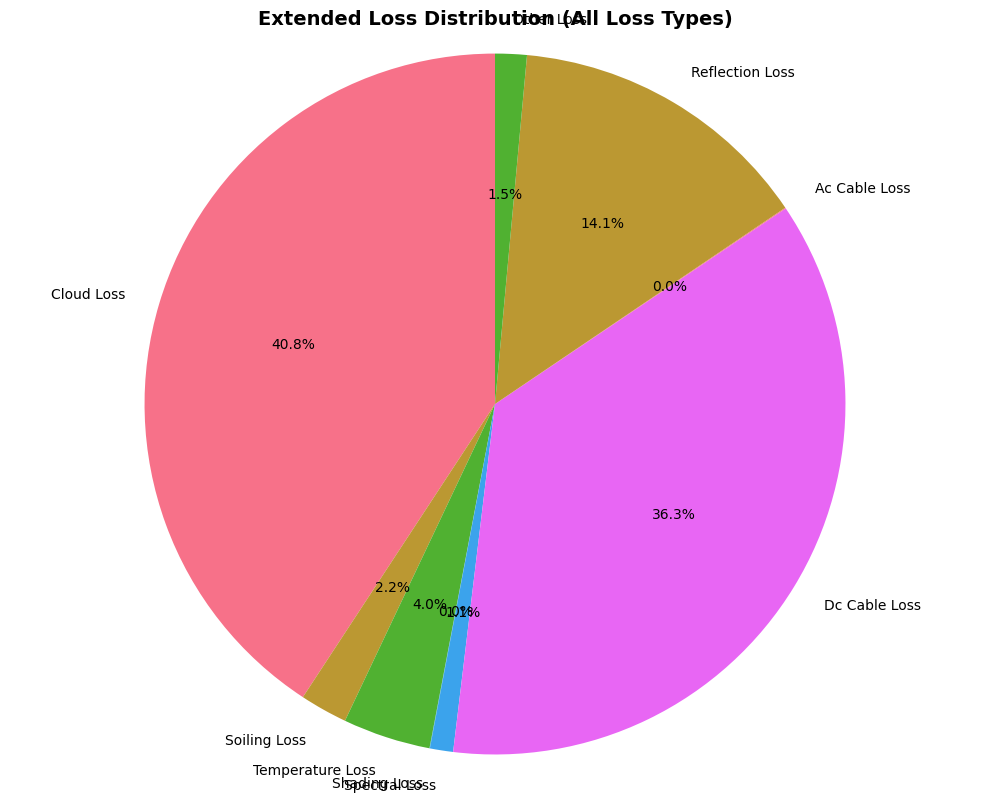

Creating visualization 2: Energy Flow Summary


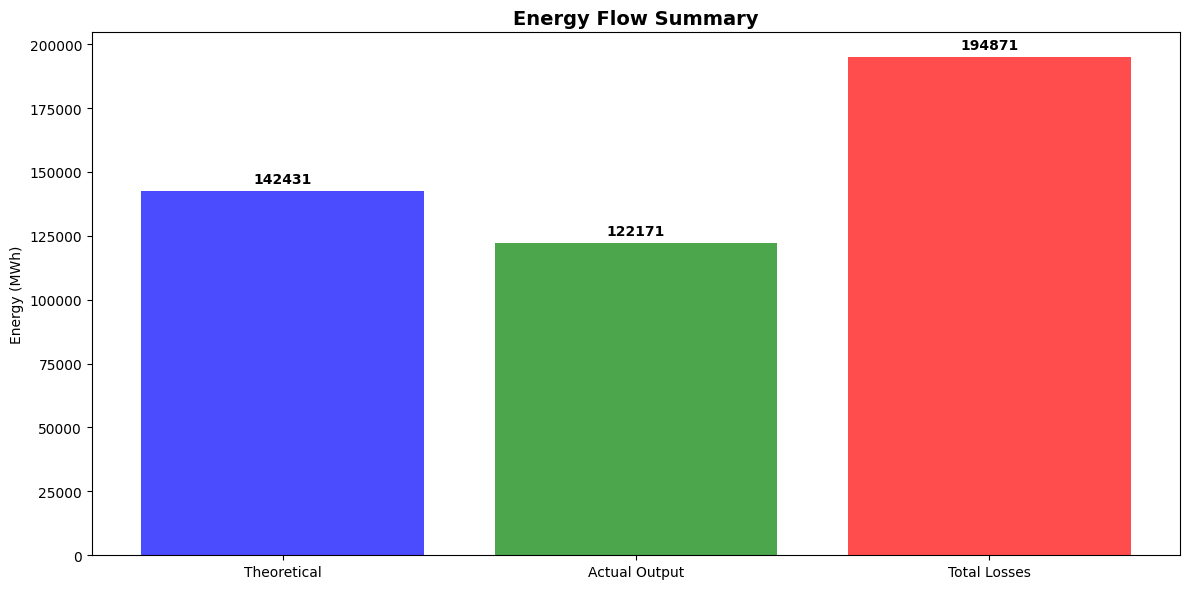

Creating visualization 3: Daily Loss Trend


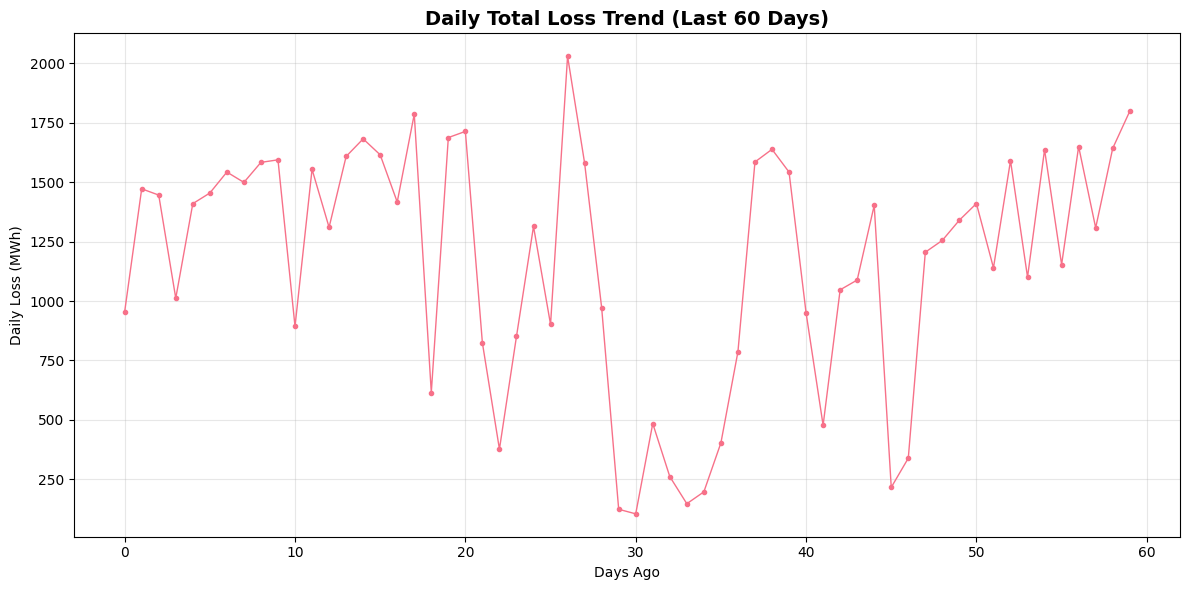

Creating visualization 4: Performance Ratio Distribution


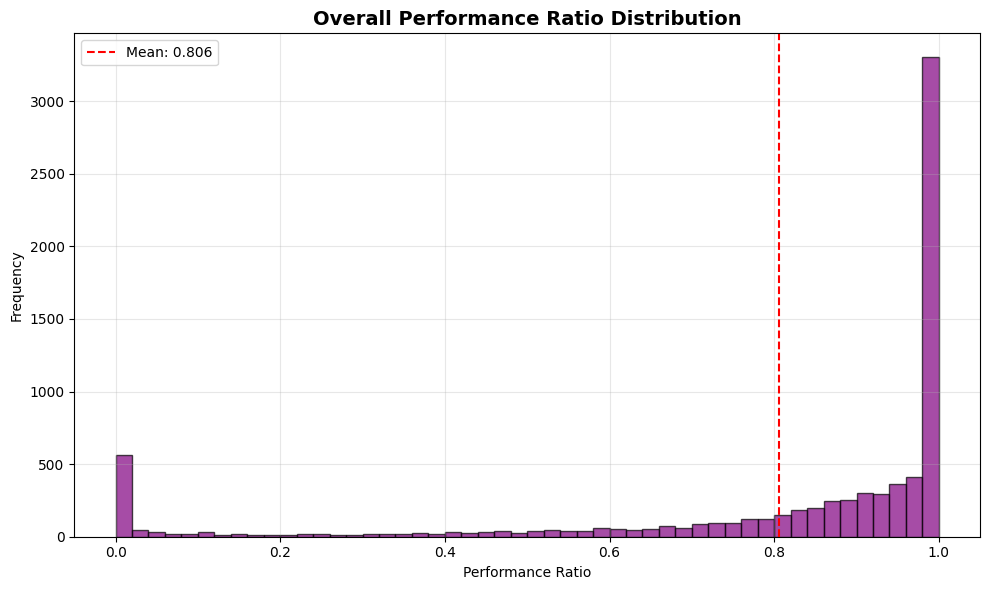

Creating visualization 5: Hourly Loss Heatmap


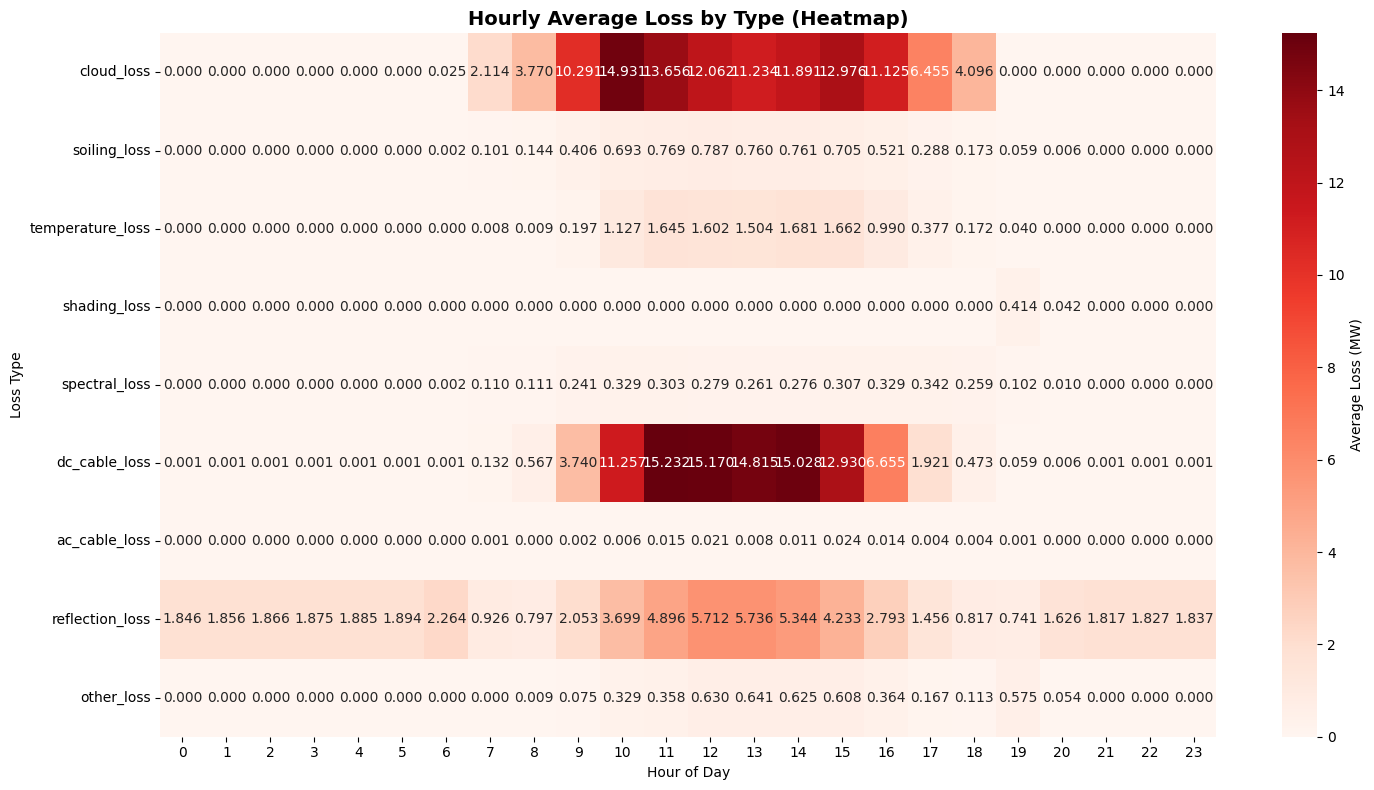

Creating visualization 6: Loss Correlation Matrix


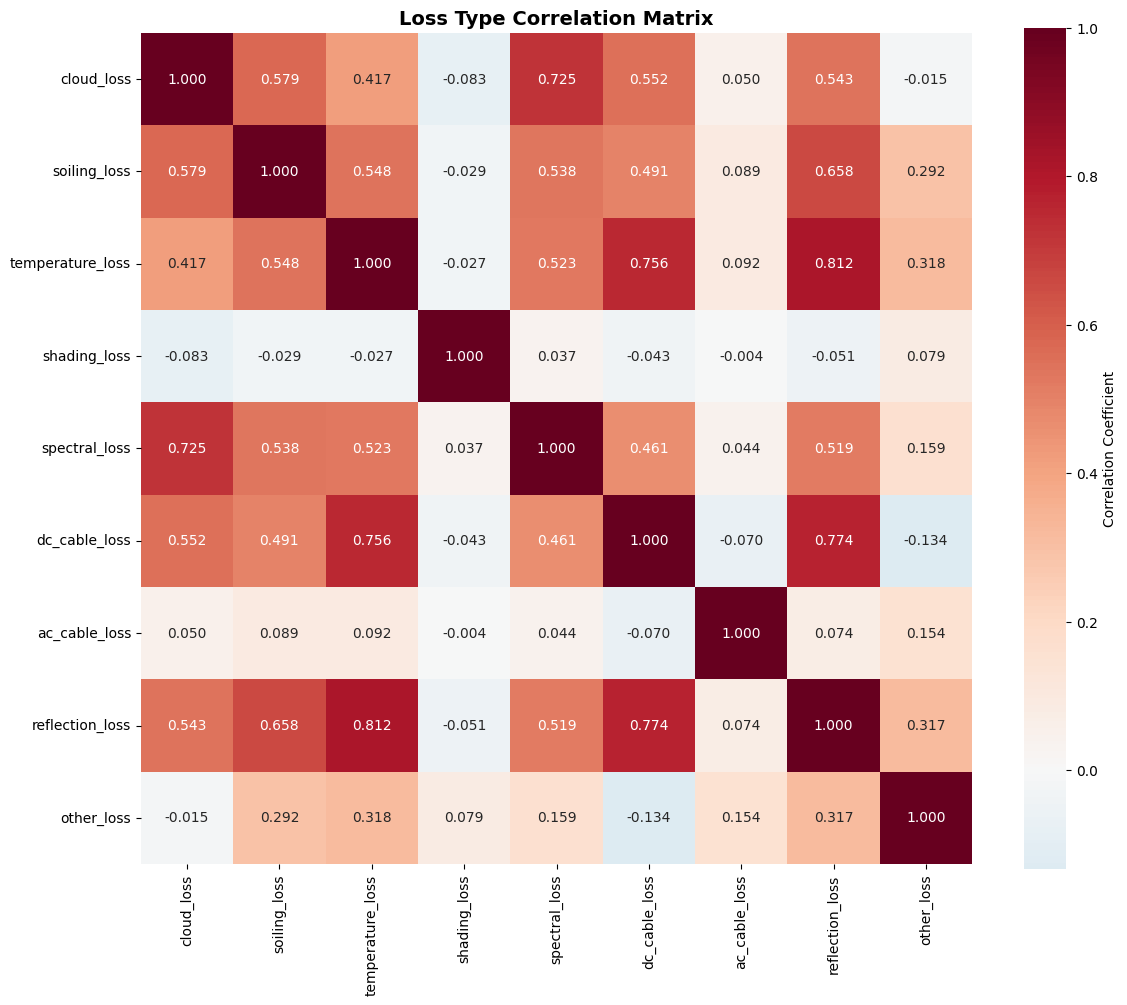

Creating visualization 7: Environmental vs Loss Correlation


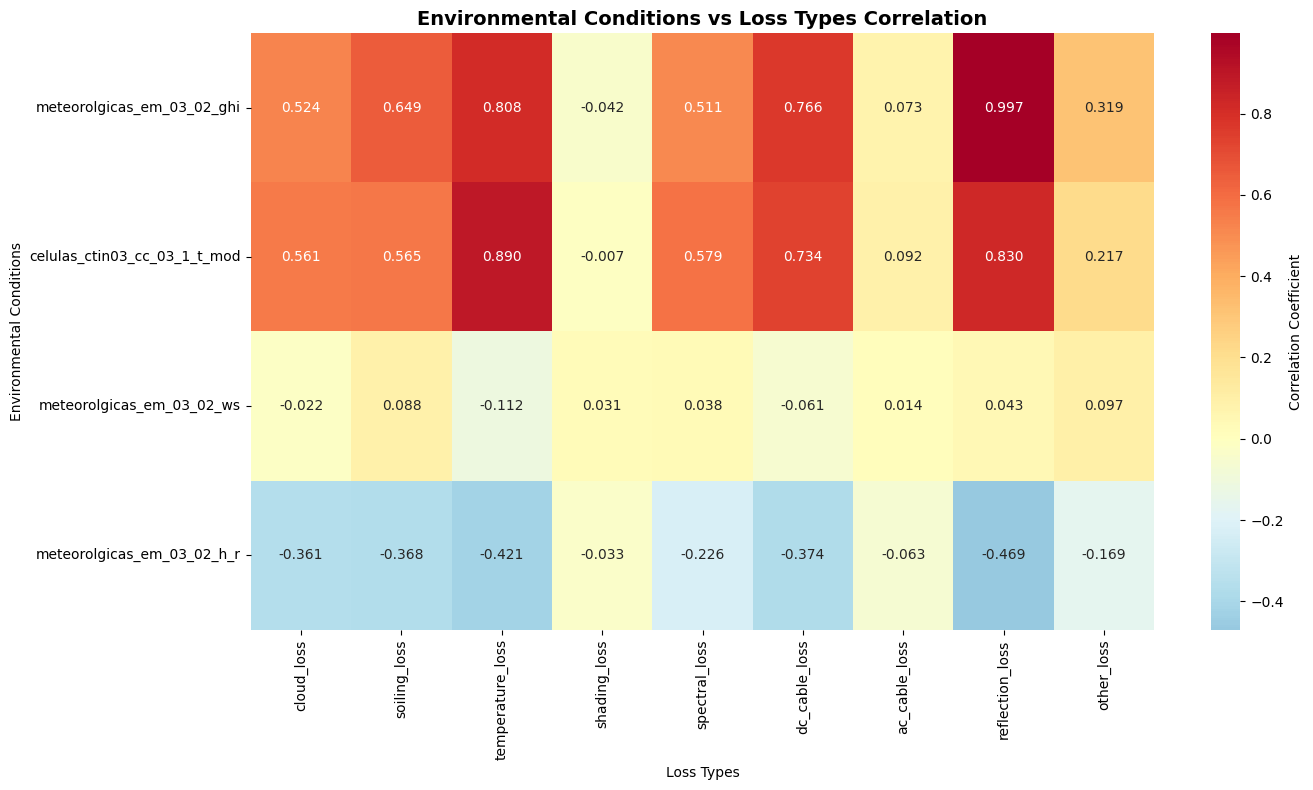

Creating visualization 8: Seasonal Loss Patterns


<Figure size 1400x800 with 0 Axes>

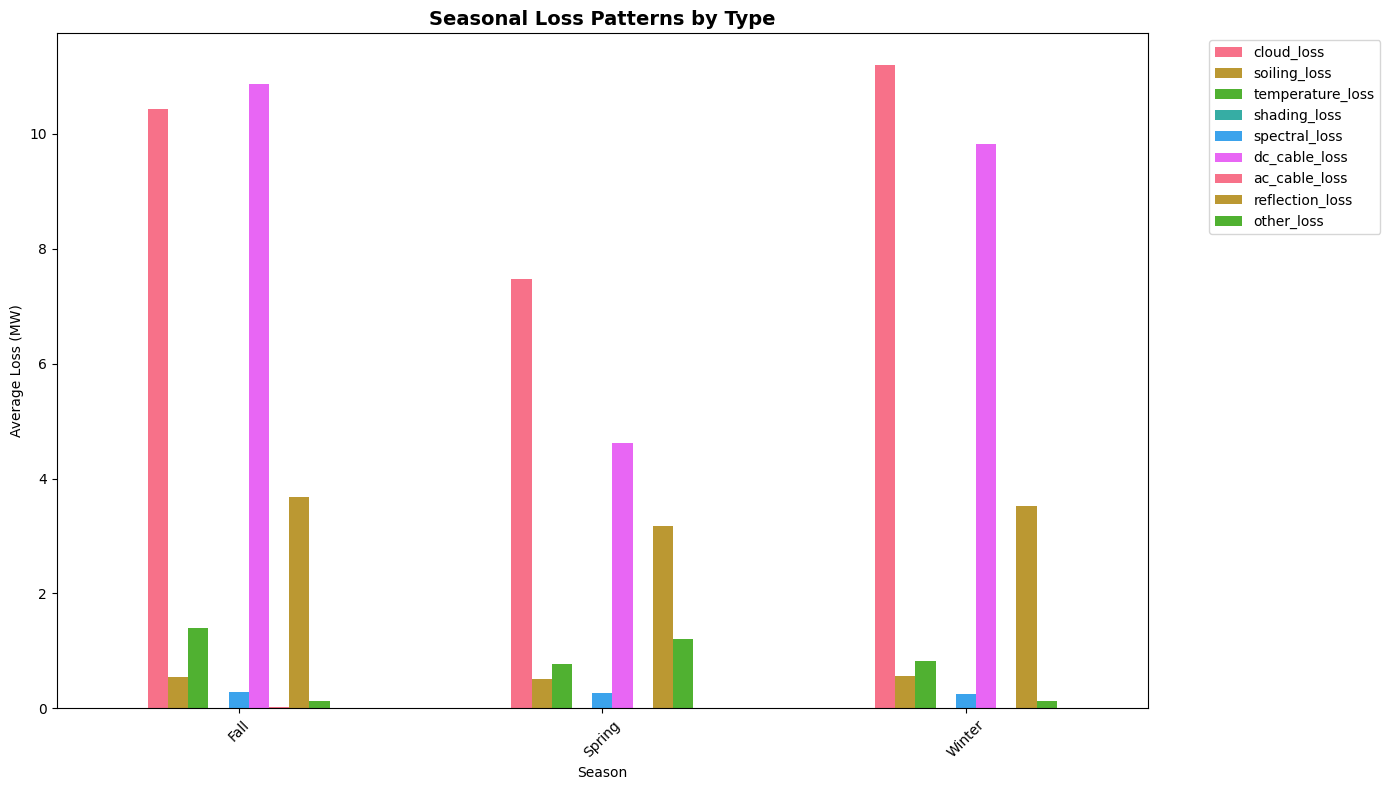

Creating visualization 9: Detailed Hourly Loss Patterns


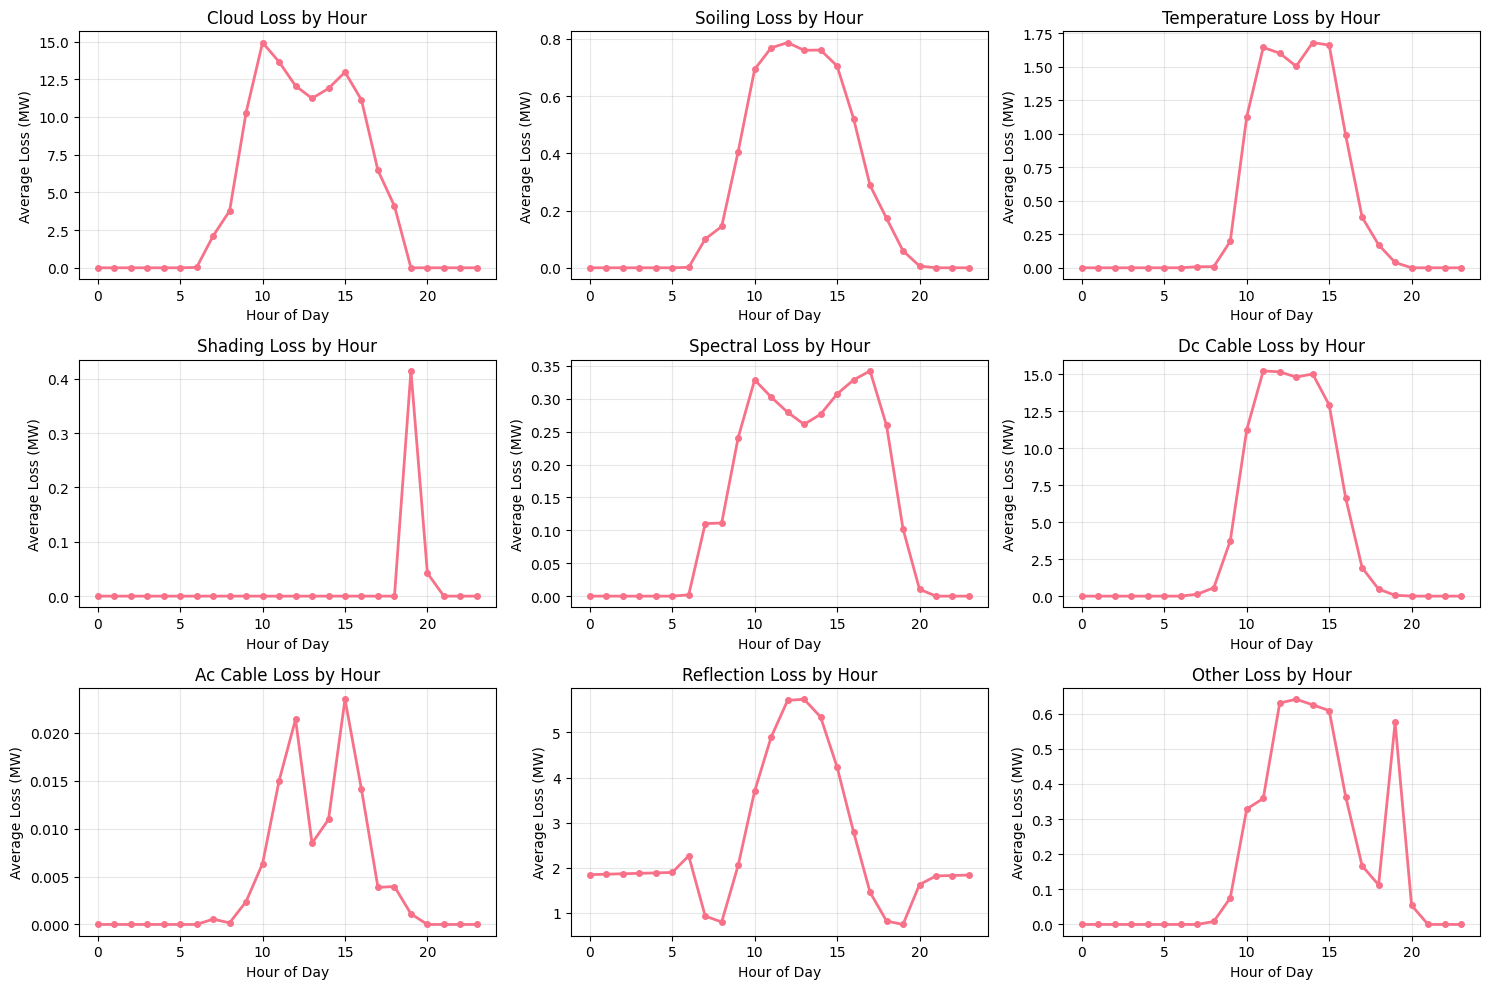

Creating visualization 10: Comprehensive Dashboard


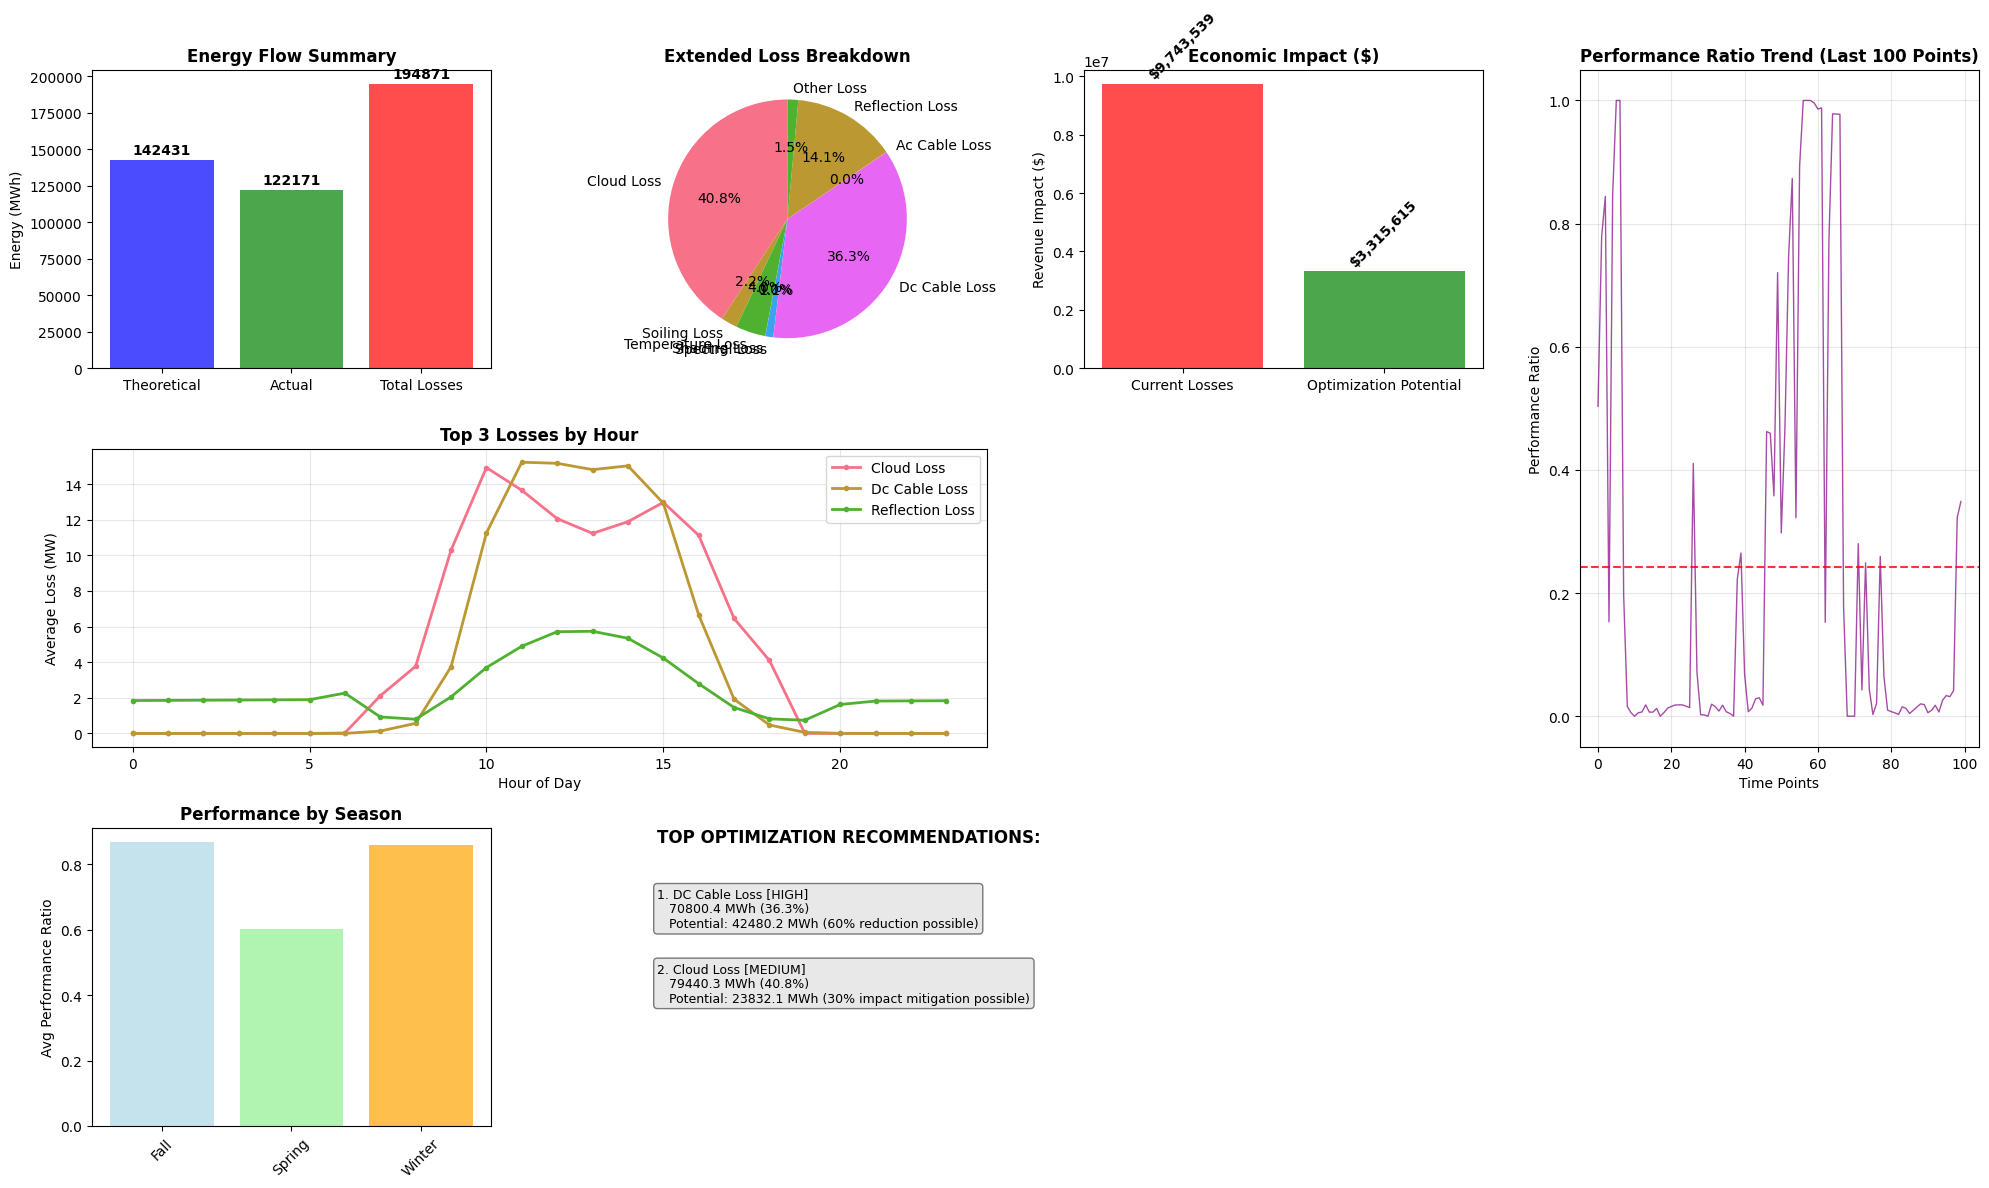

All visualizations created successfully!


In [38]:
create_all_visualizations()

### Conclusion

The extended solar loss analysis and visualization code provides a comprehensive framework to evaluate and interpret the performance of a solar PV plant. By breaking down total energy losses into various contributing factors — such as soiling, cloud cover, temperature effects, cable losses, and spectral and reflection losses — the analysis enables data-driven insights into system inefficiencies. The visualizations and trends generated by this code help in identifying critical loss patterns across time, seasons, and environmental conditions, and support the formulation of targeted performance optimization strategies. This detailed approach ensures that plant operators can make informed decisions to enhance energy yield and economic returns.


##  Team Information

**Team Name:** DRAGON TECH  

**Team Members:**
- Sartaj Singh Virdi (`svirdi_be23@thapar.edu`)
- Prabhpreet Singh (`psingh9_be23@thapar.edu`)
- Gurkirat Singh (`gsingh9_be23@thapar.edu`)